In [1]:
#проверка существования библиотек и их импорт, в случае отсутствия
from pip._internal import main
#используемые библиотеки
packages = ('numpy', 
            'pandas',
            'pandas_profiling',
            'sklearn',
            'seaborn',
            'missingno',
            'catboost',
            'xgboost',
            'tqdm',
            'hyperopt')

#проверка на доступность импорта, если нет, то устанавливаем библиотеку
def checkInstall(packages):
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            main(['install', package.split()[0]])

checkInstall(packages)


#базовые
import numpy as np
import pandas as pd
import pandas_profiling as ppf

#основные алгоритмы
import catboost as ctb
import xgboost as xgb

#sklearn
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold

#
from tqdm import tqdm
import warnings
import os
import time
import string
import functools
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from pandas.tools.plotting import parallel_coordinates
from sklearn.linear_model import LogisticRegression #для быстрой классификации
from sklearn.model_selection import train_test_split,  KFold 
from sklearn.metrics import roc_auc_score #проверяем качество модели
from hyperopt import hp, tpe, fmin, Trials,STATUS_OK, space_eval

#appendix
%matplotlib inline
warnings.filterwarnings('ignore')

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#используемые константные значение
main_file = 'data/general_final.csv'
agg_files = (main_file, 'data/traf_final.csv', 'data/rech_final.csv', 'data/balance_final.csv')

Набор data/general_final.csv содержит пропуски


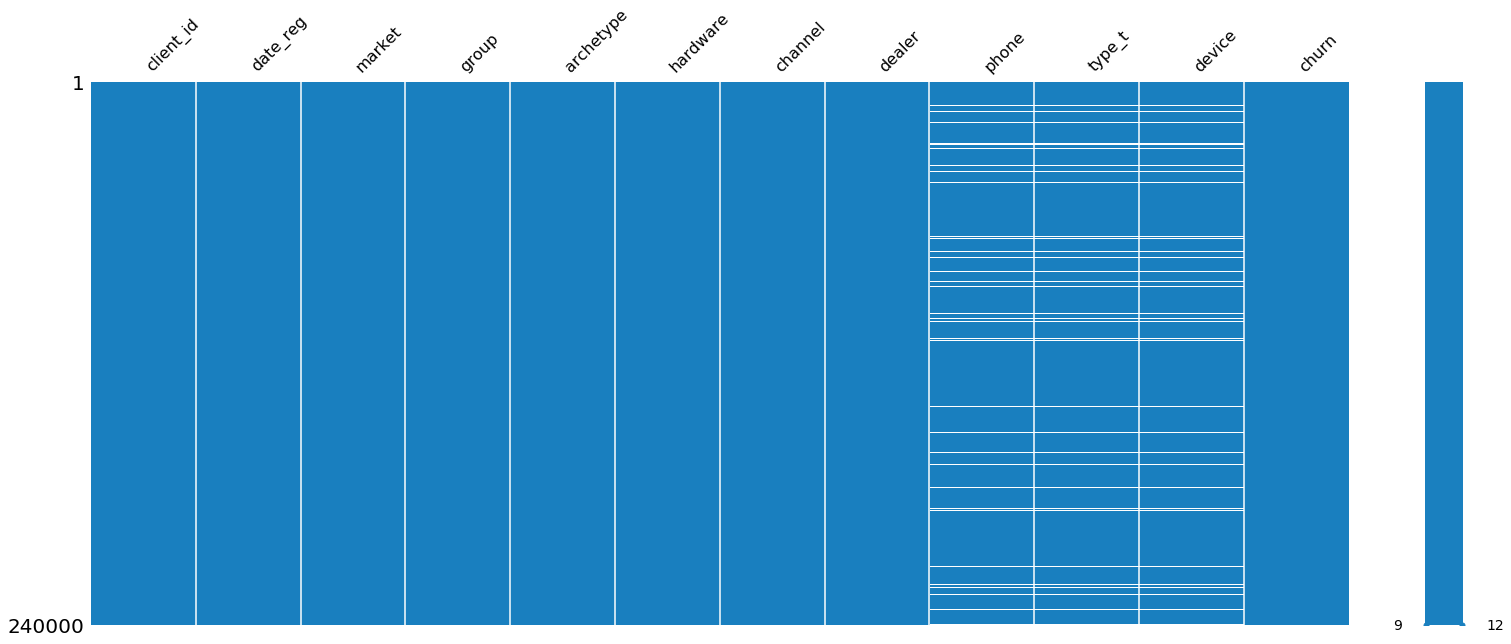

In [3]:
#обзор набора на количество пропусков
def ifna(file_name):
    #получаем размер файла
    #если больше 100мб, то его сложно будет читать, получим его частями
    fsize = int(os.stat(file_name).st_size / 1024)
    if fsize > 100:
        #chunksize = 50000 считается оптимальным размером для быстрой работы DataFrame
        chnks_frame = pd.read_csv(file_name, sep=',', encoding='utf-8', chunksize=50000)
        
        for chnk in chnks_frame:
            #проверяем найдены ли пропуски
            #если есть данные столбце, то они суммируются и запишутся в массив
            #после, проверем массив на услове > 0
            res = np.where(chnk.isna().sum().values > 0)[0].size
            
            if res:
                return file_name
    #если нет, то просто читаем файлы
    else:
        frame = pd.read_csv(file_name, sep=',', encoding='utf-8')
        #проверяем найдены ли пропуски
        #если есть данные столбце, то они суммируются и запишутся в массив
        #после, проверем массив на услове > 0
        res = np.where(frame.isna().sum().values > 0)[0].size
        if res:
                return file_name

#пройдемся по файлам и получим результат, если есть пропуски


"""
Пример, как посмотреть?

"""
for fn in agg_files:
    ismiss = ifna(fn)
    if ismiss:
        print('Набор {} содержит пропуски'.format(fn))
        msno.matrix(pd.read_csv(ismiss, sep=',', encoding='utf-8'), color = (0.1, 0.5, 0.75))

In [4]:
#получаем обзор набора данных
m_df = pd.read_csv(main_file, sep=',', encoding='utf-8')

#используем крутую библиотеку и делаем жизнь проще
ppf.ProfileReport(m_df)

In [5]:
m_df.head()

client_id               date_reg market  group  \
0  09777552-cc75-4f03-9438-11c3a7480f97  2016-05-10 00:00:00.0    R25  PP1_9   
1  5fbe2ea9-0c80-4164-b703-416b85c23d8c  2016-04-19 00:00:00.0    R25  PP1_9   
2  8cbd48c0-8f90-4f08-bef7-8f09d9924e55  2016-05-19 00:00:00.0    R25  PP1_9   
3  ffda8d15-cd38-45c3-84ba-29a9811ed79e  2016-05-28 00:00:00.0    R25  PP1_9   
4  1f9618ad-a980-4110-af32-9741e491a728  2016-05-23 00:00:00.0     R4  PP1_9   

  archetype hardware channel dealer  phone type_t device  churn  
0     PP2_0     PPT1   C1_22  C2_22  D2254  DT1_6  DT2_5    0.0  
1     PP2_0     PPT1    C1_6   C2_0    NaN    NaN    NaN    1.0  
2     PP2_0     PPT1    C1_6   C2_0  D2594  DT1_6  DT2_5    0.0  
3     PP2_0     PPT1   C1_22  C2_11  D3131  DT1_6  DT2_5    1.0  
4     PP2_0     PPT1   C1_28  C2_21   D454  DT1_6  DT2_5    0.0

### Data для Boostings

#### первая проблема CatFeatures !!!

In [6]:
#преобразуем значения
#1 - от даты оставим месяц и день недели. Добавим номер недели в году
#2 - остальные данные: значение * log(позиция буквы в словаре) - это даст нам цифру, а не строку
#3 - log нужен для не большого зачения позиции, но все равно понимания позиции

def dataToText(val):
    """
    преобразователь даты
    """
    year, month, day, _ = val.replace(' ', '-').split('-')  # заменить и разделить, быстрее чем искать RE lib
    woy = pd.to_datetime('{}{}{}'.format(year, month, day), format='%Y%m%d', errors='ignore').week #выделим номер недели в году
    return pd.Series([int(month), int(woy), int(day)])


def stringToDigit(val):
    """
    1. получим и распарсим строку
    2. преобразуем буквы в log(позиция буквы в алфавите)
    3. если есть число, то разделим на него log(позиция буквы в алфавите) / число (прмиер: DT / 2)
    4. если 2 буквы, то умножим результат (пример: (D*T) /2)
    """
    
    if pd.isnull(val):
        return val
        
    else:
        abc_lsit = list(string.ascii_lowercase)
        pos = []
        dig = []
        for v in list(val):
            try:
                pos.append(np.log(abc_lsit.index(v.lower())))
            except ValueError:
                if v in string.digits:
                    dig.append(int(v))

        #создадим новую зависимую от данных категорию
        new_cat = functools.reduce(lambda x, y: x*y, pos) * sum(dig)
        
        #нужно возвращать именно категории, разница между значениями больша, можно сделать int
        return int(new_cat)

#собирем новый набор
main_df = m_df.copy().drop(['date_reg', 'market', 'group', 'archetype', 
                           'hardware', 'channel', 'dealer', 'phone', 
                           'type_t', 'device'], axis = 1)
main_df[['month', 'woy', 'day']] = m_df['date_reg'].apply(dataToText)
#для всех переменных market, group, archetype, hardware, channel, dealer, phone, type_t, device
main_df['market'] = m_df['market'].apply(stringToDigit)
main_df['group'] = m_df['group'].apply(stringToDigit)
main_df['archetype'] = m_df['archetype'].apply(stringToDigit)
main_df['hardware'] = m_df['hardware'].apply(stringToDigit)
main_df['channel'] = m_df['channel'].apply(stringToDigit)
main_df['dealer'] = m_df['dealer'].apply(stringToDigit)
main_df['phone'] = m_df['phone'].apply(stringToDigit)
main_df['type_t'] = m_df['type_t'].apply(stringToDigit)
main_df['device'] = m_df['device'].apply(stringToDigit)
main_df.head()

client_id  churn  month  woy  day  market  \
0  09777552-cc75-4f03-9438-11c3a7480f97    0.0      5   19   10      19   
1  5fbe2ea9-0c80-4164-b703-416b85c23d8c    1.0      4   16   19      19   
2  8cbd48c0-8f90-4f08-bef7-8f09d9924e55    0.0      5   20   19      19   
3  ffda8d15-cd38-45c3-84ba-29a9811ed79e    1.0      5   21   28      19   
4  1f9618ad-a980-4110-af32-9741e491a728    0.0      5   21   23      11   

   group  archetype  hardware  channel  dealer  phone  type_t  device  
0     73         14        21        3       4   14.0    22.0    22.0  
1     73         14        21        4       1    NaN     NaN     NaN  
2     73         14        21        4       1   21.0    22.0    22.0  
3     73         14        21        3       2    8.0    22.0    22.0  
4     73         14        21        7       3   14.0    22.0    22.0

In [7]:
###простая логистическая
#параметры заданы автоматически, не буду применять автоподбор
#так как здесь не нужно большое качество, но это будет лучше, чем замены и авто подстановки
lgreg = LogisticRegression(penalty = 'l2', #для контроля за переобучением
                           C = 10.0 ,
                           solver = 'lbfgs', #подходит для регуляризации l2
                           max_iter = 150, #добавим 50 итераций к стандартному параметру, но выборка большая, можно не пименять
                           random_state = 28)

#Выбираем все пустые
mis_main_df = main_df[main_df.isnull().any(axis=1)]

In [8]:
varblist = ['phone', 'type_t', 'device']

def mlearning(varbl):
    """
    дополняет пустые данные 
    """
    
    #список для удаления столбцов
    dropped = list(('client_id', 'churn'))
    dropped.extend(varblist[varblist.index(varbl):])

    train = main_df.dropna().copy().drop(dropped, axis = 1)
    X = train
    Y = main_df[varbl].dropna().copy()

    lgreg.fit(X,Y)
    r = lgreg.predict(mis_main_df.drop(dropped, axis = 1)).astype(int)
    #возвращаем полученные данные, но для попадания данных на свои места, необходимо установить Индекс
    return pd.Series(r, index = mis_main_df.drop(dropped, axis = 1).index.values)
    
for clm in range(len(varblist)):
    mis_main_df[varblist[clm]] = mlearning(varblist[clm])

#создаем набор, который будет дополняться данными
mn_df = main_df.dropna().append(mis_main_df,ignore_index=True)
mn_df.head()

##########################################################
#mn_df <----основной набор!

client_id  churn  month  woy  day  market  \
0  09777552-cc75-4f03-9438-11c3a7480f97    0.0      5   19   10      19   
1  8cbd48c0-8f90-4f08-bef7-8f09d9924e55    0.0      5   20   19      19   
2  ffda8d15-cd38-45c3-84ba-29a9811ed79e    1.0      5   21   28      19   
3  1f9618ad-a980-4110-af32-9741e491a728    0.0      5   21   23      11   
4  29aeff5c-84f1-43c7-8455-29b961228c04    0.0      5   20   19      45   

   group  archetype  hardware  channel  dealer  phone  type_t  device  
0     73         14        21        3       4   14.0    22.0    22.0  
1     73         14        21        4       1   21.0    22.0    22.0  
2     73         14        21        3       2    8.0    22.0    22.0  
3     73         14        21        7       3   14.0    22.0    22.0  
4     73         58         0        2       2    9.0    32.0    19.0

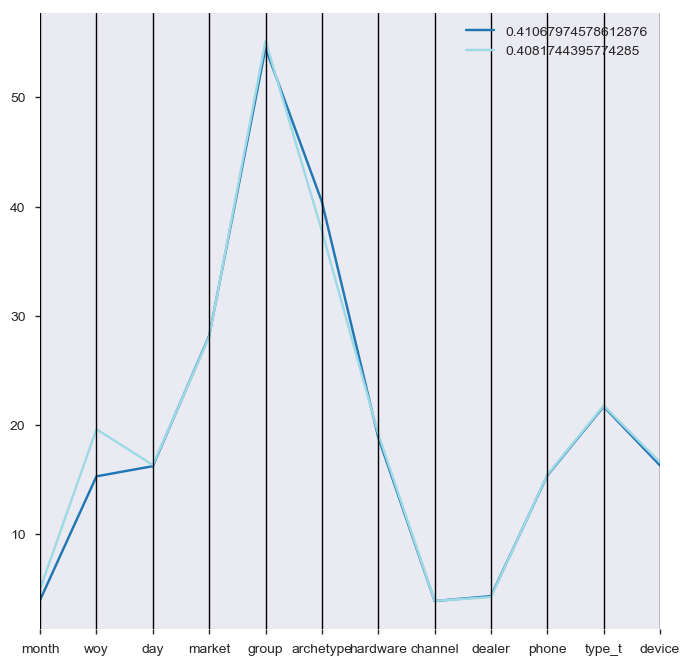

In [9]:
#посмотрим, как каждое значение (каждая группа) отражается в целевой переменной
#Построить перетекание переменной по месяца (целевой переменной)
#используем parallel plot

gp = mn_df.groupby('month').mean().reset_index()
plt.figure(figsize=(8,8))
parallel_coordinates(gp, 'churn', colormap=plt.get_cmap("tab20"))

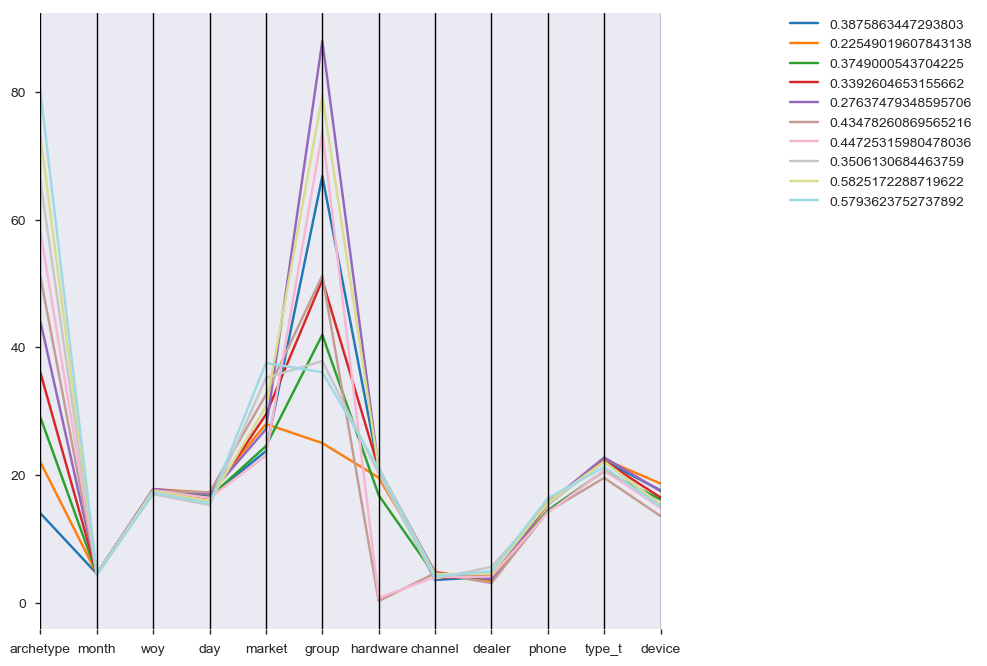

In [10]:
#на протяжение всех разбивок интересно выделяется - archetype 
#которая открыла большую вариацию


gp = mn_df.groupby('archetype').mean().reset_index()

plt.figure(figsize=(8,8))
parallel_coordinates(gp, 'churn', colormap=plt.get_cmap("tab20"))
#вынесем легенду, чтобы не мешалась
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

### Приготовили основной набор

Теперь посмотрим остальные файлы, порядок открытия:
- traf_final  - информация о трафике абонента
- balance_final - информация по счету пользователя
- rech_final - информация по пополнению баланса

Так как данная информация отражает жизненный цикл пользователя, то основной способ аггрегации будет: 

накопительный итог (когда данные считаются на промежутках от 1 до N дня)

## Вы уже можете придумать Категориальные фичи?


---------------
#### Как будет сгруппированно

- данные на 1, 3, 7, 14, 21, 28 дней
- данные накопитиельным итогом в промежутках 1-3, 1-3-7, 1-3-7-14, 1-3-7-14-21, 1-3-7-14-21-28
- соотношения входящих и исходящих данных за эти же периоды
- соотношение звонков к их дительности (dur)
- прямой и обратный накопительный итог длительности звонков
- соотношение суммы звонков к смс и обратное соотношение

По GPRS данным:
- данные обозначают движение (тарификацию переданных данных по количеству инормации)
- данных просчитываются накопительным и обратным итогом (от 28 к 1) (т.к. возможно поможет определить период "окончания интереса")
- соотношние к звонков / смс  к данным gprs
- соотношение суммы звонков и смс к данным по gprs
- соотношение суммы звонков к смс и общее соотношение к данным по gprs

Данные по пополнению: накопительыне данные и распределения (и по балансу)


In [11]:
df_cnks = pd.read_csv('data/traf_final.csv', sep=',', encoding='utf-8', chunksize=100000)

#файл будет сгруппирован по client_id 
#(в sql было бы проще, можно было выгрузить уже аггрегированные файлы)
#SQL: SELECT client_id, case when [conditions] then [result] end .. 
#FROM table {joins on table.client_id} GROUP BY client_id 

traf_df = pd.DataFrame()
traf = pd.DataFrame()
ds = pd.DataFrame()
ds_sum = pd.DataFrame()

days = (0, 1, 3, 7, 14, 21, 28)
#функции для группровки


for cnhk in df_cnks:

    for fnc in ['sum', 'max', 'min', 'std', 'mean']:
        d = cnhk.groupby(['client_id'])['call_in_num', 'call_out_num', 'call_in_dur'].agg(fnc).reset_index()
        d.columns = ['{}_{}'.format(col, fnc) if col != 'client_id' else col for col in d.columns ]
        
        if not traf.empty:
            if d['client_id'].unique() in traf['client_id'].unique():
                traf = traf.merge(d, how='left')
            
            else:                
                traf = traf.merge(d, how='outer')
        else:
            traf = d.copy()
    
    traf = traf.groupby('client_id').sum().reset_index()   
    #группировки по дням
    grpd = cnhk.head().groupby(['client_id', 'day']).sum()
    
    #перезагрузим индекс, чтобы быстрее обращаться к значениям, без мультииндекс
    grpd = grpd.reset_index()
    
      
    #сложная конструкция: условие на существование данных в № день, но рабочая
    #по дням с 1 по 28 день
    
    for n in range(len(days)):
        if n != 0:
            d = days[n]
            prev = days[n-1]
            
            #данные по дням (ds)
            #in call
            call_in = pd.DataFrame(columns=['client_id','call_in_{}'.format(d)])
            call_in[['client_id','call_in_{}'.format(d)]] = grpd[['client_id','call_in_num']][(grpd['day'] <= d) \
                                                                 | (grpd['day'] >= prev)] \
                                                    if not grpd[['client_id','call_in_num']][(grpd['day'] <= d) \
                                                                 | (grpd['day'] >= prev)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            
            #out call
            call_out = pd.DataFrame(columns=['client_id','call_out_{}'.format(d)])
            call_out[['client_id','call_out_{}'.format(d)]] = grpd[['client_id','call_out_num']][(grpd['day'] <= d) \
                                                                 | (grpd['day'] >= prev)] \
                                                    if not grpd[['client_id','call_out_num']][(grpd['day'] <= d) \
                                                                 | (grpd['day'] >= prev)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            #накопленный итог
            #in call
            call_in_sm = pd.DataFrame(columns=['client_id','call_in_sm_{}'.format(d)])
            call_in_sm[['client_id','call_in_sm_{}'.format(d)]] = grpd[['client_id','call_in_num']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)] \
                                                    if not grpd[['client_id','call_in_num']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            #out call
            call_out_sm = pd.DataFrame(columns=['client_id','call_out_sm_{}'.format(d)])
            call_out_sm[['client_id','call_out_sm_{}'.format(d)]] = grpd[['client_id','call_out_num']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)] \
                                                    if not grpd[['client_id','call_out_num']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            
            #накопленный итог (обратный)
            #in call
            call_in_sm_rev = pd.DataFrame(columns=['client_id','call_in_sm_rev_{}'.format(d)])
            call_in_sm_rev[['client_id','call_in_sm_rev_{}'.format(d)]] = grpd[['client_id','call_in_num']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] <= max(days))] \
                                                    if not grpd[['client_id','call_in_num']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] <= max(days))].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            
            #out call
            call_out_sm_rev = pd.DataFrame(columns=['client_id','call_out_sm_rev_{}'.format(d)])
            call_out_sm_rev[['client_id','call_out_sm_rev_{}'.format(d)]] = grpd[['client_id','call_out_num']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] <= max(days))] \
                                                    if not grpd[['client_id','call_out_num']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] <= max(days))].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            #gprs
            #обычная по дням
            gprs_d = pd.DataFrame(columns=['client_id','gprs_d_{}'.format(d)])
            gprs_d[['client_id','gprs_d_{}'.format(d)]] = grpd[['client_id','gprs']][(grpd['day'] <= d) \
                                                                 | (grpd['day'] >= prev)] \
                                                    if not grpd[['client_id','gprs']][(grpd['day'] <= d) \
                                                                 | (grpd['day'] >= prev)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
           
            
            #накопительный итог (прямой)
            gprs_d_sm = pd.DataFrame(columns=['client_id','gprs_d_sm_{}'.format(d)])
            gprs_d_sm[['client_id','gprs_d_sm_{}'.format(d)]] = grpd[['client_id','gprs']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)] \
                                                    if not grpd[['client_id','gprs']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            
            #накопительный итог (обатный)
            gprs_d_sm_rev = pd.DataFrame(columns=['client_id','gprs_d_sm_rev_{}'.format(d)])
            gprs_d_sm_rev[['client_id','gprs_d_sm_rev_{}'.format(d)]] = grpd[['client_id','gprs']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] <= max(days))] \
                                                    if not grpd[['client_id','gprs']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] <= max(days))].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T

            
            #данные по длительности
            #эти данные зависимы от времени, лучше всего подойдут накопительные итоги (лучшее отражение)
            #накопленный итог
            #in call dur
            call_in_dur_sm = pd.DataFrame(columns=['client_id','call_in_dur_sm_{}'.format(d)])
            call_in_dur_sm[['client_id','call_in_dur_sm_{}'.format(d)]] = grpd[['client_id','call_in_dur']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)] \
                                                    if not grpd[['client_id','call_in_dur']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            #out call dur
            call_out_dur_sm = pd.DataFrame(columns=['client_id','call_out_dur_sm_{}'.format(d)])
            call_out_dur_sm[['client_id','call_out_dur_sm_{}'.format(d)]] = grpd[['client_id','call_out_dur']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)] \
                                                    if not grpd[['client_id','call_out_dur']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            #in call dur
            call_in_dur_sm_rev = pd.DataFrame(columns=['client_id','call_in_dur_sm_rev_{}'.format(d)])
            call_in_dur_sm_rev[['client_id','call_in_dur_sm_rev_{}'.format(d)]] = grpd[['client_id','call_in_dur']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] < max(days))] \
                                                    if not grpd[['client_id','call_in_dur']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] < max(days))].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            #out call dur
            call_out_dur_sm_rev = pd.DataFrame(columns=['client_id','call_out_dur_sm_rev_{}'.format(d)])
            call_out_dur_sm_rev[['client_id','call_out_dur_sm_rev_{}'.format(d)]] = grpd[['client_id','call_out_dur']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] < max(days))] \
                                                    if not grpd[['client_id','call_out_dur']][(grpd['day'] >= d) \
                                                                 & (grpd['day'] < max(days))].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            
            
            #смс данные будут нужны только накопительным итогом, так как это хорошая прекция на 
            #увеличение и уменьшение активности (и для проекции на трафик (из-за месседжеров))
            #sms
            sms_out_sm = pd.DataFrame(columns=['client_id','sms_out_sm_{}'.format(d)])
            sms_out_sm[['client_id','sms_out_sm_{}'.format(d)]] = grpd[['client_id','sms_out_num']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)] \
                                                    if not grpd[['client_id','sms_out_num']][(grpd['day'] <= d) \
                                                                 & (grpd['day'] >= 0)].empty \
                                                    else pd.DataFrame(data = [grpd['client_id'].unique(), [0] * len(grpd['client_id'].unique())]).T
            
            #собираем данные в одну таблцицу
            ds = ds.append(call_in.groupby('client_id').sum().reset_index())
            ds['call_out_{}'.format(d)] = call_out.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_in_sm_{}'.format(d)] = call_in_sm.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_out_sm_{}'.format(d)] = call_out_sm.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_in_sm_rev_{}'.format(d)] = call_in_sm_rev.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_out_sm_rev_{}'.format(d)] = call_out_sm_rev.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['gprs_d_{}'.format(d)] = gprs_d.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['gprs_d_sm_{}'.format(d)] = gprs_d_sm.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['gprs_d_sm_rev{}'.format(d)] = gprs_d_sm_rev.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_in_dur_sm_{}'.format(d)] = call_in_dur_sm.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_out_dur_sm_{}'.format(d)] = call_out_dur_sm.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_in_dur_sm_rev_{}'.format(d)] = call_in_dur_sm_rev.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['call_out_dur_sm_rev_{}'.format(d)] = call_out_dur_sm_rev.groupby('client_id').sum().reset_index().iloc[:,1:]
            ds['sms_out_sm_{}'.format(d)] = sms_out_sm.groupby('client_id').sum().reset_index().iloc[:,1:]
           
            
#Высчитаем с соотношения
traf = traf.merge(ds.groupby('client_id').sum().reset_index(), on = 'client_id', how='left')

#Входящих к исходящим
traf['call_in_sum_to_out_sum'] = traf['call_in_num_sum'] /traf['call_out_num_sum']
traf['call_in_sum_to_out_max'] = traf['call_in_num_max'] /traf['call_out_num_max']
traf['call_in_sum_to_out_mean'] = traf['call_in_num_mean'] /traf['call_out_num_mean']
traf['call_in_sum_to_out_std'] = traf['call_in_num_std'] /traf['call_out_num_std']
traf['call_in_sum_to_out_min'] = traf['call_in_num_min'] /traf['call_out_num_min']

for day in days[1:]:
    
    #Входящие к cумме, макс, сред, ско, мин
    traf['call_in_{}_to_sum'.format(day)] = traf['call_in_{}'.format(day)] /  traf['call_in_num_sum']
    traf['call_out_{}_to_sum'.format(day)] = traf['call_out_{}'.format(day)] / traf['call_out_num_sum']
    traf['call_in_{}_to_max'.format(day)] = traf['call_in_{}'.format(day)] / traf['call_in_num_max'] 
    traf['call_out_{}_to_max'.format(day)] = traf['call_out_{}'.format(day)] / traf['call_out_num_max']
    traf['call_in_{}_to_mean'.format(day)] = traf['call_in_{}'.format(day)] / traf['call_in_num_mean'] 
    traf['call_out_{}_to_mean'.format(day)] = traf['call_out_{}'.format(day)] / traf['call_out_num_mean']
    traf['call_in_{}_to_std'.format(day)] = traf['call_in_{}'.format(day)] / traf['call_in_num_std'] 
    traf['call_out_{}_to_std'.format(day)] = traf['call_out_{}'.format(day)] / traf['call_out_num_std']
    traf['call_in_{}_to_min'.format(day)] = traf['call_in_{}'.format(day)] / traf['call_in_num_min'] 
    traf['call_out_{}_to_min'.format(day)] = traf['call_out_{}'.format(day)] / traf['call_out_num_min']
    
    #входящих по дням к накопительным по дням
    traf['call_in_{}_to_sm'.format(day)] = traf['call_in_{}'.format(day)] /  traf['call_in_sm_{}'.format(day)]
    traf['call_out_{}_to_sm'.format(day)] = traf['call_out_{}'.format(day)] / traf['call_out_sm_{}'.format(day)]
    
    #накопительный к сумме, макс, сред, ско, мин
    traf['call_in_sm_{}_to_sum'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['call_in_num_sum']
    traf['call_out_sm_{}_to_sum'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['call_out_num_sum']
    traf['call_in_sm_{}_to_sum'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['call_in_num_max']
    traf['call_out_sm_{}_to_sum'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['call_out_num_max']
    traf['call_in_sm_{}_to_sum'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['call_in_num_mean']
    traf['call_out_sm_{}_to_sum'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['call_out_num_mean']
    traf['call_in_sm_{}_to_sum'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['call_in_num_std']
    traf['call_out_sm_{}_to_sum'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['call_out_num_std']
    traf['call_in_sm_{}_to_sum'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['call_in_num_min']
    traf['call_out_sm_{}_to_sum'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['call_out_num_min']
    
    #накопительниый по звонкам (входящим и исходящим) к длительности
    traf['call_in_sm_{}_to_dur'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['call_in_dur_sm_{}'.format(day)]
    traf['call_out_sm_{}_to_dur'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['call_out_dur_sm_{}'.format(day)]
    
    #cоотношение звонков к смс
    traf['call_in_{}_to_sms'.format(day)] = traf['call_in_{}'.format(day)] /  traf['sms_out_sm_{}'.format(day)]
    traf['call_out_{}_to_sms'.format(day)] = traf['call_out_{}'.format(day)] / traf['sms_out_sm_{}'.format(day)]
    
    #соотношение звонков к данным gprs
    traf['call_in_sm_{}_to_gprs'.format(day)] = traf['call_in_sm_{}'.format(day)] /  traf['gprs_d_sm_{}'.format(day)]
    traf['call_out_sm_{}_to_gprs'.format(day)] = traf['call_out_sm_{}'.format(day)] / traf['gprs_d_sm_{}'.format(day)]
    
    #соотношение смс к данным gprs
    traf['sms_sm_{}_to_gprs'.format(day)] = traf['sms_out_sm_{}'.format(day)] /  traf['gprs_d_sm_{}'.format(day)]
    traf['sms_sm_{}_to_gprs'.format(day)] = traf['sms_out_sm_{}'.format(day)] / traf['gprs_d_{}'.format(day)]
    
    #длительность звонков к данным gprs и смс
    traf['call_in_sm_dur_{}_to_sms'.format(day)] = traf['call_in_dur_sm_{}'.format(day)] /  traf['sms_out_sm_{}'.format(day)]
    traf['call_out_sm_dur_{}_to_sms'.format(day)] = traf['call_out_dur_sm_{}'.format(day)] / traf['sms_out_sm_{}'.format(day)]
    traf['call_in_sm_dur_{}_to_gprs'.format(day)] = traf['call_in_dur_sm_{}'.format(day)] /  traf['gprs_d_sm_{}'.format(day)]
    traf['call_out_sm_dur_{}_to_gprs'.format(day)] = traf['call_out_dur_sm_{}'.format(day)] / traf['gprs_d_sm_{}'.format(day)]

    
    
#из-за того, что у нас есть деления на 0 или 0 параметры
#результат деления будет равен Nan или inf
#Это тот самый вариант, когда можно заменить просто fillna
#но не 0, а минимальным значением, т.к 0 может быть доступным параметром
traf.replace([np.inf, -np.inf], np.nan, inplace = True)
traf.fillna(0.000001, inplace=True)
traf.head()
# 250 новых переменных
#! Можно придумать ещё порядка 300 переменных по данному материалу. Соотношения и вариации от сумм и прочее
# Но они будут зависимы и высококоррелируещие между собой
# Для модели они будут не нужны и откинуты      
                                            
        
   
    
    

client_id  call_in_num_sum  call_out_num_sum  \
0  000015c6-94a3-4989-861a-ebd71c848c68            102.0             250.0   
1  00007210-4b79-4845-bdcc-b3621e65e2bf              0.0               0.0   
2  0000a503-c107-4578-9410-be301f142013              7.0              34.0   
3  0000d08d-2a6f-4f84-b660-298678c422f7              0.0               0.0   
4  0000e8f2-3741-4196-8d7f-c19ff7a10453            192.0             785.0   

   call_in_dur_sum  call_in_num_max  call_out_num_max  call_in_dur_max  \
0          16542.0              9.0              21.0           2896.0   
1              0.0              0.0               0.0              0.0   
2            586.0              3.0              13.0            312.0   
3              0.0              0.0               0.0              0.0   
4          14098.0             27.0              76.0           1995.0   

   call_in_num_min  call_out_num_min  call_in_dur_min  \
0              0.0               1.0              0.0   
1              0.0               0.0              0.0   
2              0.0               1.0              0.0   
3              0.0               0.0              0.0   
4              0.0               0.0              0.0   

              ...              call_out_sm_28_to_dur  call_in_28_to_sms  \
0             ...                           0.000001           0.000001   
1             ...                           0.000001           0.000001   
2             ...                           0.000001           0.000001   
3             ...                           0.000001           0.000001   
4             ...                           0.000001           0.000001   

   call_out_28_to_sms  call_in_sm_28_to_gprs  call_out_sm_28_to_gprs  \
0            0.000001               0.000001                0.000001   
1            0.000001               0.000001                0.000001   
2            0.000001               0.000001                0.000001   
3            0.000001               0.000001                0.000001   
4            0.000001               0.000001                0.000001   

   sms_sm_28_to_gprs  call_in_sm_dur_28_to_sms  call_out_sm_dur_28_to_sms  \
0           0.000001                  0.000001                   0.000001   
1           0.000001                  0.000001                   0.000001   
2           0.000001                  0.000001                   0.000001   
3           0.000001                  0.000001                   0.000001   
4           0.000001                  0.000001                   0.000001   

   call_in_sm_dur_28_to_gprs  call_out_sm_dur_28_to_gprs  
0                   0.000001                    0.000001  
1                   0.000001                    0.000001  
2                   0.000001                    0.000001  
3                   0.000001                    0.000001  
4                   0.000001                    0.000001  

[5 rows x 255 columns]

### Важно!

В отличии от предыдущих данных, к последующим будет примена стандартизация переменной

Что это означает:
- перменная будет показана обычна и после предобработки
- предобработка: переменная = стреднее значение / СКО

In [12]:
df_cnks = pd.read_csv('data/balance_final.csv', sep=',', encoding='utf-8', chunksize=100000)

df_balance = pd.DataFrame()
for cnhk in df_cnks:
    
    for fnc in ['sum', 'max', 'min', 'std', 'mean']:
        
        balance = cnhk.groupby(['client_id', pd.cut(cnhk.day, [1,5,10,15,20,25,30],\
                         labels=['bal_{}_up_5_d'.format(fnc), 'bal_{}_up_10_d'.format(fnc), 
                                 'bal_{}_up_15_d'.format(fnc), 'bal_{}_up_20_d'.format(fnc),
                                 'bal_{}_up_25_d'.format(fnc), 'bal_{}_up_30_d'.format(fnc)])])\
                         ['balance'].agg(fnc).unstack().fillna(0).rename(columns=str).reset_index()
            
        if not df_balance.empty:
            if balance['client_id'].unique() in df_balance['client_id'].unique():
                df_balance = df_balance.merge(balance, how='left')
            
            else:                
                df_balance = df_balance.merge(balance, how='outer')
        else:
            df_balance = balance.copy()
    
    #собираем данные в одну таблцицу
    df_balance = df_balance.groupby('client_id').sum().reset_index()
    
    
    
df_balance.fillna(0, inplace = True)
df_balance.head()

day                             client_id  bal_sum_up_5_d  bal_sum_up_10_d  \
0    000015c6-94a3-4989-861a-ebd71c848c68      4137.92960      3670.744000   
1    00007210-4b79-4845-bdcc-b3621e65e2bf        63.40376      -124.805296   
2    0000a503-c107-4578-9410-be301f142013     11346.73689     16380.728470   
3    0000d08d-2a6f-4f84-b660-298678c422f7     -6674.08000     -8342.600000   
4    0000e8f2-3741-4196-8d7f-c19ff7a10453      1187.98624      1484.982800   

day  bal_sum_up_15_d  bal_sum_up_20_d  bal_sum_up_25_d  bal_sum_up_30_d  \
0        2002.224000      2335.928000      8676.304000      5152.389760   
1        -186.874240      -186.874240      -186.874240      -149.499392   
2       14775.745712     11995.991392      9216.237072      5371.566547   
3       -8342.600000     -8342.600000     -8342.600000     -6674.080000   
4        1484.982800      1418.242000      1384.871600       880.978560   

day  bal_max_up_5_d  bal_max_up_10_d  bal_max_up_15_d        ...         \
0       1134.593600       867.630400       533.926400        ...          
1         50.055600       -16.685200       -37.374848        ...          
2       3003.469482      3622.290179      3177.529488        ...          
3      -1668.520000     -1668.520000     -1668.520000        ...          
4        296.996560       296.996560       296.996560        ...          

day  bal_std_up_15_d  bal_std_up_20_d  bal_std_up_25_d  bal_std_up_30_d  \
0          105.52647       824.188081        105.52647       249.602264   
1            0.00000         0.000000          0.00000         0.000000   
2          175.80710       175.807100        175.80710       143.545896   
3            0.00000         0.000000          0.00000         0.000000   
4            0.00000         8.174045          0.00000         6.674080   

day  bal_mean_up_5_d  bal_mean_up_10_d  bal_mean_up_15_d  bal_mean_up_20_d  \
0        1034.482400        734.148800        400.444800        467.185600   
1          15.850940        -24.961059        -37.374848        -37.374848   
2        2836.684222       3276.145694       2955.149142       2399.198278   
3       -1668.520000      -1668.520000      -1668.520000      -1668.520000   
4         296.996560        296.996560        296.996560        283.648400   

day  bal_mean_up_25_d  bal_mean_up_30_d  
0         1735.260800       1288.097440  
1          -37.374848        -37.374848  
2         1843.247414       1342.891637  
3        -1668.520000      -1668.520000  
4          276.974320        220.244640  

[5 rows x 31 columns]

In [13]:
rech = pd.read_csv('data/rech_final.csv', sep=',', encoding='utf-8')

#файл будет сгруппирован по client_id и по дням

#в этих данных намного проще, так как все можно сгруппировать в одну строку

rech_grpd_sum = rech.groupby(['client_id', pd.cut(rech.day, [1,5,10,15,20,25,30],\
                         labels=['sm_up_5_d', 'sm_up_10_d', 'sm_up_15_d', 'sm_up_20_d', 'sm_up_25_d', 'sm_up_30_d'])])\
                         ['recharges'].sum().unstack().fillna(0).rename(columns=str).reset_index()

#группируем и задаем интервалы разбиения
#имена интервалов - имена столбцов
#полседняя строка: функция, собираем результат в таблицу, заполняем данные, переводим имена колонок в str

#повторим для макс, мин, медианы и ско
rech_grpd_max = rech.groupby(['client_id', pd.cut(rech.day, [1,5,10,15,20,25,30],\
                         labels=['max_up_5_d', 'max_up_10_d', 'max_up_15_d', 'max_up_20_d', 'max_up_25_d', 'max_up_30_d'])])\
                         ['recharges'].max().unstack().fillna(0).rename(columns=str).reset_index()
rech_grpd_min = rech.groupby(['client_id', pd.cut(rech.day, [1,5,10,15,20,25,30],\
                         labels=['min_up_5_d', 'min_up_10_d', 'min_up_15_d', 'min_up_20_d', 'min_up_25_d', 'min_up_30_d'])])\
                         ['recharges'].min().unstack().fillna(0).rename(columns=str).reset_index()
rech_grpd_mean = rech.groupby(['client_id', pd.cut(rech.day, [1,5,10,15,20,25,30],\
                         labels=['mn_up_5_d', 'mn_up_10_d', 'mn_up_15_d', 'mn_up_20_d', 'mn_up_25_d', 'mn_up_30_d'])])\
                         ['recharges'].mean().unstack().fillna(0).rename(columns=str).reset_index()
rech_grpd_std = rech.groupby(['client_id', pd.cut(rech.day, [1,5,10,15,20,25,30],\
                         labels=['std_up_5_d', 'std_up_10_d', 'std_up_15_d', 'std_up_20_d', 'std_up_25_d', 'std_up_30_d'])])\
                         ['recharges'].std().unstack().fillna(0).rename(columns=str).reset_index()

#стандартизация денежного потока
rech_strt = pd.DataFrame(rech.groupby(['client_id'])['recharges'].mean() / rech.groupby(['client_id'])['recharges']\
                         .std()).fillna(0).reset_index()
    
rech = pd.concat([rech_grpd_sum, rech_grpd_max.drop('client_id', axis = 1), 
               rech_grpd_min.drop('client_id', axis = 1), rech_grpd_mean.drop('client_id', axis = 1),
               rech_grpd_std.drop('client_id', axis = 1),
               rech_strt.drop('client_id', axis = 1)], 
               axis = 1)
rech.fillna(0, inplace = True)
del rech.columns.name

#Данные из этой таблицы можно соотнести с основными данными пользователя
#Но, обычно, данные отражающие денежный поток во времени, не отражают действительной картины изменений
#поведения пользователей по ряду причин.

#Переменные от денежного потока всегда высококоррелируемые

rech.head()

client_id  sm_up_5_d   sm_up_10_d  sm_up_15_d  \
0  000015c6-94a3-4989-861a-ebd71c848c68     0.0000     0.000000     0.00000   
1  0000a503-c107-4578-9410-be301f142013     0.0000  1214.816042     0.00000   
2  000184d3-beee-432b-aede-453203a223b8  7341.4880     0.000000     0.00000   
3  0001c87e-ddf6-43da-b3be-1266ec9faeba  1334.8160  1281.423360  1288.09744   
4  000266c3-8081-4b84-8f80-1e44afb6d935   300.3336   100.111200   333.70400   

    sm_up_20_d  sm_up_25_d  sm_up_30_d  max_up_5_d  max_up_10_d  max_up_15_d  \
0  2002.224000     0.00000     0.00000      0.0000     0.000000       0.0000   
1     0.000000     0.00000     0.00000      0.0000  1214.816042       0.0000   
2     0.000000     0.00000     0.00000   7341.4880     0.000000       0.0000   
3  3871.700549  1228.03072   146.82976   1334.8160   667.408000     667.4080   
4   266.963200   333.70400   480.53376    300.3336   100.111200     200.2224   

     ...      mn_up_20_d  mn_up_25_d  mn_up_30_d  std_up_5_d  std_up_10_d  \
0    ...      2002.22400     0.00000     0.00000         0.0     0.000000   
1    ...         0.00000     0.00000     0.00000         0.0     0.000000   
2    ...         0.00000     0.00000     0.00000         0.0     0.000000   
3    ...       774.34011   614.01536   146.82976         0.0    37.754298   
4    ...       266.96320   333.70400   240.26688         0.0     0.000000   

   std_up_15_d  std_up_20_d  std_up_25_d  std_up_30_d  recharges  
0     0.000000     0.000000          0.0     0.000000   0.000000  
1     0.000000     0.000000          0.0     0.000000  15.023856  
2     0.000000     0.000000          0.0     0.000000   0.000000  
3    33.035011   225.261068          0.0     0.000000   2.475872  
4    47.192872     0.000000          0.0   132.140042   2.183141  

[5 rows x 32 columns]

### Соберем файлы в один Data Set )

In [14]:
#используем merge - полный аналог join в SQL
mn_df = pd.merge(mn_df, traf, on = 'client_id', how = 'left')
mn_df = pd.merge(mn_df, rech, on = 'client_id', how = 'left')
mn_df = pd.merge(mn_df, df_balance, on = 'client_id', how = 'left')
mn_df.replace([np.inf, -np.inf], np.nan, inplace = True)
mn_df.fillna(0.000001, inplace = True)
mn_df.head()

client_id  churn  month  woy  day  market  \
0  09777552-cc75-4f03-9438-11c3a7480f97    0.0      5   19   10      19   
1  8cbd48c0-8f90-4f08-bef7-8f09d9924e55    0.0      5   20   19      19   
2  ffda8d15-cd38-45c3-84ba-29a9811ed79e    1.0      5   21   28      19   
3  1f9618ad-a980-4110-af32-9741e491a728    0.0      5   21   23      11   
4  29aeff5c-84f1-43c7-8455-29b961228c04    0.0      5   20   19      45   

   group  archetype  hardware  channel        ...         bal_std_up_15_d  \
0     73         14        21        3        ...              105.526470   
1     73         14        21        4        ...               29.847393   
2     73         14        21        3        ...              105.526470   
3     73         14        21        7        ...                0.000000   
4     73         58         0        2        ...                0.000000   

   bal_std_up_20_d  bal_std_up_25_d  bal_std_up_30_d  bal_mean_up_5_d  \
0       105.526470       105.526470       156.615883      1966.517672   
1         0.000000       214.019338       626.940331       940.878428   
2       107.367674         0.000000         0.000000      1034.482400   
3         0.000000         0.000000         0.000000         0.000000   
4         0.000000         0.000000         0.000000         0.000000   

   bal_mean_up_10_d  bal_mean_up_15_d  bal_mean_up_20_d  bal_mean_up_25_d  \
0       1643.158496       1309.454496        975.750496        642.046496   
1         77.953254        -47.385968        -60.734128        116.529437   
2        734.148800        400.444800         56.062272        -40.044480   
3          0.000000          0.000000          0.000000          0.000000   
4          0.000000          0.000000          0.000000          0.000000   

   bal_mean_up_30_d  
0        221.579456  
1        416.128888  
2        -40.044480  
3          0.000000  
4          0.000000  

[5 rows x 329 columns]

## Процесс отбора признаков

In [15]:
#Провека на значимость переменных
#По одному алгоритму нельзя определить, выведем сравнение
X = mn_df.drop(['churn', 'client_id'], axis = 1)
Y = mn_df['churn']
#
model_xgb = xgb.XGBClassifier(n_iterations=100, 
                                   depth= 6,
                                   learning_rate = 0.1).fit(X.values,Y)


#
model_cat = ctb.CatBoostClassifier(iterations=100, #сократим в 2 раза кол-во интераций
                                        learning_rate = 0.1,
                                        depth= 6).fit(X.values,Y)

0:	learn: 0.6563812	total: 1.41s	remaining: 2m 19s
1:	learn: 0.6273862	total: 2.46s	remaining: 2m
2:	learn: 0.6037757	total: 3.31s	remaining: 1m 47s
3:	learn: 0.5856643	total: 4.34s	remaining: 1m 44s
4:	learn: 0.5702805	total: 5.25s	remaining: 1m 39s
5:	learn: 0.5582687	total: 6.17s	remaining: 1m 36s
6:	learn: 0.5482674	total: 7.2s	remaining: 1m 35s
7:	learn: 0.5400942	total: 8.13s	remaining: 1m 33s
8:	learn: 0.5327478	total: 9.05s	remaining: 1m 31s
9:	learn: 0.5270233	total: 10s	remaining: 1m 30s
10:	learn: 0.5221207	total: 10.9s	remaining: 1m 28s
11:	learn: 0.5180215	total: 11.8s	remaining: 1m 26s
12:	learn: 0.5146997	total: 12.7s	remaining: 1m 25s
13:	learn: 0.5116183	total: 13.7s	remaining: 1m 23s
14:	learn: 0.5088578	total: 14.6s	remaining: 1m 22s
15:	learn: 0.5064137	total: 15.6s	remaining: 1m 21s
16:	learn: 0.5043930	total: 16.5s	remaining: 1m 20s
17:	learn: 0.5027670	total: 17.4s	remaining: 1m 19s
18:	learn: 0.5013421	total: 18.4s	remaining: 1m 18s
19:	learn: 0.4998424	total: 1

In [16]:
#сделаем сортировку полученных значений
xgb_results = sorted(zip(map(lambda x: round(x, 4), model_xgb.feature_importances_), X.columns), reverse=True)
cat_results = sorted(zip(map(lambda x: round(x, 4), model_cat.feature_importances_), X.columns), reverse=True)

pd.DataFrame(data = [[(m,v) for v,m in xgb_results], 
                     [(m,v) for v,m in cat_results]],
                     index=['xgb', 'cat']).T.head(30)

#Давайте получим такой результат, как?

xgb                               cat
0         (call_out_num_sum, 0.0929)        (call_in_num_sum, 12.9533)
1            (call_in_num_sum, 0.07)        (bal_max_up_30_d, 12.1026)
2            (bal_max_up_30_d, 0.07)                  (market, 7.8455)
3        (call_out_num_mean, 0.0643)        (call_out_num_sum, 7.3073)
4                   (market, 0.0586)                 (channel, 6.0228)
5                  (channel, 0.0486)         (bal_max_up_25_d, 5.4693)
6          (call_in_num_std, 0.0443)        (call_out_num_min, 5.1323)
7                      (group, 0.04)       (call_out_num_mean, 4.7744)
8         (call_out_num_std, 0.0357)  (call_in_sum_to_out_std, 4.4131)
9           (call_out_num_min, 0.03)        (call_out_num_std, 2.4662)
10               (archetype, 0.0271)        (call_in_num_mean, 2.4043)
11                  (dealer, 0.0243)                   (group, 2.4009)
12                  (type_t, 0.0229)         (call_in_dur_std, 2.3163)
13          (bal_std_up_5_d, 0.0214)               (archetype, 2.2138)
14  (call_in_sum_to_out_std, 0.0186)         (call_in_num_std, 1.9069)
15         (bal_min_up_20_d, 0.0186)         (bal_std_up_30_d, 1.7276)
16               (sm_up_5_d, 0.0171)                   (type_t, 1.723)
17        (call_in_num_mean, 0.0171)               (sm_up_5_d, 1.4952)
18         (call_in_dur_sum, 0.0171)         (bal_max_up_20_d, 1.4779)
19         (bal_min_up_30_d, 0.0157)              (std_up_5_d, 1.2324)
20         (bal_max_up_25_d, 0.0143)          (bal_min_up_30_d, 1.068)
21         (bal_std_up_10_d, 0.0129)          (bal_std_up_5_d, 0.7444)
22         (call_in_dur_std, 0.0114)                  (dealer, 0.6937)
23         (call_in_dur_min, 0.0086)  (call_in_sum_to_out_sum, 0.6853)
24         (bal_sum_up_30_d, 0.0086)              (max_up_5_d, 0.6122)
25          (bal_min_up_5_d, 0.0086)         (bal_sum_up_30_d, 0.4829)
26              (std_up_5_d, 0.0071)              (max_up_30_d, 0.461)
27              (mn_up_10_d, 0.0071)         (call_in_dur_sum, 0.4515)
28             (min_up_30_d, 0.0071)         (bal_min_up_20_d, 0.4466)
29             (min_up_25_d, 0.0071)         (bal_max_up_15_d, 0.3953)

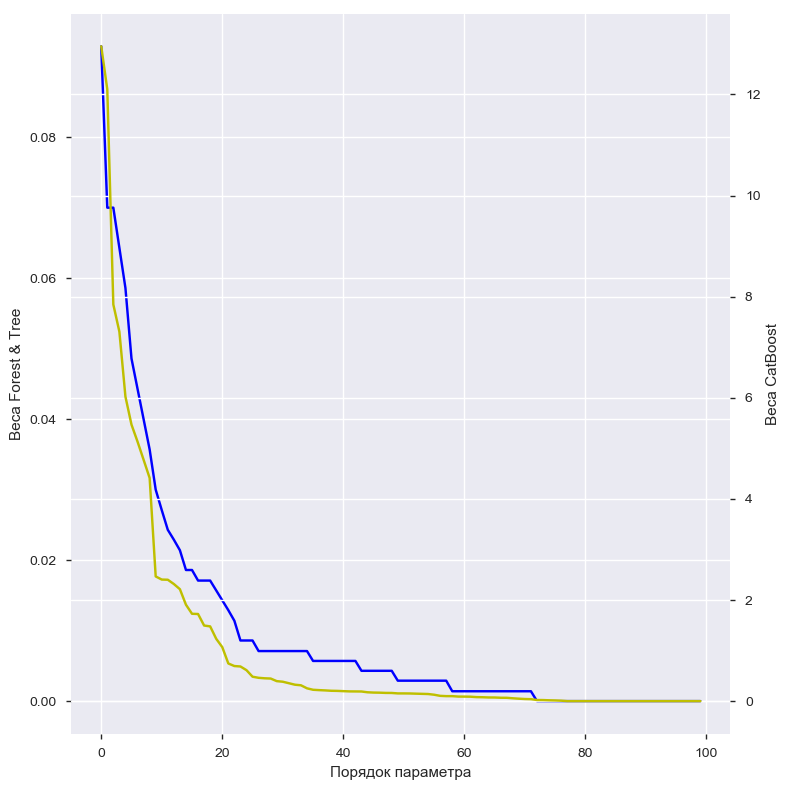

In [17]:
#нарисуем плот, для отражения весов

fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('Порядок параметра')
ax1.set_ylabel('Веса Forest & Tree')

#ось 1
ax1.plot([v for v,m in xgb_results][:100], 'b')
    
#добавим вторую ось, так как веса у CatBoost отличаются (или разделить их на 100, чтобы не отличались)
#но вторая ось - красиво !!!!!!!
ax2 = ax1.twinx()  #добавление оси

ax2.set_ylabel('Веса CatBoost') 
ax2.plot([v for v,m in cat_results][:100], 'y')
fig.tight_layout() 
plt.show()

In [18]:
#найдем только те переменные, которые имеют вхождение во все модели

#есть два способа: 1.через словарь (я его буду использовать), 2.через map-reduce
res_dict = dict()
for i in range(80):
    for mod in ([m for v,m in xgb_results],
                [m for v,m in cat_results]):
        if mod[i] in res_dict:
            res_dict[mod[i]] += 1
        else:
            res_dict[mod[i]] = 1

#сортировка результата
resulted = sorted(zip(map(lambda x: x, res_dict.values()), res_dict.keys()), reverse=True)
resulted[:10]

[(2, 'woy'),
 (2, 'type_t'),
 (2, 'std_up_5_d'),
 (2, 'std_up_30_d'),
 (2, 'std_up_25_d'),
 (2, 'std_up_20_d'),
 (2, 'std_up_10_d'),
 (2, 'sm_up_5_d'),
 (2, 'sm_up_30_d'),
 (2, 'sm_up_25_d')]

In [19]:
#Теперь оставим только те, которые имеют вхождения больше 1
for_use_vars = [k for v,k in resulted]
print("В выборке: ", len(for_use_vars))

В выборке:  92


In [20]:
#из тех, которые выбраны, пройдем по параметрам и откинем нулевые
zeros = []
for k in [k for v,k in resulted]:
    for model in (xgb_results, cat_results):
        if k in [m for v,m in model][:100]:
            if [v for v,m in model][list([m for v,m in model][:100]).index(k)] == 0:
                zeros.append(k)
print("В выборке: ", len(zeros))

В выборке:  23


In [21]:
#Отлично, теперь получим небходимое количество переменных
must_use = set(for_use_vars) - set(zeros)
print("Уже более подходящее число: ", len(must_use))

Уже более подходящее число:  76


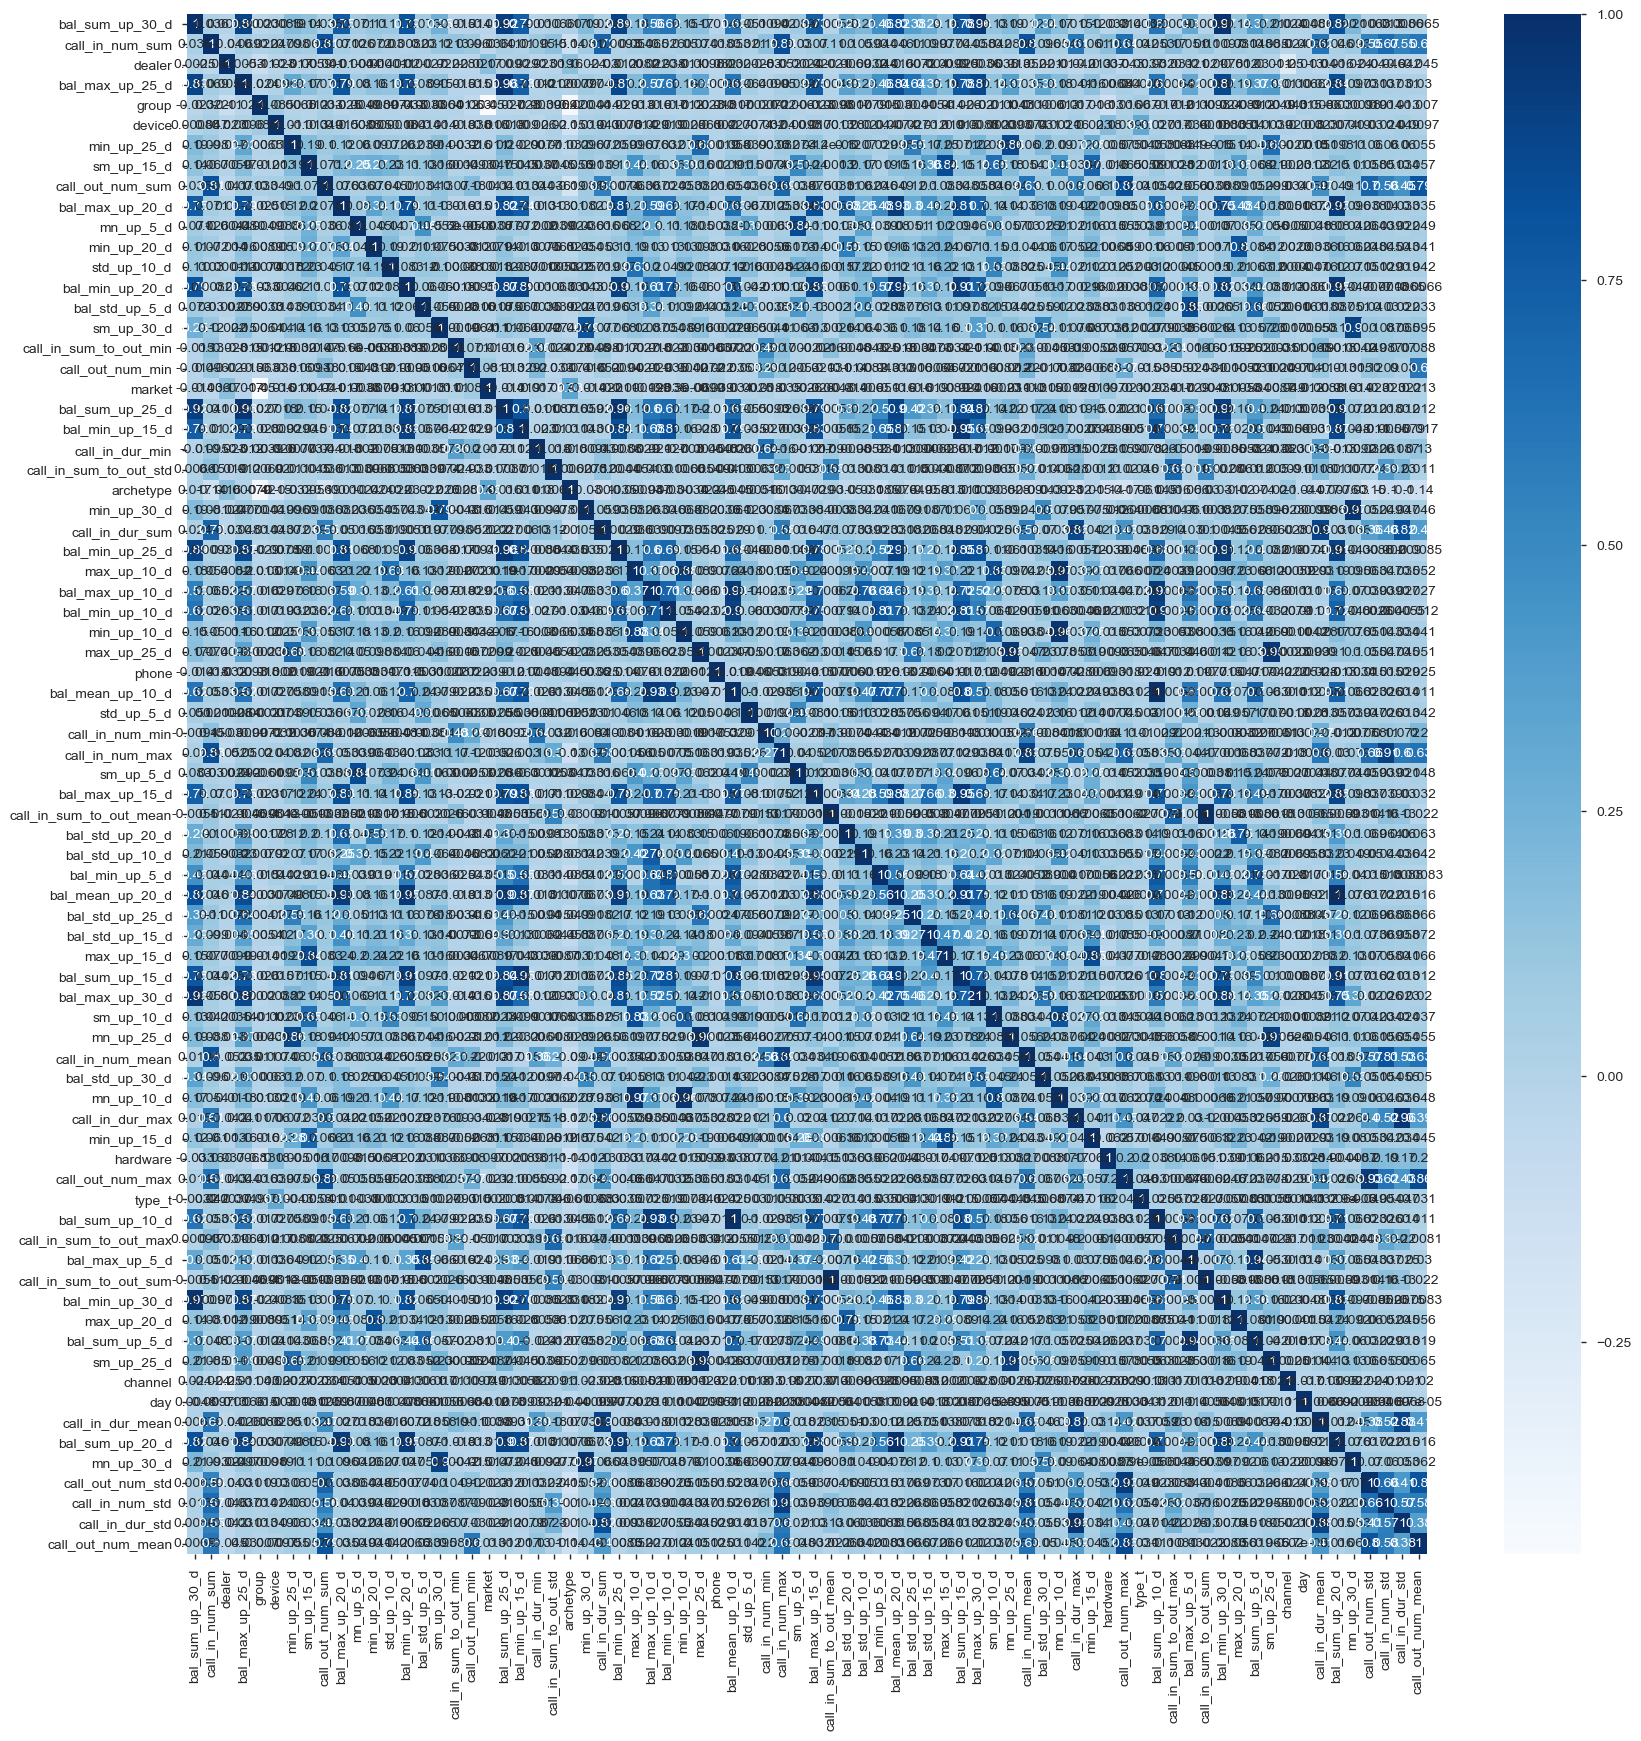

In [22]:
plt.figure(figsize=(20,20))

sns.heatmap(X[X.columns[[list(X.columns).index(m) for m in must_use]]].corr(), annot = True, cmap='Blues')

In [23]:
#Видно, что много корреляций
#Сделаем обзор списком и установим размер допустимой корреляции в 0.8
#остальные коррелирующие значения сольём

pd.options.display.max_rows = 1500
corrs = X[X.columns[[list(X.columns).index(m) for m in must_use]]].corr().abs().unstack().sort_values(kind="quicksort").sort_values(ascending=False).reset_index()
corrs.columns = ['val1', 'val2', 'coef']

#удалим признакии высокой корреляции и построим таблицу
high_corr = list()
for row in range(corrs.shape[0]):
    if (corrs.iloc[row][0] != corrs.iloc[row][1]) and corrs.iloc[row][2] >= 0.7 :
        high_corr.append(list(must_use)[list(must_use).index(corrs.iloc[row][1])])
must_use = must_use - set(high_corr)

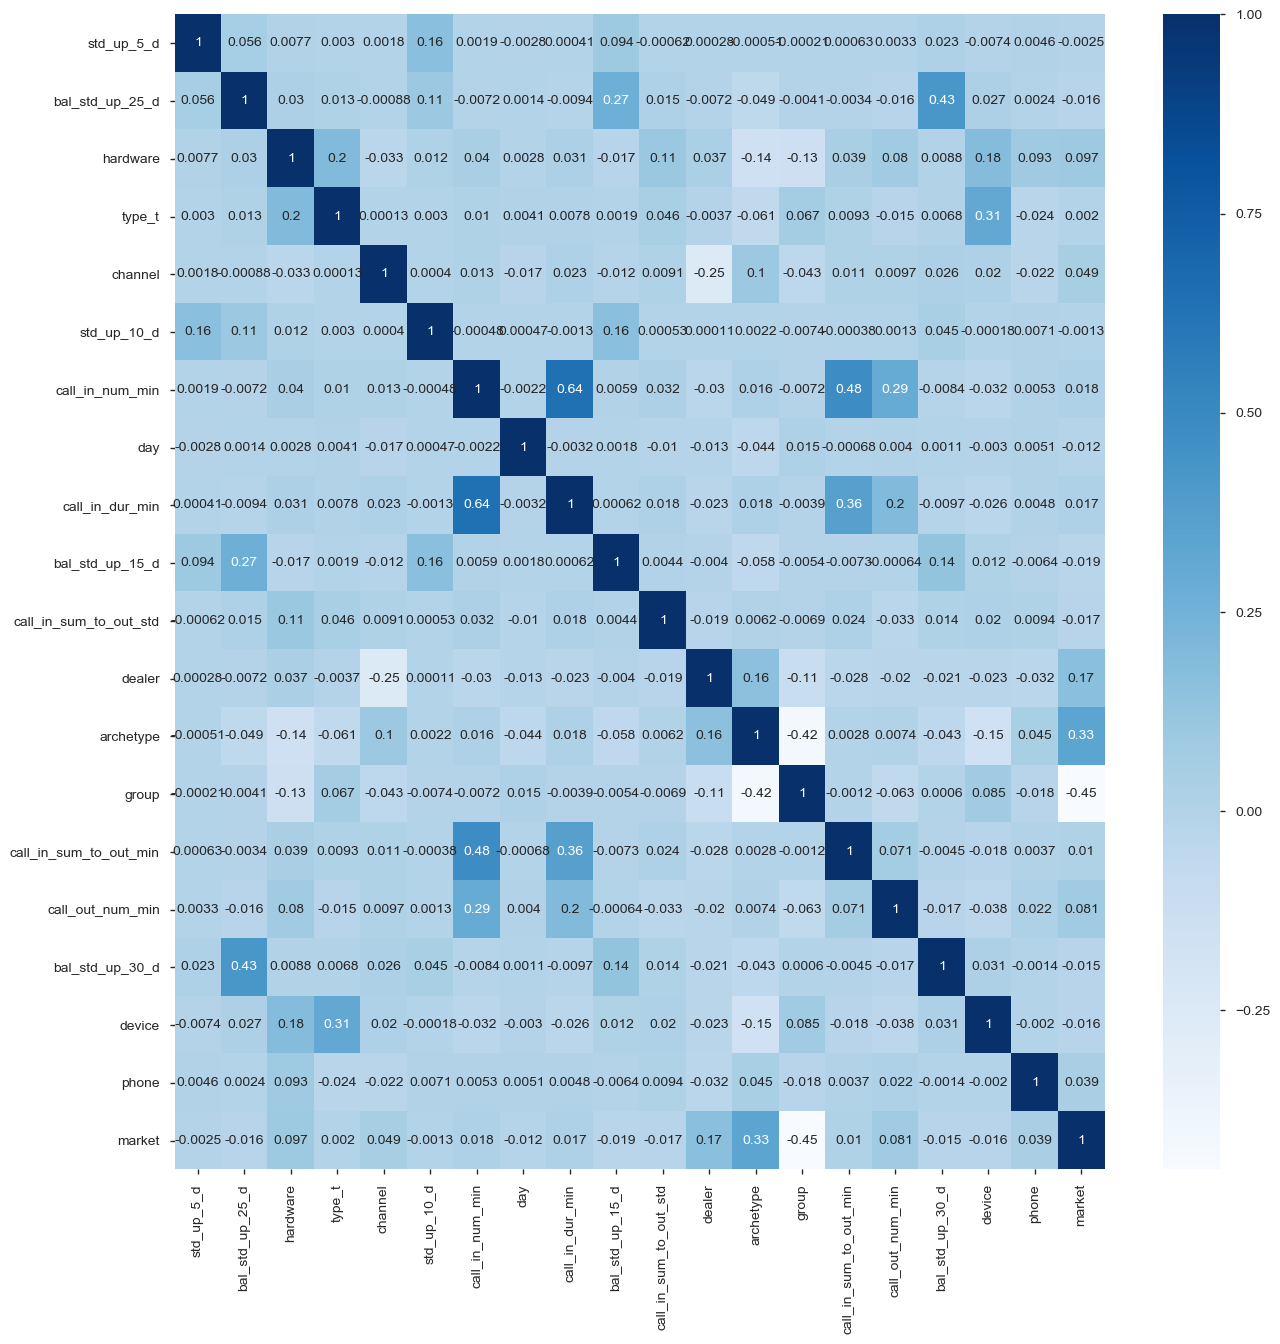

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(X[X.columns[[list(X.columns).index(m) for m in must_use]]].corr(), annot = True, cmap='Blues')

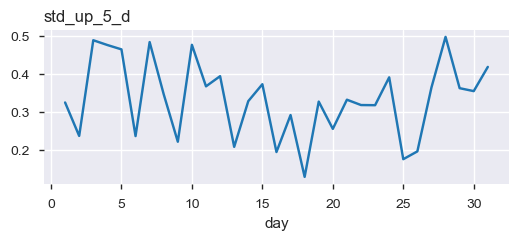

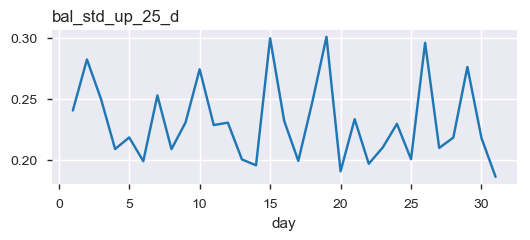

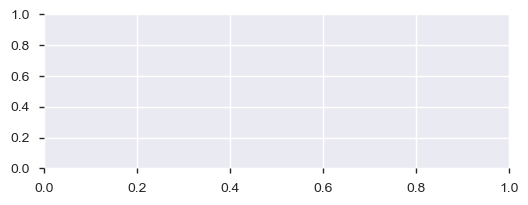

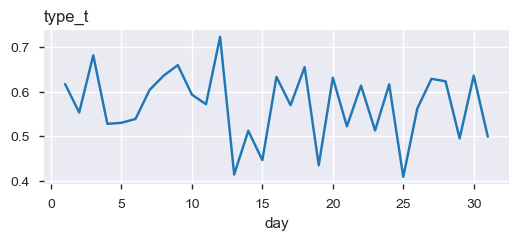

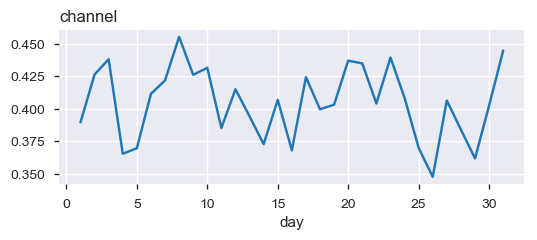

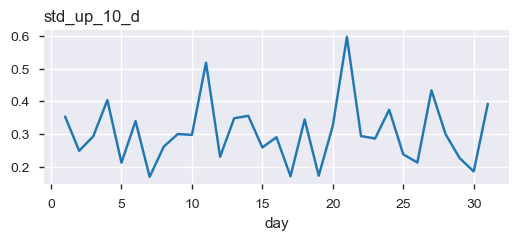

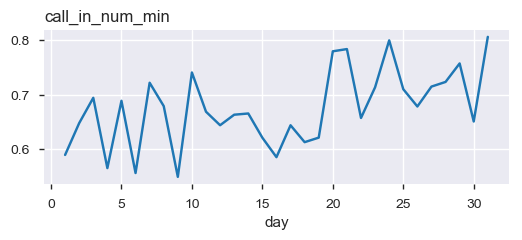

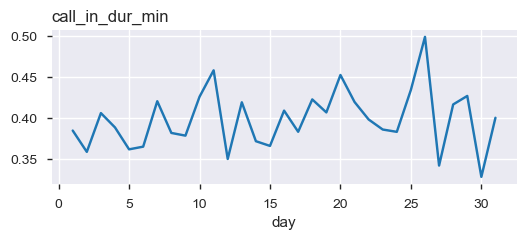

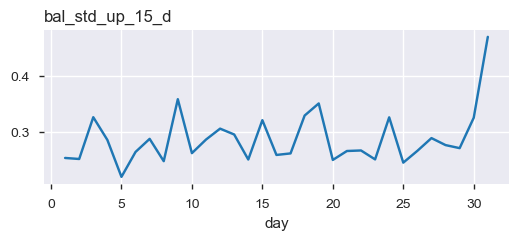

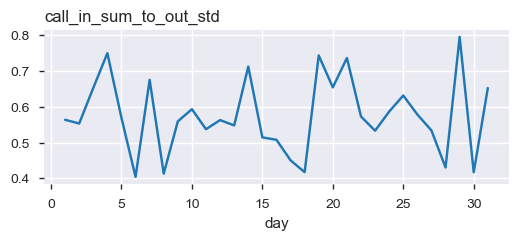

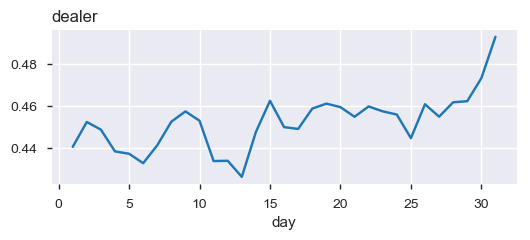

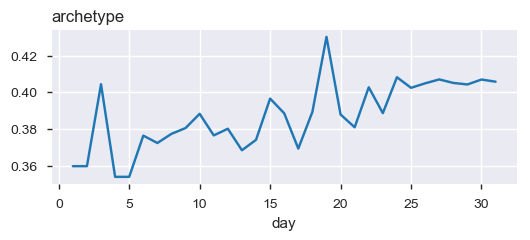

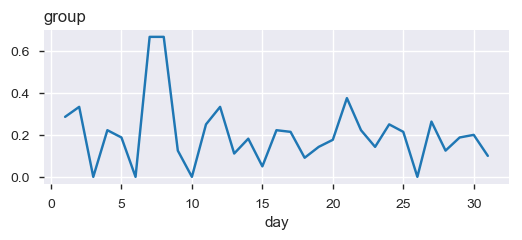

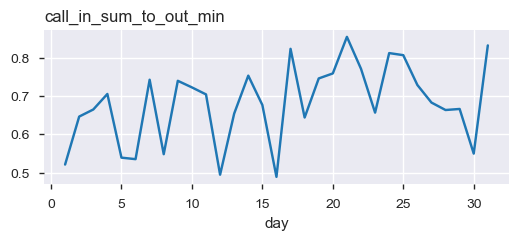

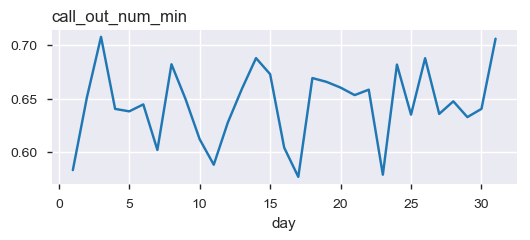

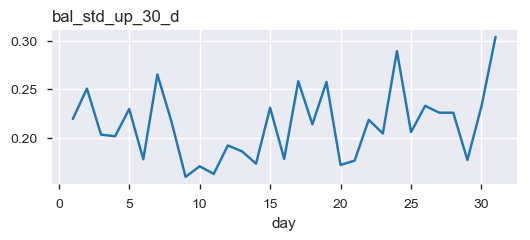

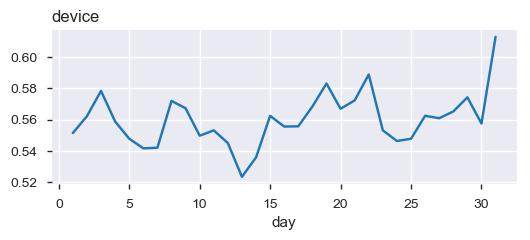

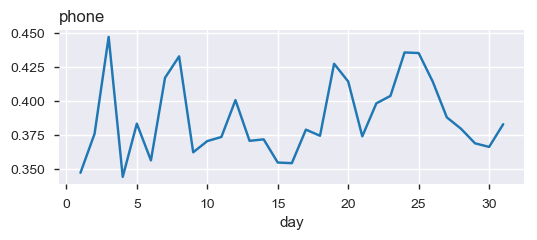

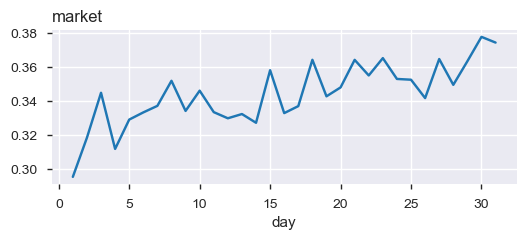

In [25]:
# итог
#!Отлично
#Посмотрим, как отражается целевая переменная в каждом значении
res_x = X[X.columns[[list(X.columns).index(m) for m in must_use]]]
res_xy = pd.concat([res_x, Y], axis =1)

for col in res_x.columns:
    if col != 'day':
        plt.figure(figsize=(6,2))

        #посчитаем количество необходимых подгрупп, по формуле 1 + 1.44 * ln(x)
        bins = int(1 + 1.44 * np.log(len(res_xy[col])))

        d = pd.DataFrame(res_xy.groupby(['day', pd.cut(res_xy[col], 
                                        bins = range(bins))])['churn'].mean()).reset_index()
        #опустим ошибку распределения по не numirical типу
        try:
            d.groupby('day')['churn'].mean().plot()
            plt.title(col, loc='left', fontsize=12, fontweight=0 )
        except TypeError:
            pass


## Основные функции для наших моделей

##### Комплект функций уменьшающий вес набора данных! Нужно при больших данных

In [70]:

def mem_usage(obj):
    """    
    input: pd.DataFrame | pd.Series
    
    return: sting
    """
    #если DataFrame
    if isinstance(obj, pd.DataFrame):
        usage_b = obj.memory_usage(deep = True).sum()
    #если Series
    else:
        usage_b = obj.memory_usage(deep = True)
    usage_mb = usage_b / 1024 ** 2 # в МБ
    return "{:03.2f} MB".format(usage_mb)


def replace_cat(obj, float_cols, min_value=0.001, features=None):
    """
    Объекты в категории
    
    input: pd.DataFrame | pd.Series
    input: hasattr(features, '__iter__')
    input: .0 =< min_value >= 1.
    
    return pd.DataFrame | pd.Series
    """
    #только с DataFrame
    if isinstance(obj, pd.DataFrame):
        converted_obj = pd.DataFrame()
        if not features: features = obj.columns
        #обзор колонок
        for col in features:
            if col not in float_cols:
                num_unique_values = len(obj[col].unique())
                num_total_values = len(obj[col])
                #если % меньше
                if num_unique_values / num_total_values < min_value:
                    converted_obj.loc[:,col] = obj[col].astype('category')
                else:
                    converted_obj.loc[:,col] = obj[col]
            else:
                converted_obj.loc[:,col] = obj[col]
                
        return converted_obj
    #если Series
    else:
        if col not in float_cols:
            num_unique_values = len(obj[col].unique())
            num_total_values = len(obj[col])
            #если % меньше
            if num_unique_values / num_total_values < min_value:
                return obj[col].astype('category')
            else:
                return obj[col]
        
        
def as_dict(frame):
    """
    перевод в словарь
    
    input: pd.DataFrame
    
    return dictionary
    """
    #процесс образования словаря
    dtypes = frame.dtypes
    dtypes_col = dtypes.index
    dtypes_type = [i.name for i in dtypes.values]
    column_types = dict(zip(dtypes_col, dtypes_type))
    return {key:value for key,value in list(column_types.items())}


def weight_reducer(frame, min_value=0.001, get_dict = None):
    """
    Основная функция редьюсера
    
    input: pd.DataFrame
    input: .0 =< min_value >= 1.
    input: get_dict == bool
    
    return pd.DataFrame  
    """
    #если это Frame
    if isinstance(frame, pd.DataFrame):
        before = mem_usage(frame)
        float_cols = []
        for dtype in set(frame.dtypes):
            if 'float' in str(dtype):
                cols = frame[[col for col in frame.columns if 'float' in str(frame[col].dtypes)]].select_dtypes(include = [dtype]).columns
                frame[cols] = frame[cols].select_dtypes(include = [dtype]). \
                              apply(pd.to_numeric, downcast='float')
                float_cols = cols
            if 'int' in str(dtype): 
                cols = frame[[col for col in frame.columns if 'int' in str(frame[col].dtypes)]].select_dtypes(include = [dtype]).columns
                frame[cols] = frame[cols].select_dtypes(include = [dtype]).\
                              apply(pd.to_numeric, downcast='unsigned')
            frame = replace_cat(frame, float_cols, min_value)
        after = mem_usage(frame)
        print('Columns - {}, early size - {}, replaced size - {}'.format(frame.shape[1], before, after))
        if get_dict: frame = as_dict(frame)
        return frame

#### Простые фит функции

In [71]:
def xgbfit(alg, train, test, y_train, y_test, useTrainCV=True, cv_folds=3, early_stopping_rounds=100):
    '''
    Для XGBoost
    '''
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data = train.values, label=y_train, feature_names=train.columns)
        xgtest = xgb.DMatrix(data = test.values, label=y_test, feature_names=train.columns)
        cvresult = xgb.cv(xgb_param, \
                          xgtrain, \
                          num_boost_round=alg.get_params()['n_estimators'], \
                          nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, \
                          show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(train.values, y_train, eval_metric='auc')   
    dtrain_predictions = alg.predict(test.values)
    dtrain_predprob = alg.predict_proba(test.values)[:,1]
        
    print("==========> TRAIN & CV <===============")
    print ('{} roc_auc '.format(roc_auc_score(y_test.values, dtrain_predprob)))
    
    return alg




def catfit(alg, train, test, y_train, y_test, useTrainCV=True, cv_folds=3):
    '''
    Для CatBoost
    '''
    if useTrainCV:  
        ctb_param = alg.get_params()
        cttrain = ctb.Pool(data = train.values, label=y_train, feature_names=list(train.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cttest = ctb.Pool(data = test.values, label=y_test, feature_names=list(train.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cvresult = ctb.cv(cttrain, \
                          ctb_param, \
                          nfold=cv_folds,
                          verbose_eval = 100)
    
    alg.fit(train.values, y_train)
        
    dtrain_predictions = alg.predict(test.values)
    dtrain_predprob = alg.predict_proba(test.values)[:,1]
        
    print("==========> TRAIN & CV <===============")
    print ('{} roc_auc '.format(roc_auc_score(y_test.values, dtrain_predprob)))
    
    return alg

# вы уже придумали, как можно сделать универсально?

#### Nested Validation

In [72]:
def fit_inner(alg, train,test,y_train,y_test, al, cv_folds=3,early_stopping_rounds=100):
    '''
    Общий фиттера, зависимый от параметра AL
    '''
    if al == 'XGB':
        param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data = train.values, label=y_train, feature_names=train.columns)
        xgtest = xgb.DMatrix(data = test.values, label=y_test, feature_names=train.columns)
        cvresult = xgb.cv(param, \
                          xgtrain, \
                          num_boost_round=alg.get_params()['n_estimators'], \
                          nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, \
                          show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        alg.fit(train.values, y_train)
        
    if al == 'Cat':
        param = alg.get_params()
        cttrain = ctb.Pool(data = train.values, label=y_train, feature_names=list(train.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cttest = ctb.Pool(data = test.values, label=y_test, feature_names=list(train.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cvresult = ctb.cv(cttrain, \
                          param, \
                          nfold=cv_folds)
        alg.fit(train.values, y_train)
    
    return alg

def my_product(dicts):
    #формируем набор параметров
    pt = list(itertools.product(*list(dicts.values())))
    print('Count of variances - ', list(itertools.product(*list(dicts.values()))).__len__())
    return [dict(zip(dicts.keys(), p)) for p in pt]


def nested_CV_GS(params, al):
    '''
    Функция вложенной валидации
    и
    автоподбора (тюннига) параметров     
    '''
    
    #списки параметров
    bestModels = []
    bestModelScores = []
    bestModelsOuterparams = []
    topModels = []
    outerCounter = 1
    
    ''' Внутренние оптимизаторы'''
    
    def hyperopt_xgb(param):
        print('Start hyper')
        alg = xgb.XGBClassifier(**param)
        xgb_param = alg.get_xgb_params()
        
        xgtrain = xgb.DMatrix(data = X_train_in.values, label=y_train_in.values, feature_names=X_train_in.columns)
        xgtest = xgb.DMatrix(data = X_test_in.values, label=y_test_in.values, feature_names=X_train_in.columns)
        cvresult = xgb.cv(xgb_param, \
                          xgtrain, \
                          num_boost_round=alg.get_params()['n_estimators'], \
                          nfold=3,\
                          metrics = 'auc', \
                          early_stopping_rounds=10, \
                          show_stdv=False,
                          verbose_eval = 5)
        alg.set_params(n_estimators=cvresult.shape[0])   
        
        eval_set = [(xgtest, 'eval'), (xgtrain, 'train')]
        
        model = xgb.train(alg.get_xgb_params(), 
                          xgtrain, 
                          cvresult.shape[0],
                          evals=eval_set,
                          verbose_eval = 5)
        predictions = model.predict(xgtest,
                                    ntree_limit=model.best_iteration + 1)
        score = roc_auc_score(y_test_in, predictions)
        print('Fit score - ', score, ' and best iter - ', cvresult.shape[0])
        return {'loss': 1- score, 'status': STATUS_OK}
    
    
    def hyperopt_cat(param):
        print('Start hyper')
        alg = ctb.CatBoostClassifier(**param)
        #current_score = cross_val_score(model, X_train_in, y_train_in, cv=3).mean()
        ctb_param = alg.get_params()
        
        cttrain = ctb.Pool(data = X_train_in.values, label=y_train_in.values, feature_names=list(X_train_in.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        cttest = ctb.Pool(data =X_test_in.values, label=y_test_in.values, feature_names=list(X_train_in.columns), cat_features = np.where(X_train_cat.dtypes == 'category')[0])
        
        
        cvresult = ctb.cv(cttrain, \
                          ctb_param, \
                          nfold=3)
        
        model = alg.fit( cttrain, eval_set= cttest,
                          verbose_eval = 5)
        predictions = model.predict(cttest)
        score = roc_auc_score(y_test_in, predictions)
        print('Fit score - ', score)
        return {'loss': 1- score, 'status': STATUS_OK}
    
    #основной цикл
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_in, X_test_in = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_in, y_test_in = y_train.iloc[train_index], y_train.iloc[test_index]

        skfInner = KFold(n_splits=3)
        skf.get_n_splits(X_train_in, y_train_in)

        tempModels = []
        scores = []
        innerCounter = 1
        
        #вложенный поиск параметров
        if al == 'XGB':
            best = fmin(fn=hyperopt_xgb, space=params, algo=tpe.suggest, max_evals=2)
            
            #print(space_eval(params, best)) 
            
            alg = xgb.XGBClassifier(**space_eval(params, best))
        if al == 'Cat':
            
            best = fmin(fn=hyperopt_cat, space=params, algo=tpe.suggest, max_evals=2)
                            
            #print(space_eval(params, best))
            
            alg = ctb.CatBoostClassifier(**space_eval(params, best))
        #print('best:')
        #print(best)
        
        alg = fit_inner(alg, X_train_in, X_test_in, y_train_in, y_test_in, al)
        
        predictions = alg.predict( X_test_in.values)
        score = roc_auc_score(y_test_in, predictions)

        bestModelsOuterparams.append(best)
        bestModelScores.append(score)
        topModels.append(alg)
        print ('Finished Fold', outerCounter, 'Score:', score)
        outerCounter+=1
    print(max(bestModelScores))
    avgBestModelScores = float(sum(bestModelScores))/len(bestModelScores)
    
    print(avgBestModelScores)
    
    return topModels[bestModelScores.index(max(bestModelScores))],  bestModelsOuterparams[bestModelScores.index(max(bestModelScores))]
 

###  Обучение

In [59]:
#### Пересобираем X|Y с нужными переменными
need_vars = list(X.columns[[list(X.columns).index(m) for m in must_use]])
need_vars.append('woy')

X_test = mn_df[(mn_df['month'] == 5) & (mn_df['day'] > 13)] #задан по условию
Y_test = mn_df[(mn_df['month'] == 5) & (mn_df['day'] > 13)]['churn']


#X|Y train
X_train = mn_df[~mn_df.client_id.isin(X_test.client_id)]
Y = X_train['churn']

#для XGB
X_test_xgb = X_test[need_vars]
X_train_xgb = X_train[need_vars]

#для Сat
X_test_cat = weight_reducer(X_test[need_vars])
X_train_cat = weight_reducer(X_train[need_vars])




Columns - 21, early size - 12.57 MB, replaced size - 4.86 MB
Columns - 21, early size - 27.71 MB, replaced size - 10.71 MB


#####  + использования категорий, это меньший объем дата сета, при тех же данных

In [30]:
print('Сравним объем занимаемой памяти')
print('XGB - ', mem_usage(X_test_xgb))
print('Cat - ', mem_usage(X_test_cat))

Сравним объем занимаемой памяти
XGB -  12.57 MB
Cat -  1.15 MB


In [31]:
'''Для построения пространства в основном используется либо набор возможных значений (hp.choice) 
либо отрезок в пространстве R hp.quniform(label, low, high, q), где q округление.'''

#параметры для подбора

params_xgb = {'n_estimators': hp.choice('n_estimators', np.arange(200, 1000, 200, dtype = int)),
              'learning_rate': hp.uniform('learning_rate', 0.001, 0.1 ),
              'max_depth': hp.choice('max_depth', np.arange(6, 10, 4, dtype = int)),
              'min_child_weight':hp.choice('min_child_weight',np.arange(1, 10, 1, dtype = int)),
              'min_split_loss': hp.choice('min_split_loss',np.arange(1, 7, 1, dtype = int)),
              'max_delta_step': hp.choice('max_delta_step',np.arange(1, 7, 1, dtype = int)),
              'subsample' : 0.9, 
              'colsample_bytree': hp.uniform('colsample_bytree',0.1, 0.9),
              'lambda': hp.choice('lambda',np.arange(1, 5, 1, dtype = int)),
              'nthread' : -1,
              'verbosity': 0,  
              'seed': 28}

params_ctb = {'n_estimators':  hp.choice('n_estimators', np.arange(200, 1000, 200, dtype = int)),
              'learning_rate': hp.uniform('learning_rate', 0.0001, 0.1 ),
              'max_depth': hp.choice('max_depth', np.arange(6, 10, 4, dtype = int)),
              'l2_leaf_reg' : hp.choice('l2_leaf_reg',np.arange(3, 7, 2, dtype = int)),
              'bagging_temperature':  hp.choice('bagging_temperature',np.arange(0, 10, 1, dtype = int)),
              'random_strength' : hp.uniform('random_strength', 0.001, 0.9 ) }

###  Обучим

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_train_xgb, Y, test_size = 0.3)

alg_xgb = xgb.XGBClassifier(n_estimators=100)   # А какие параметры?
xgb_alg = xgbfit(alg_xgb, x_train, x_test, y_train, y_test)

==========> TRAIN & CV <===============
0.8223684349681711 roc_auc 


In [33]:
x_train, x_test, y_train, y_test = train_test_split(X_train_cat, Y, test_size = 0.3)

alg_ctb = ctb.CatBoostClassifier(n_estimators=100)    # А какие параметры?
cat_alg = catfit(alg_ctb, x_train, x_test, y_train, y_test)

0:	learn: 0.6890774	test: 0.6890775	best: 0.6890775 (0)	total: 714ms	remaining: 1m 10s
0:	learn: 0.6891592	total: 47.7ms	remaining: 4.72s
1:	learn: 0.6853635	total: 106ms	remaining: 5.21s
2:	learn: 0.6818191	total: 176ms	remaining: 5.69s
3:	learn: 0.6784942	total: 232ms	remaining: 5.57s
4:	learn: 0.6753450	total: 292ms	remaining: 5.54s
5:	learn: 0.6724041	total: 348ms	remaining: 5.45s
6:	learn: 0.6696479	total: 408ms	remaining: 5.42s
7:	learn: 0.6670626	total: 460ms	remaining: 5.29s
8:	learn: 0.6646077	total: 515ms	remaining: 5.21s
9:	learn: 0.6623263	total: 570ms	remaining: 5.13s
10:	learn: 0.6601682	total: 631ms	remaining: 5.11s
11:	learn: 0.6581526	total: 689ms	remaining: 5.05s
12:	learn: 0.6562179	total: 744ms	remaining: 4.98s
13:	learn: 0.6544338	total: 813ms	remaining: 4.99s
14:	learn: 0.6526858	total: 865ms	remaining: 4.9s
15:	learn: 0.6510886	total: 923ms	remaining: 4.85s
16:	learn: 0.6495356	total: 974ms	remaining: 4.75s
17:	learn: 0.6481417	total: 1.04s	remaining: 4.73s
18:	l

### Nested XGB

In [39]:
#xgb
#train model
X_train, X_test, y_train, y_test = train_test_split(X_train_xgb, Y, test_size =0.3, random_state = 28)



skf = KFold(n_splits=3)
skf.get_n_splits(X_train, y_train)

t0 = time.time()
alg_xgb, best_params_xgb = nested_CV_GS(params_xgb, al = 'XGB')
t1 = time.time()
print ('function took', round(float(t1-t0)/60, 2), 'mins')

Start hyper                                                                    
[0]	train-auc:0.620619	test-auc:0.618424                                       

[5]	train-auc:0.786352	test-auc:0.781212                                       

[10]	train-auc:0.787692	test-auc:0.781504                                      

[15]	train-auc:0.800936	test-auc:0.794709                                      

[20]	train-auc:0.803362	test-auc:0.797246                                      

[25]	train-auc:0.803843	test-auc:0.797412                                      

[30]	train-auc:0.805242	test-auc:0.799057                                      

[35]	train-auc:0.807063	test-auc:0.800996                                      

[40]	train-auc:0.808811	test-auc:0.80268                                       

[45]	train-auc:0.809804	test-auc:0.803535                                      

[50]	train-auc:0.810593	test-auc:0.804168                                      

[55]	train-auc:0.81234	test-a

[95]	eval-error:0.248624	train-error:0.244163                                  

[100]	eval-error:0.247378	train-error:0.243059                                 

[105]	eval-error:0.246703	train-error:0.242579                                 

[110]	eval-error:0.246574	train-error:0.242255                                 

[115]	eval-error:0.246755	train-error:0.242242                                 

[120]	eval-error:0.246444	train-error:0.241813                                 

[125]	eval-error:0.245951	train-error:0.241541                                 

[130]	eval-error:0.245483	train-error:0.241048                                 

[135]	eval-error:0.245172	train-error:0.24097                                  

[140]	eval-error:0.244627	train-error:0.240009                                 

[145]	eval-error:0.244575	train-error:0.239607                                 

[150]	eval-error:0.244341	train-error:0.239477                                 

[155]	eval-error:0.2439	trai

[70]	train-auc:0.827598	test-auc:0.819922                                      

[75]	train-auc:0.828254	test-auc:0.82028                                       

[80]	train-auc:0.828908	test-auc:0.820719                                      

[85]	train-auc:0.82965	test-auc:0.821127                                       

[90]	train-auc:0.830195	test-auc:0.821462                                      

[95]	train-auc:0.830752	test-auc:0.821804                                      

[100]	train-auc:0.831346	test-auc:0.822154                                     

[105]	train-auc:0.831847	test-auc:0.8224                                       

[110]	train-auc:0.832366	test-auc:0.822715                                     

[115]	train-auc:0.832786	test-auc:0.822898                                     

[120]	train-auc:0.833272	test-auc:0.823133                                     

[125]	train-auc:0.833692	test-auc:0.823369                                     

[130]	train-auc:0.834024	tes

[170]	eval-error:0.237618	train-error:0.230522                                 

[175]	eval-error:0.237488	train-error:0.230444                                 

[180]	eval-error:0.237333	train-error:0.230379                                 

[185]	eval-error:0.237177	train-error:0.229938                                 

[190]	eval-error:0.237307	train-error:0.229847                                 

[195]	eval-error:0.236995	train-error:0.229769                                 

[200]	eval-error:0.236891	train-error:0.2296                                   

[205]	eval-error:0.236917	train-error:0.229561                                 

[210]	eval-error:0.236813	train-error:0.229574                                 

[215]	eval-error:0.236891	train-error:0.229444                                 

[220]	eval-error:0.236865	train-error:0.229457                                 

[225]	eval-error:0.236606	train-error:0.229029                                 

[230]	eval-error:0.236632	tr

[90]	eval-error:0.236346	train-error:0.227017                                  

[95]	eval-error:0.236476	train-error:0.226745                                  

[100]	eval-error:0.236736	train-error:0.226239                                 

[105]	eval-error:0.237021	train-error:0.225979                                 

[110]	eval-error:0.236891	train-error:0.225226                                 

[115]	eval-error:0.237125	train-error:0.225161                                 

[120]	eval-error:0.236813	train-error:0.224772                                 

[125]	eval-error:0.236632	train-error:0.224408                                 

[130]	eval-error:0.23658	train-error:0.224175                                  

[135]	eval-error:0.236424	train-error:0.224097                                 

[140]	eval-error:0.23671	train-error:0.223617                                  

[145]	eval-error:0.236424	train-error:0.223435                                 

Fit score -                 

[410]	train-auc:0.842967	test-auc:0.823029                                     

[415]	train-auc:0.843117	test-auc:0.823062                                     

[420]	train-auc:0.843274	test-auc:0.82307                                      

[425]	train-auc:0.843386	test-auc:0.823074                                     

[430]	train-auc:0.843497	test-auc:0.823097                                     

[435]	train-auc:0.843626	test-auc:0.823119                                     

[440]	train-auc:0.843767	test-auc:0.823123                                     

[445]	train-auc:0.843865	test-auc:0.823127                                     

[450]	train-auc:0.844019	test-auc:0.823134                                     

[455]	train-auc:0.844133	test-auc:0.823148                                     

[460]	train-auc:0.844302	test-auc:0.823185                                     

[465]	train-auc:0.844454	test-auc:0.82319                                      

[470]	train-auc:0.84462	test

[335]	eval-error:0.234328	train-error:0.228896                                 

[340]	eval-error:0.234328	train-error:0.22887                                  

[345]	eval-error:0.234431	train-error:0.228779                                 

[350]	eval-error:0.234509	train-error:0.228598                                 

[355]	eval-error:0.234379	train-error:0.228403                                 

[360]	eval-error:0.234431	train-error:0.228377                                 

[365]	eval-error:0.234457	train-error:0.228325                                 

[370]	eval-error:0.234328	train-error:0.22826                                  

[375]	eval-error:0.23425	train-error:0.228169                                  

[380]	eval-error:0.234224	train-error:0.228105                                 

[385]	eval-error:0.234302	train-error:0.228053                                 

[390]	eval-error:0.234172	train-error:0.227975                                 

[395]	eval-error:0.234224	tr

[240]	train-auc:0.836809	test-auc:0.822065                                     

[245]	train-auc:0.836999	test-auc:0.822125                                     

[250]	train-auc:0.837222	test-auc:0.822134                                     

[255]	train-auc:0.837411	test-auc:0.822151                                     

[260]	train-auc:0.837595	test-auc:0.822176                                     

[265]	train-auc:0.837756	test-auc:0.822221                                     

[270]	train-auc:0.837892	test-auc:0.822245                                     

[275]	train-auc:0.838002	test-auc:0.822252                                     

[280]	train-auc:0.838172	test-auc:0.822253                                     

[285]	train-auc:0.838288	test-auc:0.822259                                     

[290]	train-auc:0.838409	test-auc:0.822286                                     

[295]	train-auc:0.838563	test-auc:0.822334                                     

[300]	train-auc:0.838682	tes

In [73]:
#cat
#train model
X_train, X_test, y_train, y_test = train_test_split(X_train_cat, Y,test_size =0.3, random_state = 28)


#unchangable params
outerK = 3
innerK = 3
early_stopping_rounds = 100
eval_metric = 'auc'

#
skf = KFold(n_splits=outerK)
skf.get_n_splits(X_train, y_train)

t0 = time.time()
t0 = time.time()
alg_cat, best_params_cat = nested_CV_GS(params_ctb, al = 'Cat')
t1 = time.time()
print ('function took', round(float(t1-t0)/60, 2), 'mins')

Start hyper                                                                    
0:	learn: 0.6740721	test: 0.6741253	best: 0.6741253 (0)	total: 705ms	remaining: 4m 41s

1:	learn: 0.6579561	test: 0.6580063	best: 0.6580063 (1)	total: 1.39s	remaining: 4m 36s

2:	learn: 0.6434477	test: 0.6435989	best: 0.6435989 (2)	total: 2.07s	remaining: 4m 34s

3:	learn: 0.6299915	test: 0.6301874	best: 0.6301874 (3)	total: 2.74s	remaining: 4m 31s

4:	learn: 0.6181596	test: 0.6183590	best: 0.6183590 (4)	total: 3.42s	remaining: 4m 30s

5:	learn: 0.6082250	test: 0.6084824	best: 0.6084824 (5)	total: 4.04s	remaining: 4m 24s

6:	learn: 0.5989195	test: 0.5992447	best: 0.5992447 (6)	total: 4.69s	remaining: 4m 23s

7:	learn: 0.5908185	test: 0.5911784	best: 0.5911784 (7)	total: 5.33s	remaining: 4m 21s

8:	learn: 0.5834178	test: 0.5838006	best: 0.5838006 (8)	total: 5.96s	remaining: 4m 18s

9:	learn: 0.5771054	test: 0.5775186	best: 0.5775186 (9)	total: 6.59s	remaining: 4m 17s

10:	learn: 0.5715561	test: 0.5720480	bes

90:	learn: 0.5059088	test: 0.5097249	best: 0.5097249 (90)	total: 1m	remaining: 3m 25s

91:	learn: 0.5057710	test: 0.5096258	best: 0.5096258 (91)	total: 1m 1s	remaining: 3m 24s

92:	learn: 0.5056631	test: 0.5095731	best: 0.5095731 (92)	total: 1m 1s	remaining: 3m 24s

93:	learn: 0.5055359	test: 0.5094685	best: 0.5094685 (93)	total: 1m 2s	remaining: 3m 23s

94:	learn: 0.5053777	test: 0.5093648	best: 0.5093648 (94)	total: 1m 3s	remaining: 3m 23s

95:	learn: 0.5052598	test: 0.5092845	best: 0.5092845 (95)	total: 1m 3s	remaining: 3m 22s

96:	learn: 0.5051072	test: 0.5091970	best: 0.5091970 (96)	total: 1m 4s	remaining: 3m 21s

97:	learn: 0.5050055	test: 0.5091317	best: 0.5091317 (97)	total: 1m 5s	remaining: 3m 20s

98:	learn: 0.5049044	test: 0.5090697	best: 0.5090697 (98)	total: 1m 5s	remaining: 3m 20s

99:	learn: 0.5048232	test: 0.5090309	best: 0.5090309 (99)	total: 1m 6s	remaining: 3m 19s

100:	learn: 0.5046939	test: 0.5089801	best: 0.5089801 (100)	total: 1m 7s	remaining: 3m 18s

101:	learn:

178:	learn: 0.4986213	test: 0.5057690	best: 0.5057690 (178)	total: 1m 59s	remaining: 2m 27s

179:	learn: 0.4985690	test: 0.5057552	best: 0.5057552 (179)	total: 1m 59s	remaining: 2m 26s

180:	learn: 0.4984970	test: 0.5057238	best: 0.5057238 (180)	total: 2m	remaining: 2m 25s

181:	learn: 0.4984432	test: 0.5057008	best: 0.5057008 (181)	total: 2m 1s	remaining: 2m 25s

182:	learn: 0.4984216	test: 0.5057052	best: 0.5057008 (181)	total: 2m 2s	remaining: 2m 24s

183:	learn: 0.4983437	test: 0.5056621	best: 0.5056621 (183)	total: 2m 2s	remaining: 2m 24s

184:	learn: 0.4982545	test: 0.5056265	best: 0.5056265 (184)	total: 2m 3s	remaining: 2m 23s

185:	learn: 0.4981877	test: 0.5056003	best: 0.5056003 (185)	total: 2m 4s	remaining: 2m 22s

186:	learn: 0.4981222	test: 0.5055688	best: 0.5055688 (186)	total: 2m 4s	remaining: 2m 22s

187:	learn: 0.4980566	test: 0.5055370	best: 0.5055370 (187)	total: 2m 5s	remaining: 2m 21s

188:	learn: 0.4979747	test: 0.5055052	best: 0.5055052 (188)	total: 2m 6s	remainin

266:	learn: 0.4935366	test: 0.5037618	best: 0.5037618 (266)	total: 2m 58s	remaining: 1m 28s

267:	learn: 0.4935027	test: 0.5037573	best: 0.5037573 (267)	total: 2m 58s	remaining: 1m 28s

268:	learn: 0.4934467	test: 0.5037306	best: 0.5037306 (268)	total: 2m 59s	remaining: 1m 27s

269:	learn: 0.4934020	test: 0.5037177	best: 0.5037177 (269)	total: 3m	remaining: 1m 26s

270:	learn: 0.4933430	test: 0.5036971	best: 0.5036971 (270)	total: 3m	remaining: 1m 26s

271:	learn: 0.4932907	test: 0.5036897	best: 0.5036897 (271)	total: 3m 1s	remaining: 1m 25s

272:	learn: 0.4932468	test: 0.5036843	best: 0.5036843 (272)	total: 3m 1s	remaining: 1m 24s

273:	learn: 0.4931853	test: 0.5036669	best: 0.5036669 (273)	total: 3m 2s	remaining: 1m 23s

274:	learn: 0.4931381	test: 0.5036466	best: 0.5036466 (274)	total: 3m 3s	remaining: 1m 23s

275:	learn: 0.4930743	test: 0.5036301	best: 0.5036301 (275)	total: 3m 3s	remaining: 1m 22s

276:	learn: 0.4930005	test: 0.5035954	best: 0.5035954 (276)	total: 3m 4s	remaining:

355:	learn: 0.4892463	test: 0.5024877	best: 0.5024877 (355)	total: 4m	remaining: 29.7s

356:	learn: 0.4892024	test: 0.5024751	best: 0.5024751 (356)	total: 4m	remaining: 29s

357:	learn: 0.4891623	test: 0.5024631	best: 0.5024631 (357)	total: 4m 1s	remaining: 28.3s

358:	learn: 0.4891072	test: 0.5024449	best: 0.5024449 (358)	total: 4m 2s	remaining: 27.7s

359:	learn: 0.4890730	test: 0.5024402	best: 0.5024402 (359)	total: 4m 2s	remaining: 27s

360:	learn: 0.4890298	test: 0.5024284	best: 0.5024284 (360)	total: 4m 3s	remaining: 26.3s

361:	learn: 0.4889727	test: 0.5024014	best: 0.5024014 (361)	total: 4m 4s	remaining: 25.6s

362:	learn: 0.4888975	test: 0.5023729	best: 0.5023729 (362)	total: 4m 4s	remaining: 25s

363:	learn: 0.4888537	test: 0.5023606	best: 0.5023606 (363)	total: 4m 5s	remaining: 24.3s

364:	learn: 0.4888175	test: 0.5023570	best: 0.5023570 (364)	total: 4m 6s	remaining: 23.6s

365:	learn: 0.4887911	test: 0.5023547	best: 0.5023547 (365)	total: 4m 6s	remaining: 22.9s

366:	learn:

225:	learn: 0.5004040	test: 0.5077217	best: 0.5077217 (225)	total: 47.7s	remaining: 36.7s

230:	learn: 0.5001400	test: 0.5075925	best: 0.5075925 (230)	total: 48.7s	remaining: 35.6s

235:	learn: 0.4999094	test: 0.5074521	best: 0.5074521 (235)	total: 49.8s	remaining: 34.6s

240:	learn: 0.4996227	test: 0.5073283	best: 0.5073283 (240)	total: 50.9s	remaining: 33.6s

245:	learn: 0.4994253	test: 0.5072185	best: 0.5072185 (245)	total: 52s	remaining: 32.6s

250:	learn: 0.4991863	test: 0.5070823	best: 0.5070823 (250)	total: 53.1s	remaining: 31.5s

255:	learn: 0.4989820	test: 0.5069996	best: 0.5069996 (255)	total: 54.1s	remaining: 30.4s

260:	learn: 0.4987520	test: 0.5068685	best: 0.5068685 (260)	total: 55.1s	remaining: 29.4s

265:	learn: 0.4986182	test: 0.5068391	best: 0.5068391 (265)	total: 56.2s	remaining: 28.3s

270:	learn: 0.4984113	test: 0.5067449	best: 0.5067449 (270)	total: 57.3s	remaining: 27.3s

275:	learn: 0.4981343	test: 0.5066079	best: 0.5066079 (275)	total: 58.3s	remaining: 26.2s

2

50:	learn: 0.5101721	test: 0.5128926	best: 0.5128926 (50)	total: 33.4s	remaining: 8m 10s

51:	learn: 0.5098308	test: 0.5126402	best: 0.5126402 (51)	total: 34s	remaining: 8m 9s

52:	learn: 0.5095724	test: 0.5124586	best: 0.5124586 (52)	total: 34.7s	remaining: 8m 9s

53:	learn: 0.5093644	test: 0.5123238	best: 0.5123238 (53)	total: 35.4s	remaining: 8m 8s

54:	learn: 0.5091162	test: 0.5120914	best: 0.5120914 (54)	total: 36s	remaining: 8m 8s

55:	learn: 0.5088810	test: 0.5118855	best: 0.5118855 (55)	total: 36.7s	remaining: 8m 7s

56:	learn: 0.5086415	test: 0.5116857	best: 0.5116857 (56)	total: 37.4s	remaining: 8m 7s

57:	learn: 0.5084942	test: 0.5115969	best: 0.5115969 (57)	total: 38s	remaining: 8m 6s

58:	learn: 0.5082560	test: 0.5114462	best: 0.5114462 (58)	total: 38.6s	remaining: 8m 5s

59:	learn: 0.5079948	test: 0.5112279	best: 0.5112279 (59)	total: 39.3s	remaining: 8m 4s

60:	learn: 0.5078571	test: 0.5111533	best: 0.5111533 (60)	total: 40s	remaining: 8m 4s

61:	learn: 0.5076726	test: 0

140:	learn: 0.4981442	test: 0.5056159	best: 0.5056159 (140)	total: 1m 33s	remaining: 7m 18s

141:	learn: 0.4980461	test: 0.5055844	best: 0.5055844 (141)	total: 1m 34s	remaining: 7m 17s

142:	learn: 0.4979583	test: 0.5055645	best: 0.5055645 (142)	total: 1m 35s	remaining: 7m 16s

143:	learn: 0.4978919	test: 0.5055484	best: 0.5055484 (143)	total: 1m 35s	remaining: 7m 16s

144:	learn: 0.4978530	test: 0.5055271	best: 0.5055271 (144)	total: 1m 36s	remaining: 7m 15s

145:	learn: 0.4977986	test: 0.5055004	best: 0.5055004 (145)	total: 1m 37s	remaining: 7m 14s

146:	learn: 0.4977236	test: 0.5054696	best: 0.5054696 (146)	total: 1m 37s	remaining: 7m 14s

147:	learn: 0.4976478	test: 0.5054260	best: 0.5054260 (147)	total: 1m 38s	remaining: 7m 13s

148:	learn: 0.4975613	test: 0.5053917	best: 0.5053917 (148)	total: 1m 38s	remaining: 7m 12s

149:	learn: 0.4974434	test: 0.5053450	best: 0.5053450 (149)	total: 1m 39s	remaining: 7m 11s

150:	learn: 0.4973889	test: 0.5053201	best: 0.5053201 (150)	total: 1m 

228:	learn: 0.4916960	test: 0.5033163	best: 0.5033163 (228)	total: 2m 32s	remaining: 6m 21s

229:	learn: 0.4916219	test: 0.5032738	best: 0.5032738 (229)	total: 2m 33s	remaining: 6m 20s

230:	learn: 0.4915381	test: 0.5032274	best: 0.5032274 (230)	total: 2m 34s	remaining: 6m 19s

231:	learn: 0.4914796	test: 0.5032001	best: 0.5032001 (231)	total: 2m 34s	remaining: 6m 19s

232:	learn: 0.4914336	test: 0.5031915	best: 0.5031915 (232)	total: 2m 35s	remaining: 6m 18s

233:	learn: 0.4913736	test: 0.5031726	best: 0.5031726 (233)	total: 2m 36s	remaining: 6m 17s

234:	learn: 0.4912926	test: 0.5031500	best: 0.5031500 (234)	total: 2m 36s	remaining: 6m 17s

235:	learn: 0.4912181	test: 0.5031308	best: 0.5031308 (235)	total: 2m 37s	remaining: 6m 16s

236:	learn: 0.4911118	test: 0.5030811	best: 0.5030811 (236)	total: 2m 38s	remaining: 6m 15s

237:	learn: 0.4910642	test: 0.5030684	best: 0.5030684 (237)	total: 2m 38s	remaining: 6m 15s

238:	learn: 0.4910041	test: 0.5030628	best: 0.5030628 (238)	total: 2m 

316:	learn: 0.4864922	test: 0.5019998	best: 0.5019998 (316)	total: 3m 33s	remaining: 5m 24s

317:	learn: 0.4864366	test: 0.5019792	best: 0.5019792 (317)	total: 3m 34s	remaining: 5m 24s

318:	learn: 0.4863644	test: 0.5019608	best: 0.5019608 (318)	total: 3m 34s	remaining: 5m 24s

319:	learn: 0.4863276	test: 0.5019696	best: 0.5019608 (318)	total: 3m 35s	remaining: 5m 23s

320:	learn: 0.4862652	test: 0.5019471	best: 0.5019471 (320)	total: 3m 36s	remaining: 5m 23s

321:	learn: 0.4862349	test: 0.5019469	best: 0.5019469 (321)	total: 3m 37s	remaining: 5m 22s

322:	learn: 0.4861836	test: 0.5019229	best: 0.5019229 (322)	total: 3m 38s	remaining: 5m 22s

323:	learn: 0.4861226	test: 0.5019123	best: 0.5019123 (323)	total: 3m 39s	remaining: 5m 21s

324:	learn: 0.4860813	test: 0.5019072	best: 0.5019072 (324)	total: 3m 39s	remaining: 5m 21s

325:	learn: 0.4860266	test: 0.5018882	best: 0.5018882 (325)	total: 3m 40s	remaining: 5m 20s

326:	learn: 0.4859621	test: 0.5018629	best: 0.5018629 (326)	total: 3m 

404:	learn: 0.4819306	test: 0.5010551	best: 0.5010551 (404)	total: 4m 34s	remaining: 4m 27s

405:	learn: 0.4818763	test: 0.5010538	best: 0.5010538 (405)	total: 4m 35s	remaining: 4m 27s

406:	learn: 0.4818163	test: 0.5010416	best: 0.5010416 (406)	total: 4m 36s	remaining: 4m 26s

407:	learn: 0.4817523	test: 0.5010314	best: 0.5010314 (407)	total: 4m 36s	remaining: 4m 25s

408:	learn: 0.4817054	test: 0.5010245	best: 0.5010245 (408)	total: 4m 37s	remaining: 4m 25s

409:	learn: 0.4816629	test: 0.5010186	best: 0.5010186 (409)	total: 4m 38s	remaining: 4m 24s

410:	learn: 0.4816017	test: 0.5010148	best: 0.5010148 (410)	total: 4m 38s	remaining: 4m 23s

411:	learn: 0.4815722	test: 0.5010070	best: 0.5010070 (411)	total: 4m 39s	remaining: 4m 23s

412:	learn: 0.4815304	test: 0.5010051	best: 0.5010051 (412)	total: 4m 40s	remaining: 4m 22s

413:	learn: 0.4814891	test: 0.5010042	best: 0.5010042 (413)	total: 4m 40s	remaining: 4m 21s

414:	learn: 0.4814389	test: 0.5010008	best: 0.5010008 (414)	total: 4m 

492:	learn: 0.4775432	test: 0.5002738	best: 0.5002738 (492)	total: 5m 34s	remaining: 3m 28s

493:	learn: 0.4774932	test: 0.5002765	best: 0.5002738 (492)	total: 5m 34s	remaining: 3m 27s

494:	learn: 0.4774532	test: 0.5002650	best: 0.5002650 (494)	total: 5m 35s	remaining: 3m 26s

495:	learn: 0.4774077	test: 0.5002730	best: 0.5002650 (494)	total: 5m 36s	remaining: 3m 26s

496:	learn: 0.4773469	test: 0.5002580	best: 0.5002580 (496)	total: 5m 36s	remaining: 3m 25s

497:	learn: 0.4772817	test: 0.5002646	best: 0.5002580 (496)	total: 5m 37s	remaining: 3m 24s

498:	learn: 0.4772327	test: 0.5002535	best: 0.5002535 (498)	total: 5m 38s	remaining: 3m 24s

499:	learn: 0.4771863	test: 0.5002445	best: 0.5002445 (499)	total: 5m 38s	remaining: 3m 23s

500:	learn: 0.4771440	test: 0.5002402	best: 0.5002402 (500)	total: 5m 39s	remaining: 3m 22s

501:	learn: 0.4770959	test: 0.5002395	best: 0.5002395 (501)	total: 5m 40s	remaining: 3m 21s

502:	learn: 0.4770670	test: 0.5002412	best: 0.5002395 (501)	total: 5m 

580:	learn: 0.4735572	test: 0.4997027	best: 0.4997027 (580)	total: 6m 33s	remaining: 2m 28s

581:	learn: 0.4735164	test: 0.4996837	best: 0.4996837 (581)	total: 6m 33s	remaining: 2m 27s

582:	learn: 0.4734862	test: 0.4996826	best: 0.4996826 (582)	total: 6m 34s	remaining: 2m 26s

583:	learn: 0.4734643	test: 0.4996787	best: 0.4996787 (583)	total: 6m 35s	remaining: 2m 26s

584:	learn: 0.4734312	test: 0.4996795	best: 0.4996787 (583)	total: 6m 35s	remaining: 2m 25s

585:	learn: 0.4734000	test: 0.4996763	best: 0.4996763 (585)	total: 6m 36s	remaining: 2m 24s

586:	learn: 0.4733473	test: 0.4996776	best: 0.4996763 (585)	total: 6m 37s	remaining: 2m 24s

587:	learn: 0.4732935	test: 0.4996668	best: 0.4996668 (587)	total: 6m 37s	remaining: 2m 23s

588:	learn: 0.4732573	test: 0.4996685	best: 0.4996668 (587)	total: 6m 38s	remaining: 2m 22s

589:	learn: 0.4732240	test: 0.4996693	best: 0.4996668 (587)	total: 6m 39s	remaining: 2m 22s

590:	learn: 0.4731851	test: 0.4996609	best: 0.4996609 (590)	total: 6m 

668:	learn: 0.4698613	test: 0.4994463	best: 0.4994321 (666)	total: 7m 33s	remaining: 1m 28s

669:	learn: 0.4698042	test: 0.4994408	best: 0.4994321 (666)	total: 7m 34s	remaining: 1m 28s

670:	learn: 0.4697749	test: 0.4994346	best: 0.4994321 (666)	total: 7m 35s	remaining: 1m 27s

671:	learn: 0.4697407	test: 0.4994385	best: 0.4994321 (666)	total: 7m 35s	remaining: 1m 26s

672:	learn: 0.4696902	test: 0.4994274	best: 0.4994274 (672)	total: 7m 36s	remaining: 1m 26s

673:	learn: 0.4696519	test: 0.4994209	best: 0.4994209 (673)	total: 7m 37s	remaining: 1m 25s

674:	learn: 0.4696066	test: 0.4994093	best: 0.4994093 (674)	total: 7m 37s	remaining: 1m 24s

675:	learn: 0.4695766	test: 0.4994023	best: 0.4994023 (675)	total: 7m 38s	remaining: 1m 24s

676:	learn: 0.4695330	test: 0.4993832	best: 0.4993832 (676)	total: 7m 39s	remaining: 1m 23s

677:	learn: 0.4694776	test: 0.4993657	best: 0.4993657 (677)	total: 7m 39s	remaining: 1m 22s

678:	learn: 0.4694273	test: 0.4993683	best: 0.4993657 (677)	total: 7m 

757:	learn: 0.4663581	test: 0.4990982	best: 0.4990982 (757)	total: 8m 33s	remaining: 28.5s

758:	learn: 0.4663232	test: 0.4990898	best: 0.4990898 (758)	total: 8m 34s	remaining: 27.8s

759:	learn: 0.4663035	test: 0.4990942	best: 0.4990898 (758)	total: 8m 35s	remaining: 27.1s

760:	learn: 0.4662798	test: 0.4991000	best: 0.4990898 (758)	total: 8m 35s	remaining: 26.4s

761:	learn: 0.4662457	test: 0.4990902	best: 0.4990898 (758)	total: 8m 36s	remaining: 25.8s

762:	learn: 0.4662104	test: 0.4990828	best: 0.4990828 (762)	total: 8m 37s	remaining: 25.1s

763:	learn: 0.4661778	test: 0.4990732	best: 0.4990732 (763)	total: 8m 37s	remaining: 24.4s

764:	learn: 0.4661473	test: 0.4990734	best: 0.4990732 (763)	total: 8m 38s	remaining: 23.7s

765:	learn: 0.4661203	test: 0.4990740	best: 0.4990732 (763)	total: 8m 39s	remaining: 23s

766:	learn: 0.4660851	test: 0.4990724	best: 0.4990724 (766)	total: 8m 39s	remaining: 22.4s

767:	learn: 0.4660411	test: 0.4990697	best: 0.4990697 (767)	total: 8m 40s	remainin


235:	learn: 0.4959671	test: 0.5059976	best: 0.5059976 (235)	total: 49.5s	remaining: 1m 58s

240:	learn: 0.4955531	test: 0.5057927	best: 0.5057927 (240)	total: 50.5s	remaining: 1m 57s

245:	learn: 0.4952310	test: 0.5056788	best: 0.5056788 (245)	total: 51.6s	remaining: 1m 56s

250:	learn: 0.4948960	test: 0.5055786	best: 0.5055764 (248)	total: 52.6s	remaining: 1m 55s

255:	learn: 0.4946689	test: 0.5054647	best: 0.5054647 (255)	total: 53.7s	remaining: 1m 54s

260:	learn: 0.4944614	test: 0.5053634	best: 0.5053634 (260)	total: 54.7s	remaining: 1m 53s

265:	learn: 0.4942364	test: 0.5053040	best: 0.5053040 (265)	total: 55.8s	remaining: 1m 51s

270:	learn: 0.4939230	test: 0.5051981	best: 0.5051981 (270)	total: 56.8s	remaining: 1m 50s

275:	learn: 0.4936877	test: 0.5051028	best: 0.5051028 (275)	total: 57.8s	remaining: 1m 49s

280:	learn: 0.4934512	test: 0.5049993	best: 0.5049993 (280)	total: 58.8s	remaining: 1m 48s

285:	learn: 0.4931723	test: 0.5048804	best: 0.5048804 (285)	total: 59.9s	remain

680:	learn: 0.4755504	test: 0.4998511	best: 0.4998511 (680)	total: 2m 21s	remaining: 24.7s

685:	learn: 0.4753732	test: 0.4997884	best: 0.4997884 (685)	total: 2m 22s	remaining: 23.7s

690:	learn: 0.4752048	test: 0.4997524	best: 0.4997524 (690)	total: 2m 23s	remaining: 22.7s

695:	learn: 0.4750223	test: 0.4997588	best: 0.4997441 (693)	total: 2m 24s	remaining: 21.6s

700:	learn: 0.4748642	test: 0.4997479	best: 0.4997441 (693)	total: 2m 25s	remaining: 20.6s

705:	learn: 0.4746896	test: 0.4997062	best: 0.4997062 (705)	total: 2m 26s	remaining: 19.5s

710:	learn: 0.4745685	test: 0.4997000	best: 0.4996990 (706)	total: 2m 27s	remaining: 18.5s

715:	learn: 0.4743665	test: 0.4996402	best: 0.4996402 (715)	total: 2m 28s	remaining: 17.4s

720:	learn: 0.4741375	test: 0.4995942	best: 0.4995942 (720)	total: 2m 29s	remaining: 16.4s

725:	learn: 0.4739562	test: 0.4995538	best: 0.4995538 (725)	total: 2m 30s	remaining: 15.4s

730:	learn: 0.4738091	test: 0.4995746	best: 0.4995538 (725)	total: 2m 31s	remain

63:	learn: 0.5077652	test: 0.5110778	best: 0.5110778 (63)	total: 41.5s	remaining: 7m 57s
64:	learn: 0.5074949	test: 0.5108354	best: 0.5108354 (64)	total: 42.1s	remaining: 7m 56s
65:	learn: 0.5073276	test: 0.5107409	best: 0.5107409 (65)	total: 42.8s	remaining: 7m 55s
66:	learn: 0.5071301	test: 0.5106177	best: 0.5106177 (66)	total: 43.4s	remaining: 7m 55s
67:	learn: 0.5069772	test: 0.5105351	best: 0.5105351 (67)	total: 44.1s	remaining: 7m 54s
68:	learn: 0.5067841	test: 0.5103781	best: 0.5103781 (68)	total: 44.7s	remaining: 7m 53s
69:	learn: 0.5066607	test: 0.5103187	best: 0.5103187 (69)	total: 45.3s	remaining: 7m 52s
70:	learn: 0.5065534	test: 0.5102478	best: 0.5102478 (70)	total: 46s	remaining: 7m 51s
71:	learn: 0.5063932	test: 0.5101419	best: 0.5101419 (71)	total: 46.6s	remaining: 7m 51s
72:	learn: 0.5062724	test: 0.5100876	best: 0.5100876 (72)	total: 47.3s	remaining: 7m 51s
73:	learn: 0.5061581	test: 0.5100181	best: 0.5100181 (73)	total: 48s	remaining: 7m 51s
74:	learn: 0.5060216	test

154:	learn: 0.4969907	test: 0.5050593	best: 0.5050593 (154)	total: 1m 42s	remaining: 7m 5s
155:	learn: 0.4969120	test: 0.5050346	best: 0.5050346 (155)	total: 1m 42s	remaining: 7m 4s
156:	learn: 0.4968344	test: 0.5050164	best: 0.5050164 (156)	total: 1m 43s	remaining: 7m 3s
157:	learn: 0.4967629	test: 0.5049940	best: 0.5049940 (157)	total: 1m 44s	remaining: 7m 2s
158:	learn: 0.4966851	test: 0.5049815	best: 0.5049815 (158)	total: 1m 44s	remaining: 7m 2s
159:	learn: 0.4966075	test: 0.5049604	best: 0.5049604 (159)	total: 1m 45s	remaining: 7m 1s
160:	learn: 0.4965326	test: 0.5049406	best: 0.5049406 (160)	total: 1m 46s	remaining: 7m
161:	learn: 0.4964572	test: 0.5049284	best: 0.5049284 (161)	total: 1m 46s	remaining: 7m
162:	learn: 0.4963897	test: 0.5049109	best: 0.5049109 (162)	total: 1m 47s	remaining: 6m 59s
163:	learn: 0.4963134	test: 0.5048946	best: 0.5048946 (163)	total: 1m 48s	remaining: 6m 59s
164:	learn: 0.4962462	test: 0.5048838	best: 0.5048838 (164)	total: 1m 48s	remaining: 6m 58s
16

244:	learn: 0.4906929	test: 0.5030453	best: 0.5030453 (244)	total: 2m 41s	remaining: 6m 6s
245:	learn: 0.4906476	test: 0.5030353	best: 0.5030353 (245)	total: 2m 42s	remaining: 6m 5s
246:	learn: 0.4905640	test: 0.5030014	best: 0.5030014 (246)	total: 2m 43s	remaining: 6m 5s
247:	learn: 0.4904495	test: 0.5029582	best: 0.5029582 (247)	total: 2m 43s	remaining: 6m 4s
248:	learn: 0.4903933	test: 0.5029276	best: 0.5029276 (248)	total: 2m 44s	remaining: 6m 3s
249:	learn: 0.4903437	test: 0.5029302	best: 0.5029276 (248)	total: 2m 45s	remaining: 6m 3s
250:	learn: 0.4902802	test: 0.5028836	best: 0.5028836 (250)	total: 2m 45s	remaining: 6m 2s
251:	learn: 0.4902104	test: 0.5028681	best: 0.5028681 (251)	total: 2m 46s	remaining: 6m 1s
252:	learn: 0.4901410	test: 0.5028490	best: 0.5028490 (252)	total: 2m 46s	remaining: 6m 1s
253:	learn: 0.4901028	test: 0.5028476	best: 0.5028476 (253)	total: 2m 47s	remaining: 6m
254:	learn: 0.4900468	test: 0.5028304	best: 0.5028304 (254)	total: 2m 48s	remaining: 5m 59s
2

334:	learn: 0.4854188	test: 0.5017744	best: 0.5017744 (334)	total: 3m 41s	remaining: 5m 7s
335:	learn: 0.4853546	test: 0.5017588	best: 0.5017588 (335)	total: 3m 42s	remaining: 5m 7s
336:	learn: 0.4852836	test: 0.5017516	best: 0.5017516 (336)	total: 3m 43s	remaining: 5m 6s
337:	learn: 0.4852188	test: 0.5017395	best: 0.5017395 (337)	total: 3m 43s	remaining: 5m 5s
338:	learn: 0.4851777	test: 0.5017223	best: 0.5017223 (338)	total: 3m 44s	remaining: 5m 5s
339:	learn: 0.4851265	test: 0.5017198	best: 0.5017198 (339)	total: 3m 45s	remaining: 5m 4s
340:	learn: 0.4850610	test: 0.5016911	best: 0.5016911 (340)	total: 3m 45s	remaining: 5m 3s
341:	learn: 0.4850222	test: 0.5016741	best: 0.5016741 (341)	total: 3m 46s	remaining: 5m 3s
342:	learn: 0.4849818	test: 0.5016638	best: 0.5016638 (342)	total: 3m 47s	remaining: 5m 2s
343:	learn: 0.4849299	test: 0.5016577	best: 0.5016577 (343)	total: 3m 47s	remaining: 5m 1s
344:	learn: 0.4848860	test: 0.5016392	best: 0.5016392 (344)	total: 3m 48s	remaining: 5m 1s

424:	learn: 0.4808998	test: 0.5009149	best: 0.5009149 (424)	total: 4m 41s	remaining: 4m 8s
425:	learn: 0.4808386	test: 0.5008934	best: 0.5008934 (425)	total: 4m 42s	remaining: 4m 7s
426:	learn: 0.4807942	test: 0.5008954	best: 0.5008934 (425)	total: 4m 43s	remaining: 4m 7s
427:	learn: 0.4807456	test: 0.5009010	best: 0.5008934 (425)	total: 4m 43s	remaining: 4m 6s
428:	learn: 0.4806871	test: 0.5008740	best: 0.5008740 (428)	total: 4m 44s	remaining: 4m 5s
429:	learn: 0.4806231	test: 0.5008481	best: 0.5008481 (429)	total: 4m 45s	remaining: 4m 5s
430:	learn: 0.4805763	test: 0.5008363	best: 0.5008363 (430)	total: 4m 45s	remaining: 4m 4s
431:	learn: 0.4805228	test: 0.5008110	best: 0.5008110 (431)	total: 4m 46s	remaining: 4m 3s
432:	learn: 0.4804702	test: 0.5008165	best: 0.5008110 (431)	total: 4m 47s	remaining: 4m 3s
433:	learn: 0.4804172	test: 0.5007953	best: 0.5007953 (433)	total: 4m 47s	remaining: 4m 2s
434:	learn: 0.4803777	test: 0.5007942	best: 0.5007942 (434)	total: 4m 48s	remaining: 4m 1s

514:	learn: 0.4765866	test: 0.5001667	best: 0.5001667 (514)	total: 5m 41s	remaining: 3m 9s
515:	learn: 0.4765152	test: 0.5001553	best: 0.5001553 (515)	total: 5m 42s	remaining: 3m 8s
516:	learn: 0.4764677	test: 0.5001583	best: 0.5001553 (515)	total: 5m 43s	remaining: 3m 7s
517:	learn: 0.4764174	test: 0.5001394	best: 0.5001394 (517)	total: 5m 43s	remaining: 3m 7s
518:	learn: 0.4763575	test: 0.5001187	best: 0.5001187 (518)	total: 5m 44s	remaining: 3m 6s
519:	learn: 0.4763352	test: 0.5001131	best: 0.5001131 (519)	total: 5m 45s	remaining: 3m 5s
520:	learn: 0.4763010	test: 0.5001091	best: 0.5001091 (520)	total: 5m 45s	remaining: 3m 5s
521:	learn: 0.4762496	test: 0.5001231	best: 0.5001091 (520)	total: 5m 46s	remaining: 3m 4s
522:	learn: 0.4762193	test: 0.5001300	best: 0.5001091 (520)	total: 5m 47s	remaining: 3m 3s
523:	learn: 0.4761609	test: 0.5000996	best: 0.5000996 (523)	total: 5m 47s	remaining: 3m 3s
524:	learn: 0.4761237	test: 0.5000921	best: 0.5000921 (524)	total: 5m 48s	remaining: 3m 2s

604:	learn: 0.4725753	test: 0.4997120	best: 0.4997007 (600)	total: 6m 41s	remaining: 2m 9s
605:	learn: 0.4725040	test: 0.4996885	best: 0.4996885 (605)	total: 6m 42s	remaining: 2m 8s
606:	learn: 0.4724601	test: 0.4996798	best: 0.4996798 (606)	total: 6m 43s	remaining: 2m 8s
607:	learn: 0.4724262	test: 0.4996864	best: 0.4996798 (606)	total: 6m 43s	remaining: 2m 7s
608:	learn: 0.4723757	test: 0.4996809	best: 0.4996798 (606)	total: 6m 44s	remaining: 2m 6s
609:	learn: 0.4723418	test: 0.4996687	best: 0.4996687 (609)	total: 6m 45s	remaining: 2m 6s
610:	learn: 0.4722971	test: 0.4996690	best: 0.4996687 (609)	total: 6m 46s	remaining: 2m 5s
611:	learn: 0.4722589	test: 0.4996664	best: 0.4996664 (611)	total: 6m 46s	remaining: 2m 4s
612:	learn: 0.4722161	test: 0.4996641	best: 0.4996641 (612)	total: 6m 47s	remaining: 2m 4s
613:	learn: 0.4721736	test: 0.4996564	best: 0.4996564 (613)	total: 6m 47s	remaining: 2m 3s
614:	learn: 0.4721296	test: 0.4996502	best: 0.4996502 (614)	total: 6m 48s	remaining: 2m 2s

694:	learn: 0.4688570	test: 0.4994806	best: 0.4994806 (694)	total: 7m 42s	remaining: 1m 9s
695:	learn: 0.4688304	test: 0.4994584	best: 0.4994584 (695)	total: 7m 43s	remaining: 1m 9s
696:	learn: 0.4687887	test: 0.4994425	best: 0.4994425 (696)	total: 7m 43s	remaining: 1m 8s
697:	learn: 0.4687437	test: 0.4994357	best: 0.4994357 (697)	total: 7m 44s	remaining: 1m 7s
698:	learn: 0.4686769	test: 0.4994371	best: 0.4994357 (697)	total: 7m 45s	remaining: 1m 7s
699:	learn: 0.4686518	test: 0.4994436	best: 0.4994357 (697)	total: 7m 45s	remaining: 1m 6s
700:	learn: 0.4686105	test: 0.4994480	best: 0.4994357 (697)	total: 7m 46s	remaining: 1m 5s
701:	learn: 0.4685872	test: 0.4994417	best: 0.4994357 (697)	total: 7m 47s	remaining: 1m 5s
702:	learn: 0.4685577	test: 0.4994500	best: 0.4994357 (697)	total: 7m 47s	remaining: 1m 4s
703:	learn: 0.4685070	test: 0.4994437	best: 0.4994357 (697)	total: 7m 48s	remaining: 1m 3s
704:	learn: 0.4684703	test: 0.4994464	best: 0.4994357 (697)	total: 7m 49s	remaining: 1m 3s

785:	learn: 0.4652318	test: 0.4992169	best: 0.4992169 (785)	total: 8m 43s	remaining: 9.33s
786:	learn: 0.4651840	test: 0.4992136	best: 0.4992136 (786)	total: 8m 44s	remaining: 8.66s
787:	learn: 0.4651544	test: 0.4992118	best: 0.4992118 (787)	total: 8m 45s	remaining: 8s
788:	learn: 0.4651204	test: 0.4992101	best: 0.4992101 (788)	total: 8m 45s	remaining: 7.33s
789:	learn: 0.4650709	test: 0.4992070	best: 0.4992070 (789)	total: 8m 46s	remaining: 6.67s
790:	learn: 0.4650356	test: 0.4992126	best: 0.4992070 (789)	total: 8m 47s	remaining: 6s
791:	learn: 0.4649756	test: 0.4992124	best: 0.4992070 (789)	total: 8m 47s	remaining: 5.33s
792:	learn: 0.4649341	test: 0.4992074	best: 0.4992070 (789)	total: 8m 48s	remaining: 4.67s
793:	learn: 0.4648924	test: 0.4992115	best: 0.4992070 (789)	total: 8m 49s	remaining: 4s
794:	learn: 0.4648495	test: 0.4992082	best: 0.4992070 (789)	total: 8m 50s	remaining: 3.33s
795:	learn: 0.4648124	test: 0.4992066	best: 0.4992066 (795)	total: 8m 50s	remaining: 2.67s
796:	lea

135:	learn: 0.5084184	total: 8.31s	remaining: 40.6s
136:	learn: 0.5082584	total: 8.38s	remaining: 40.6s
137:	learn: 0.5082175	total: 8.44s	remaining: 40.5s
138:	learn: 0.5081311	total: 8.5s	remaining: 40.4s
139:	learn: 0.5080213	total: 8.56s	remaining: 40.4s
140:	learn: 0.5079531	total: 8.62s	remaining: 40.3s
141:	learn: 0.5078368	total: 8.68s	remaining: 40.2s
142:	learn: 0.5076805	total: 8.73s	remaining: 40.1s
143:	learn: 0.5075916	total: 8.79s	remaining: 40.1s
144:	learn: 0.5075017	total: 8.85s	remaining: 40s
145:	learn: 0.5074085	total: 8.91s	remaining: 39.9s
146:	learn: 0.5072825	total: 8.98s	remaining: 39.9s
147:	learn: 0.5072031	total: 9.04s	remaining: 39.8s
148:	learn: 0.5070531	total: 9.1s	remaining: 39.7s
149:	learn: 0.5069690	total: 9.16s	remaining: 39.7s
150:	learn: 0.5068927	total: 9.22s	remaining: 39.6s
151:	learn: 0.5067697	total: 9.28s	remaining: 39.6s
152:	learn: 0.5067365	total: 9.34s	remaining: 39.5s
153:	learn: 0.5066216	total: 9.4s	remaining: 39.5s
154:	learn: 0.506

294:	learn: 0.4975846	total: 18.1s	remaining: 30.9s
295:	learn: 0.4975377	total: 18.1s	remaining: 30.8s
296:	learn: 0.4974765	total: 18.2s	remaining: 30.8s
297:	learn: 0.4974437	total: 18.2s	remaining: 30.7s
298:	learn: 0.4973862	total: 18.3s	remaining: 30.6s
299:	learn: 0.4973483	total: 18.4s	remaining: 30.6s
300:	learn: 0.4973231	total: 18.4s	remaining: 30.5s
301:	learn: 0.4971836	total: 18.5s	remaining: 30.5s
302:	learn: 0.4971090	total: 18.5s	remaining: 30.4s
303:	learn: 0.4970417	total: 18.6s	remaining: 30.3s
304:	learn: 0.4969840	total: 18.7s	remaining: 30.3s
305:	learn: 0.4969370	total: 18.7s	remaining: 30.2s
306:	learn: 0.4968909	total: 18.8s	remaining: 30.2s
307:	learn: 0.4968689	total: 18.8s	remaining: 30.1s
308:	learn: 0.4967830	total: 18.9s	remaining: 30s
309:	learn: 0.4967345	total: 19s	remaining: 30s
310:	learn: 0.4966759	total: 19s	remaining: 29.9s
311:	learn: 0.4966373	total: 19.1s	remaining: 29.8s
312:	learn: 0.4965833	total: 19.1s	remaining: 29.8s
313:	learn: 0.496496

453:	learn: 0.4895718	total: 27.7s	remaining: 21.1s
454:	learn: 0.4895361	total: 27.8s	remaining: 21.1s
455:	learn: 0.4895099	total: 27.8s	remaining: 21s
456:	learn: 0.4894282	total: 27.9s	remaining: 20.9s
457:	learn: 0.4893267	total: 28s	remaining: 20.9s
458:	learn: 0.4892996	total: 28s	remaining: 20.8s
459:	learn: 0.4892863	total: 28.1s	remaining: 20.8s
460:	learn: 0.4892372	total: 28.1s	remaining: 20.7s
461:	learn: 0.4891999	total: 28.2s	remaining: 20.6s
462:	learn: 0.4891618	total: 28.3s	remaining: 20.6s
463:	learn: 0.4891213	total: 28.3s	remaining: 20.5s
464:	learn: 0.4890784	total: 28.4s	remaining: 20.5s
465:	learn: 0.4890412	total: 28.5s	remaining: 20.4s
466:	learn: 0.4889883	total: 28.5s	remaining: 20.3s
467:	learn: 0.4889628	total: 28.6s	remaining: 20.3s
468:	learn: 0.4889132	total: 28.6s	remaining: 20.2s
469:	learn: 0.4888825	total: 28.7s	remaining: 20.2s
470:	learn: 0.4888569	total: 28.8s	remaining: 20.1s
471:	learn: 0.4888377	total: 28.8s	remaining: 20s
472:	learn: 0.488774

612:	learn: 0.4830850	total: 37.4s	remaining: 11.4s
613:	learn: 0.4830413	total: 37.5s	remaining: 11.4s
614:	learn: 0.4830060	total: 37.5s	remaining: 11.3s
615:	learn: 0.4829762	total: 37.6s	remaining: 11.2s
616:	learn: 0.4829380	total: 37.7s	remaining: 11.2s
617:	learn: 0.4829003	total: 37.7s	remaining: 11.1s
618:	learn: 0.4828685	total: 37.8s	remaining: 11s
619:	learn: 0.4828523	total: 37.9s	remaining: 11s
620:	learn: 0.4827921	total: 37.9s	remaining: 10.9s
621:	learn: 0.4827528	total: 38s	remaining: 10.9s
622:	learn: 0.4826936	total: 38s	remaining: 10.8s
623:	learn: 0.4826627	total: 38.1s	remaining: 10.7s
624:	learn: 0.4826340	total: 38.2s	remaining: 10.7s
625:	learn: 0.4825581	total: 38.2s	remaining: 10.6s
626:	learn: 0.4824875	total: 38.3s	remaining: 10.6s
627:	learn: 0.4824498	total: 38.4s	remaining: 10.5s
628:	learn: 0.4824264	total: 38.4s	remaining: 10.4s
629:	learn: 0.4823692	total: 38.5s	remaining: 10.4s
630:	learn: 0.4823371	total: 38.6s	remaining: 10.3s
631:	learn: 0.482312

771:	learn: 0.4773262	total: 47.1s	remaining: 1.71s
772:	learn: 0.4772860	total: 47.2s	remaining: 1.65s
773:	learn: 0.4772623	total: 47.2s	remaining: 1.59s
774:	learn: 0.4772298	total: 47.3s	remaining: 1.52s
775:	learn: 0.4772027	total: 47.4s	remaining: 1.46s
776:	learn: 0.4771878	total: 47.4s	remaining: 1.4s
777:	learn: 0.4771479	total: 47.5s	remaining: 1.34s
778:	learn: 0.4771298	total: 47.5s	remaining: 1.28s
779:	learn: 0.4770947	total: 47.6s	remaining: 1.22s
780:	learn: 0.4770745	total: 47.7s	remaining: 1.16s
781:	learn: 0.4770502	total: 47.7s	remaining: 1.1s
782:	learn: 0.4770312	total: 47.8s	remaining: 1.04s
783:	learn: 0.4769941	total: 47.9s	remaining: 977ms
784:	learn: 0.4769676	total: 47.9s	remaining: 916ms
785:	learn: 0.4769244	total: 48s	remaining: 855ms
786:	learn: 0.4768918	total: 48s	remaining: 793ms
787:	learn: 0.4768817	total: 48.1s	remaining: 732ms
788:	learn: 0.4768610	total: 48.2s	remaining: 671ms
789:	learn: 0.4768247	total: 48.2s	remaining: 610ms
790:	learn: 0.4767

73:	learn: 0.6857456	test: 0.6857547	best: 0.6857547 (73)	total: 47.7s	remaining: 1m 21s

74:	learn: 0.6856489	test: 0.6856589	best: 0.6856589 (74)	total: 48.4s	remaining: 1m 20s

75:	learn: 0.6855609	test: 0.6855715	best: 0.6855715 (75)	total: 49s	remaining: 1m 19s

76:	learn: 0.6854645	test: 0.6854744	best: 0.6854744 (76)	total: 49.7s	remaining: 1m 19s

77:	learn: 0.6853705	test: 0.6853799	best: 0.6853799 (77)	total: 50.3s	remaining: 1m 18s

78:	learn: 0.6852762	test: 0.6852855	best: 0.6852855 (78)	total: 51.1s	remaining: 1m 18s

79:	learn: 0.6851734	test: 0.6851825	best: 0.6851825 (79)	total: 51.7s	remaining: 1m 17s

80:	learn: 0.6850793	test: 0.6850895	best: 0.6850895 (80)	total: 52.3s	remaining: 1m 16s

81:	learn: 0.6849850	test: 0.6849945	best: 0.6849945 (81)	total: 53s	remaining: 1m 16s

82:	learn: 0.6848836	test: 0.6848928	best: 0.6848928 (82)	total: 53.6s	remaining: 1m 15s

83:	learn: 0.6847864	test: 0.6847958	best: 0.6847958 (83)	total: 54.2s	remaining: 1m 14s

84:	learn: 0.6

163:	learn: 0.6772942	test: 0.6773098	best: 0.6773098 (163)	total: 1m 45s	remaining: 23.1s

164:	learn: 0.6772060	test: 0.6772213	best: 0.6772213 (164)	total: 1m 45s	remaining: 22.4s

165:	learn: 0.6771099	test: 0.6771254	best: 0.6771254 (165)	total: 1m 46s	remaining: 21.8s

166:	learn: 0.6770156	test: 0.6770305	best: 0.6770305 (166)	total: 1m 46s	remaining: 21.1s

167:	learn: 0.6769320	test: 0.6769478	best: 0.6769478 (167)	total: 1m 47s	remaining: 20.5s

168:	learn: 0.6768407	test: 0.6768565	best: 0.6768565 (168)	total: 1m 48s	remaining: 19.8s

169:	learn: 0.6767420	test: 0.6767574	best: 0.6767574 (169)	total: 1m 48s	remaining: 19.2s

170:	learn: 0.6766444	test: 0.6766599	best: 0.6766599 (170)	total: 1m 49s	remaining: 18.5s

171:	learn: 0.6765498	test: 0.6765651	best: 0.6765651 (171)	total: 1m 49s	remaining: 17.9s

172:	learn: 0.6764618	test: 0.6764773	best: 0.6764773 (172)	total: 1m 50s	remaining: 17.3s

173:	learn: 0.6763697	test: 0.6763850	best: 0.6763850 (173)	total: 1m 51s	remain

8:	learn: 0.5718287	test: 0.5724741	best: 0.5724741 (8)	total: 5.85s	remaining: 2m 4s

9:	learn: 0.5653822	test: 0.5661453	best: 0.5661453 (9)	total: 6.49s	remaining: 2m 3s

10:	learn: 0.5598967	test: 0.5606365	best: 0.5606365 (10)	total: 7.14s	remaining: 2m 2s

11:	learn: 0.5557918	test: 0.5566264	best: 0.5566264 (11)	total: 7.78s	remaining: 2m 1s

12:	learn: 0.5512250	test: 0.5521171	best: 0.5521171 (12)	total: 8.41s	remaining: 2m 1s

13:	learn: 0.5475987	test: 0.5485613	best: 0.5485613 (13)	total: 9.05s	remaining: 2m

14:	learn: 0.5436972	test: 0.5446429	best: 0.5446429 (14)	total: 9.68s	remaining: 1m 59s

15:	learn: 0.5405616	test: 0.5415783	best: 0.5415783 (15)	total: 10.3s	remaining: 1m 58s

16:	learn: 0.5380466	test: 0.5391853	best: 0.5391853 (16)	total: 11s	remaining: 1m 58s

17:	learn: 0.5358415	test: 0.5370464	best: 0.5370464 (17)	total: 11.6s	remaining: 1m 57s

18:	learn: 0.5338167	test: 0.5351082	best: 0.5351082 (18)	total: 12.3s	remaining: 1m 57s

19:	learn: 0.5316375	test

99:	learn: 0.5015893	test: 0.5073580	best: 0.5073580 (99)	total: 1m 6s	remaining: 1m 6s

100:	learn: 0.5014593	test: 0.5072940	best: 0.5072940 (100)	total: 1m 6s	remaining: 1m 5s

101:	learn: 0.5013286	test: 0.5072227	best: 0.5072227 (101)	total: 1m 7s	remaining: 1m 4s

102:	learn: 0.5011797	test: 0.5071369	best: 0.5071369 (102)	total: 1m 8s	remaining: 1m 4s

103:	learn: 0.5010683	test: 0.5070732	best: 0.5070732 (103)	total: 1m 8s	remaining: 1m 3s

104:	learn: 0.5009878	test: 0.5070210	best: 0.5070210 (104)	total: 1m 9s	remaining: 1m 2s

105:	learn: 0.5008961	test: 0.5069844	best: 0.5069844 (105)	total: 1m 10s	remaining: 1m 2s

106:	learn: 0.5007622	test: 0.5069166	best: 0.5069166 (106)	total: 1m 10s	remaining: 1m 1s

107:	learn: 0.5005910	test: 0.5067819	best: 0.5067819 (107)	total: 1m 11s	remaining: 1m

108:	learn: 0.5004217	test: 0.5066537	best: 0.5066537 (108)	total: 1m 12s	remaining: 1m

109:	learn: 0.5003132	test: 0.5066095	best: 0.5066095 (109)	total: 1m 12s	remaining: 59.6s

11

188:	learn: 0.4928722	test: 0.5032060	best: 0.5032060 (188)	total: 2m 6s	remaining: 7.34s

189:	learn: 0.4927797	test: 0.5031828	best: 0.5031828 (189)	total: 2m 6s	remaining: 6.67s

190:	learn: 0.4927125	test: 0.5031559	best: 0.5031559 (190)	total: 2m 7s	remaining: 6.01s

191:	learn: 0.4926614	test: 0.5031386	best: 0.5031386 (191)	total: 2m 8s	remaining: 5.34s

192:	learn: 0.4925874	test: 0.5031076	best: 0.5031076 (192)	total: 2m 8s	remaining: 4.67s

193:	learn: 0.4925036	test: 0.5030786	best: 0.5030786 (193)	total: 2m 9s	remaining: 4.01s

194:	learn: 0.4924014	test: 0.5030561	best: 0.5030561 (194)	total: 2m 10s	remaining: 3.34s

195:	learn: 0.4923149	test: 0.5030164	best: 0.5030164 (195)	total: 2m 10s	remaining: 2.67s

196:	learn: 0.4921987	test: 0.5029669	best: 0.5029669 (196)	total: 2m 11s	remaining: 2s

197:	learn: 0.4921305	test: 0.5029631	best: 0.5029631 (197)	total: 2m 12s	remaining: 1.33s

198:	learn: 0.4920581	test: 0.5029570	best: 0.5029570 (198)	total: 2m 12s	remaining: 668m

35:	learn: 0.5158442	test: 0.5179265	best: 0.5179265 (35)	total: 25.9s	remaining: 1m 57s
36:	learn: 0.5152691	test: 0.5174532	best: 0.5174532 (36)	total: 26.5s	remaining: 1m 56s
37:	learn: 0.5147813	test: 0.5170207	best: 0.5170207 (37)	total: 27.1s	remaining: 1m 55s
38:	learn: 0.5142612	test: 0.5165446	best: 0.5165446 (38)	total: 27.8s	remaining: 1m 54s
39:	learn: 0.5138817	test: 0.5162315	best: 0.5162315 (39)	total: 28.4s	remaining: 1m 53s
40:	learn: 0.5135204	test: 0.5159347	best: 0.5159347 (40)	total: 29s	remaining: 1m 52s
41:	learn: 0.5130540	test: 0.5155238	best: 0.5155238 (41)	total: 29.6s	remaining: 1m 51s
42:	learn: 0.5124646	test: 0.5150161	best: 0.5150161 (42)	total: 30.3s	remaining: 1m 50s
43:	learn: 0.5120358	test: 0.5145854	best: 0.5145854 (43)	total: 31s	remaining: 1m 49s
44:	learn: 0.5117746	test: 0.5144418	best: 0.5144418 (44)	total: 31.6s	remaining: 1m 48s
45:	learn: 0.5113840	test: 0.5140915	best: 0.5140915 (45)	total: 32.3s	remaining: 1m 48s
46:	learn: 0.5111089	test

127:	learn: 0.4983472	test: 0.5057454	best: 0.5057454 (127)	total: 1m 25s	remaining: 48.3s
128:	learn: 0.4982742	test: 0.5057155	best: 0.5057155 (128)	total: 1m 26s	remaining: 47.7s
129:	learn: 0.4981965	test: 0.5056748	best: 0.5056748 (129)	total: 1m 27s	remaining: 47s
130:	learn: 0.4981036	test: 0.5056348	best: 0.5056348 (130)	total: 1m 27s	remaining: 46.3s
131:	learn: 0.4979971	test: 0.5055743	best: 0.5055743 (131)	total: 1m 28s	remaining: 45.6s
132:	learn: 0.4979149	test: 0.5055488	best: 0.5055488 (132)	total: 1m 29s	remaining: 44.9s
133:	learn: 0.4977888	test: 0.5054723	best: 0.5054723 (133)	total: 1m 29s	remaining: 44.3s
134:	learn: 0.4976829	test: 0.5054080	best: 0.5054080 (134)	total: 1m 30s	remaining: 43.6s
135:	learn: 0.4976036	test: 0.5053714	best: 0.5053714 (135)	total: 1m 31s	remaining: 42.9s
136:	learn: 0.4975339	test: 0.5053294	best: 0.5053294 (136)	total: 1m 31s	remaining: 42.2s
137:	learn: 0.4974054	test: 0.5052532	best: 0.5052532 (137)	total: 1m 32s	remaining: 41.5s
1

32:	learn: 0.5309519	total: 1.99s	remaining: 10.1s
33:	learn: 0.5307244	total: 2.05s	remaining: 10s
34:	learn: 0.5296804	total: 2.11s	remaining: 9.93s
35:	learn: 0.5291285	total: 2.17s	remaining: 9.88s
36:	learn: 0.5283315	total: 2.23s	remaining: 9.84s
37:	learn: 0.5275086	total: 2.3s	remaining: 9.79s
38:	learn: 0.5269452	total: 2.36s	remaining: 9.74s
39:	learn: 0.5266839	total: 2.42s	remaining: 9.69s
40:	learn: 0.5263450	total: 2.48s	remaining: 9.63s
41:	learn: 0.5258984	total: 2.54s	remaining: 9.57s
42:	learn: 0.5252729	total: 2.6s	remaining: 9.51s
43:	learn: 0.5246349	total: 2.67s	remaining: 9.45s
44:	learn: 0.5242036	total: 2.73s	remaining: 9.39s
45:	learn: 0.5236890	total: 2.79s	remaining: 9.34s
46:	learn: 0.5234162	total: 2.85s	remaining: 9.28s
47:	learn: 0.5230617	total: 2.92s	remaining: 9.23s
48:	learn: 0.5228721	total: 2.98s	remaining: 9.17s
49:	learn: 0.5226535	total: 3.04s	remaining: 9.11s
50:	learn: 0.5225223	total: 3.1s	remaining: 9.05s
51:	learn: 0.5222742	total: 3.16s	re

192:	learn: 0.5011351	total: 11.7s	remaining: 424ms
193:	learn: 0.5010310	total: 11.7s	remaining: 363ms
194:	learn: 0.5009915	total: 11.8s	remaining: 302ms
195:	learn: 0.5009101	total: 11.9s	remaining: 242ms
196:	learn: 0.5008030	total: 11.9s	remaining: 181ms
197:	learn: 0.5007643	total: 12s	remaining: 121ms
198:	learn: 0.5007226	total: 12s	remaining: 60.4ms
199:	learn: 0.5006466	total: 12.1s	remaining: 0us
Finished Fold 2 Score: 0.7358701594456631
Start hyper                                                                    
0:	learn: 0.6731162	test: 0.6732180	best: 0.6732180 (0)	total: 740ms	remaining: 9m 51s

1:	learn: 0.6559579	test: 0.6561862	best: 0.6561862 (1)	total: 1.41s	remaining: 9m 23s

2:	learn: 0.6403371	test: 0.6406235	best: 0.6406235 (2)	total: 2.02s	remaining: 8m 55s

3:	learn: 0.6267681	test: 0.6271580	best: 0.6271580 (3)	total: 2.65s	remaining: 8m 46s

4:	learn: 0.6150792	test: 0.6155041	best: 0.6155041 (4)	total: 3.29s	remaining: 8m 42s

5:	learn: 0.6046103	test: 0

85:	learn: 0.5060808	test: 0.5106670	best: 0.5106670 (85)	total: 56.7s	remaining: 7m 50s

86:	learn: 0.5059538	test: 0.5105601	best: 0.5105601 (86)	total: 57.3s	remaining: 7m 49s

87:	learn: 0.5058716	test: 0.5105072	best: 0.5105072 (87)	total: 58s	remaining: 7m 49s

88:	learn: 0.5057474	test: 0.5104218	best: 0.5104218 (88)	total: 58.7s	remaining: 7m 48s

89:	learn: 0.5056142	test: 0.5103419	best: 0.5103419 (89)	total: 59.4s	remaining: 7m 48s

90:	learn: 0.5055073	test: 0.5102521	best: 0.5102521 (90)	total: 1m	remaining: 7m 47s

91:	learn: 0.5053562	test: 0.5101394	best: 0.5101394 (91)	total: 1m	remaining: 7m 47s

92:	learn: 0.5052343	test: 0.5100295	best: 0.5100295 (92)	total: 1m 1s	remaining: 7m 46s

93:	learn: 0.5051422	test: 0.5099704	best: 0.5099704 (93)	total: 1m 1s	remaining: 7m 45s

94:	learn: 0.5050437	test: 0.5099242	best: 0.5099242 (94)	total: 1m 2s	remaining: 7m 44s

95:	learn: 0.5049213	test: 0.5098444	best: 0.5098444 (95)	total: 1m 3s	remaining: 7m 44s

96:	learn: 0.50483


174:	learn: 0.4985375	test: 0.5065702	best: 0.5065702 (174)	total: 1m 55s	remaining: 6m 53s

175:	learn: 0.4984629	test: 0.5065504	best: 0.5065504 (175)	total: 1m 56s	remaining: 6m 53s

176:	learn: 0.4983889	test: 0.5065069	best: 0.5065069 (176)	total: 1m 57s	remaining: 6m 52s

177:	learn: 0.4983422	test: 0.5064894	best: 0.5064894 (177)	total: 1m 57s	remaining: 6m 51s

178:	learn: 0.4982811	test: 0.5064826	best: 0.5064826 (178)	total: 1m 58s	remaining: 6m 51s

179:	learn: 0.4982093	test: 0.5064447	best: 0.5064447 (179)	total: 1m 59s	remaining: 6m 50s

180:	learn: 0.4981352	test: 0.5064243	best: 0.5064243 (180)	total: 1m 59s	remaining: 6m 50s

181:	learn: 0.4980346	test: 0.5063747	best: 0.5063747 (181)	total: 2m	remaining: 6m 49s

182:	learn: 0.4979773	test: 0.5063677	best: 0.5063677 (182)	total: 2m 1s	remaining: 6m 48s

183:	learn: 0.4978728	test: 0.5062966	best: 0.5062966 (183)	total: 2m 1s	remaining: 6m 47s

184:	learn: 0.4978224	test: 0.5062852	best: 0.5062852 (184)	total: 2m 2s	re

262:	learn: 0.4935606	test: 0.5047388	best: 0.5047388 (262)	total: 2m 54s	remaining: 5m 56s

263:	learn: 0.4935038	test: 0.5047323	best: 0.5047323 (263)	total: 2m 55s	remaining: 5m 55s

264:	learn: 0.4934526	test: 0.5047160	best: 0.5047160 (264)	total: 2m 55s	remaining: 5m 54s

265:	learn: 0.4933997	test: 0.5047008	best: 0.5047008 (265)	total: 2m 56s	remaining: 5m 54s

266:	learn: 0.4933407	test: 0.5046793	best: 0.5046793 (266)	total: 2m 57s	remaining: 5m 53s

267:	learn: 0.4932741	test: 0.5046734	best: 0.5046734 (267)	total: 2m 57s	remaining: 5m 52s

268:	learn: 0.4932167	test: 0.5046558	best: 0.5046558 (268)	total: 2m 58s	remaining: 5m 52s

269:	learn: 0.4931303	test: 0.5046075	best: 0.5046075 (269)	total: 2m 59s	remaining: 5m 51s

270:	learn: 0.4930751	test: 0.5045866	best: 0.5045866 (270)	total: 2m 59s	remaining: 5m 50s

271:	learn: 0.4930381	test: 0.5045754	best: 0.5045754 (271)	total: 3m	remaining: 5m 50s

272:	learn: 0.4929866	test: 0.5045594	best: 0.5045594 (272)	total: 3m 1s	r

350:	learn: 0.4894375	test: 0.5036196	best: 0.5036145 (349)	total: 3m 53s	remaining: 4m 59s

351:	learn: 0.4893908	test: 0.5036218	best: 0.5036145 (349)	total: 3m 54s	remaining: 4m 58s

352:	learn: 0.4893445	test: 0.5036061	best: 0.5036061 (352)	total: 3m 55s	remaining: 4m 57s

353:	learn: 0.4892927	test: 0.5035868	best: 0.5035868 (353)	total: 3m 55s	remaining: 4m 57s

354:	learn: 0.4892531	test: 0.5035733	best: 0.5035733 (354)	total: 3m 56s	remaining: 4m 56s

355:	learn: 0.4892195	test: 0.5035631	best: 0.5035631 (355)	total: 3m 57s	remaining: 4m 56s

356:	learn: 0.4891748	test: 0.5035510	best: 0.5035510 (356)	total: 3m 58s	remaining: 4m 55s

357:	learn: 0.4891448	test: 0.5035452	best: 0.5035452 (357)	total: 3m 58s	remaining: 4m 54s

358:	learn: 0.4891187	test: 0.5035409	best: 0.5035409 (358)	total: 3m 59s	remaining: 4m 53s

359:	learn: 0.4890684	test: 0.5035312	best: 0.5035312 (359)	total: 3m 59s	remaining: 4m 53s

360:	learn: 0.4890422	test: 0.5035280	best: 0.5035280 (360)	total: 4m	

438:	learn: 0.4858586	test: 0.5028463	best: 0.5028463 (438)	total: 4m 54s	remaining: 4m 1s

439:	learn: 0.4858047	test: 0.5028411	best: 0.5028411 (439)	total: 4m 54s	remaining: 4m 1s

440:	learn: 0.4857548	test: 0.5028354	best: 0.5028354 (440)	total: 4m 55s	remaining: 4m

441:	learn: 0.4857173	test: 0.5028376	best: 0.5028354 (440)	total: 4m 56s	remaining: 4m

442:	learn: 0.4856798	test: 0.5028403	best: 0.5028354 (440)	total: 4m 56s	remaining: 3m 59s

443:	learn: 0.4856304	test: 0.5028307	best: 0.5028307 (443)	total: 4m 57s	remaining: 3m 58s

444:	learn: 0.4855841	test: 0.5028080	best: 0.5028080 (444)	total: 4m 58s	remaining: 3m 57s

445:	learn: 0.4855406	test: 0.5027913	best: 0.5027913 (445)	total: 4m 58s	remaining: 3m 57s

446:	learn: 0.4855087	test: 0.5027824	best: 0.5027824 (446)	total: 4m 59s	remaining: 3m 56s

447:	learn: 0.4854551	test: 0.5027889	best: 0.5027824 (446)	total: 5m	remaining: 3m 55s

448:	learn: 0.4854194	test: 0.5027713	best: 0.5027713 (448)	total: 5m 1s	remaining: 

526:	learn: 0.4825154	test: 0.5022115	best: 0.5022115 (526)	total: 5m 53s	remaining: 3m 3s

527:	learn: 0.4824797	test: 0.5022152	best: 0.5022115 (526)	total: 5m 54s	remaining: 3m 2s

528:	learn: 0.4824195	test: 0.5021867	best: 0.5021867 (528)	total: 5m 54s	remaining: 3m 1s

529:	learn: 0.4823783	test: 0.5021704	best: 0.5021704 (529)	total: 5m 55s	remaining: 3m 1s

530:	learn: 0.4823502	test: 0.5021593	best: 0.5021593 (530)	total: 5m 56s	remaining: 3m

531:	learn: 0.4823203	test: 0.5021559	best: 0.5021559 (531)	total: 5m 56s	remaining: 2m 59s

532:	learn: 0.4822706	test: 0.5021555	best: 0.5021555 (532)	total: 5m 57s	remaining: 2m 59s

533:	learn: 0.4822274	test: 0.5021452	best: 0.5021452 (533)	total: 5m 58s	remaining: 2m 58s

534:	learn: 0.4821806	test: 0.5021363	best: 0.5021363 (534)	total: 5m 58s	remaining: 2m 57s

535:	learn: 0.4821548	test: 0.5021340	best: 0.5021340 (535)	total: 5m 59s	remaining: 2m 57s

536:	learn: 0.4821265	test: 0.5021432	best: 0.5021340 (535)	total: 6m	remainin

614:	learn: 0.4793674	test: 0.5017812	best: 0.5017812 (614)	total: 6m 52s	remaining: 2m 4s

615:	learn: 0.4793355	test: 0.5017812	best: 0.5017812 (614)	total: 6m 53s	remaining: 2m 3s

616:	learn: 0.4793086	test: 0.5017888	best: 0.5017812 (614)	total: 6m 54s	remaining: 2m 2s

617:	learn: 0.4792624	test: 0.5017811	best: 0.5017811 (617)	total: 6m 54s	remaining: 2m 2s

618:	learn: 0.4792467	test: 0.5017765	best: 0.5017765 (618)	total: 6m 55s	remaining: 2m 1s

619:	learn: 0.4792094	test: 0.5017574	best: 0.5017574 (619)	total: 6m 55s	remaining: 2m

620:	learn: 0.4791715	test: 0.5017488	best: 0.5017488 (620)	total: 6m 56s	remaining: 2m

621:	learn: 0.4791461	test: 0.5017506	best: 0.5017488 (620)	total: 6m 57s	remaining: 1m 59s

622:	learn: 0.4791173	test: 0.5017451	best: 0.5017451 (622)	total: 6m 57s	remaining: 1m 58s

623:	learn: 0.4790798	test: 0.5017354	best: 0.5017354 (623)	total: 6m 58s	remaining: 1m 58s

624:	learn: 0.4790428	test: 0.5017283	best: 0.5017283 (624)	total: 6m 59s	remaining

702:	learn: 0.4764968	test: 0.5014601	best: 0.5014575 (701)	total: 7m 52s	remaining: 1m 5s

703:	learn: 0.4764701	test: 0.5014636	best: 0.5014575 (701)	total: 7m 52s	remaining: 1m 4s

704:	learn: 0.4764359	test: 0.5014617	best: 0.5014575 (701)	total: 7m 53s	remaining: 1m 3s

705:	learn: 0.4763958	test: 0.5014618	best: 0.5014575 (701)	total: 7m 54s	remaining: 1m 3s

706:	learn: 0.4763620	test: 0.5014585	best: 0.5014575 (701)	total: 7m 54s	remaining: 1m 2s

707:	learn: 0.4763037	test: 0.5014498	best: 0.5014498 (707)	total: 7m 55s	remaining: 1m 1s

708:	learn: 0.4762700	test: 0.5014490	best: 0.5014490 (708)	total: 7m 56s	remaining: 1m 1s

709:	learn: 0.4762474	test: 0.5014390	best: 0.5014390 (709)	total: 7m 56s	remaining: 1m

710:	learn: 0.4762084	test: 0.5014290	best: 0.5014290 (710)	total: 7m 57s	remaining: 59.8s

711:	learn: 0.4761838	test: 0.5014191	best: 0.5014191 (711)	total: 7m 58s	remaining: 59.1s

712:	learn: 0.4761471	test: 0.5014150	best: 0.5014150 (712)	total: 7m 58s	remaining

791:	learn: 0.4737947	test: 0.5012023	best: 0.5012023 (791)	total: 8m 52s	remaining: 5.38s

792:	learn: 0.4737570	test: 0.5012056	best: 0.5012023 (791)	total: 8m 52s	remaining: 4.7s

793:	learn: 0.4737254	test: 0.5012072	best: 0.5012023 (791)	total: 8m 53s	remaining: 4.03s

794:	learn: 0.4736980	test: 0.5012065	best: 0.5012023 (791)	total: 8m 54s	remaining: 3.36s

795:	learn: 0.4736603	test: 0.5012011	best: 0.5012011 (795)	total: 8m 54s	remaining: 2.69s

796:	learn: 0.4736319	test: 0.5011902	best: 0.5011902 (796)	total: 8m 55s	remaining: 2.02s

797:	learn: 0.4736081	test: 0.5011872	best: 0.5011872 (797)	total: 8m 56s	remaining: 1.34s

798:	learn: 0.4735917	test: 0.5011900	best: 0.5011872 (797)	total: 8m 56s	remaining: 672ms

799:	learn: 0.4735530	test: 0.5011896	best: 0.5011872 (797)	total: 8m 57s	remaining: 0us

0:	learn: 0.6739791	test: 0.6738421	best: 0.6738421 (0)	total: 225ms	remaining: 3m

5:	learn: 0.6035205	test: 0.6021480	best: 0.6021480 (5)	total: 1.27s	remaining: 2m 47s

10:

400:	learn: 0.4944116	test: 0.4996356	best: 0.4996356 (400)	total: 1m 24s	remaining: 1m 23s

405:	learn: 0.4942287	test: 0.4995958	best: 0.4995958 (405)	total: 1m 25s	remaining: 1m 22s

410:	learn: 0.4941020	test: 0.4995822	best: 0.4995799 (408)	total: 1m 26s	remaining: 1m 21s

415:	learn: 0.4939432	test: 0.4995657	best: 0.4995621 (414)	total: 1m 27s	remaining: 1m 20s

420:	learn: 0.4938227	test: 0.4995444	best: 0.4995444 (420)	total: 1m 28s	remaining: 1m 19s

425:	learn: 0.4936126	test: 0.4995016	best: 0.4995016 (425)	total: 1m 29s	remaining: 1m 18s

430:	learn: 0.4934851	test: 0.4995020	best: 0.4995016 (425)	total: 1m 30s	remaining: 1m 17s

435:	learn: 0.4932673	test: 0.4993980	best: 0.4993980 (435)	total: 1m 31s	remaining: 1m 16s

440:	learn: 0.4931616	test: 0.4993834	best: 0.4993823 (439)	total: 1m 32s	remaining: 1m 15s

445:	learn: 0.4929879	test: 0.4993136	best: 0.4993136 (445)	total: 1m 33s	remaining: 1m 14s

450:	learn: 0.4927788	test: 0.4992285	best: 0.4992285 (450)	total: 1m 

4:	learn: 0.6313497	test: 0.6316657	best: 0.6316657 (4)	total: 3.09s	remaining: 4m 4s

5:	learn: 0.6225124	test: 0.6229080	best: 0.6229080 (5)	total: 3.73s	remaining: 4m 4s

6:	learn: 0.6139466	test: 0.6143969	best: 0.6143969 (6)	total: 4.3s	remaining: 4m 1s

7:	learn: 0.6061166	test: 0.6066442	best: 0.6066442 (7)	total: 4.9s	remaining: 4m

8:	learn: 0.5990991	test: 0.5996351	best: 0.5996351 (8)	total: 5.52s	remaining: 3m 59s

9:	learn: 0.5924155	test: 0.5930146	best: 0.5930146 (9)	total: 6.14s	remaining: 3m 59s

10:	learn: 0.5863466	test: 0.5869364	best: 0.5869364 (10)	total: 6.78s	remaining: 3m 59s

11:	learn: 0.5809320	test: 0.5815962	best: 0.5815962 (11)	total: 7.39s	remaining: 3m 59s

12:	learn: 0.5760805	test: 0.5767847	best: 0.5767847 (12)	total: 8.01s	remaining: 3m 58s

13:	learn: 0.5713942	test: 0.5720994	best: 0.5720994 (13)	total: 8.61s	remaining: 3m 57s

14:	learn: 0.5671989	test: 0.5679666	best: 0.5679666 (14)	total: 9.24s	remaining: 3m 57s

15:	learn: 0.5632968	test: 0.56

95:	learn: 0.5065813	test: 0.5108485	best: 0.5108485 (95)	total: 1m 1s	remaining: 3m 14s

96:	learn: 0.5065056	test: 0.5108189	best: 0.5108189 (96)	total: 1m 2s	remaining: 3m 14s

97:	learn: 0.5063871	test: 0.5107427	best: 0.5107427 (97)	total: 1m 2s	remaining: 3m 13s

98:	learn: 0.5062983	test: 0.5106803	best: 0.5106803 (98)	total: 1m 3s	remaining: 3m 13s

99:	learn: 0.5062021	test: 0.5105930	best: 0.5105930 (99)	total: 1m 4s	remaining: 3m 12s

100:	learn: 0.5060863	test: 0.5105128	best: 0.5105128 (100)	total: 1m 4s	remaining: 3m 11s

101:	learn: 0.5059949	test: 0.5104382	best: 0.5104382 (101)	total: 1m 5s	remaining: 3m 11s

102:	learn: 0.5058528	test: 0.5103452	best: 0.5103452 (102)	total: 1m 6s	remaining: 3m 10s

103:	learn: 0.5057641	test: 0.5102772	best: 0.5102772 (103)	total: 1m 6s	remaining: 3m 10s

104:	learn: 0.5056828	test: 0.5102210	best: 0.5102210 (104)	total: 1m 7s	remaining: 3m 9s

105:	learn: 0.5055665	test: 0.5101404	best: 0.5101404 (105)	total: 1m 8s	remaining: 3m 8s



183:	learn: 0.4998234	test: 0.5067513	best: 0.5067513 (183)	total: 2m	remaining: 2m 21s

184:	learn: 0.4997768	test: 0.5067356	best: 0.5067356 (184)	total: 2m	remaining: 2m 20s

185:	learn: 0.4997213	test: 0.5066989	best: 0.5066989 (185)	total: 2m 1s	remaining: 2m 19s

186:	learn: 0.4996601	test: 0.5066655	best: 0.5066655 (186)	total: 2m 2s	remaining: 2m 19s

187:	learn: 0.4996244	test: 0.5066560	best: 0.5066560 (187)	total: 2m 2s	remaining: 2m 18s

188:	learn: 0.4995809	test: 0.5066328	best: 0.5066328 (188)	total: 2m 3s	remaining: 2m 17s

189:	learn: 0.4995228	test: 0.5066253	best: 0.5066253 (189)	total: 2m 4s	remaining: 2m 17s

190:	learn: 0.4994550	test: 0.5065929	best: 0.5065929 (190)	total: 2m 4s	remaining: 2m 16s

191:	learn: 0.4994074	test: 0.5065839	best: 0.5065839 (191)	total: 2m 5s	remaining: 2m 15s

192:	learn: 0.4993717	test: 0.5065696	best: 0.5065696 (192)	total: 2m 6s	remaining: 2m 15s

193:	learn: 0.4993114	test: 0.5065543	best: 0.5065543 (193)	total: 2m 7s	remaining: 2m

271:	learn: 0.4954043	test: 0.5050035	best: 0.5050035 (271)	total: 2m 59s	remaining: 1m 24s

272:	learn: 0.4953575	test: 0.5049901	best: 0.5049901 (272)	total: 2m 59s	remaining: 1m 23s

273:	learn: 0.4953178	test: 0.5049732	best: 0.5049732 (273)	total: 3m	remaining: 1m 22s

274:	learn: 0.4952742	test: 0.5049573	best: 0.5049573 (274)	total: 3m 1s	remaining: 1m 22s

275:	learn: 0.4952102	test: 0.5049171	best: 0.5049171 (275)	total: 3m 1s	remaining: 1m 21s

276:	learn: 0.4951558	test: 0.5049030	best: 0.5049030 (276)	total: 3m 2s	remaining: 1m 20s

277:	learn: 0.4951263	test: 0.5048873	best: 0.5048873 (277)	total: 3m 3s	remaining: 1m 20s

278:	learn: 0.4950895	test: 0.5048732	best: 0.5048732 (278)	total: 3m 3s	remaining: 1m 19s

279:	learn: 0.4950372	test: 0.5048523	best: 0.5048523 (279)	total: 3m 4s	remaining: 1m 19s

280:	learn: 0.4949830	test: 0.5048370	best: 0.5048370 (280)	total: 3m 5s	remaining: 1m 18s

281:	learn: 0.4949467	test: 0.5048341	best: 0.5048341 (281)	total: 3m 5s	remainin

360:	learn: 0.4916417	test: 0.5036932	best: 0.5036932 (360)	total: 3m 59s	remaining: 25.9s

361:	learn: 0.4916051	test: 0.5036761	best: 0.5036761 (361)	total: 4m	remaining: 25.2s

362:	learn: 0.4915595	test: 0.5036645	best: 0.5036645 (362)	total: 4m 1s	remaining: 24.6s

363:	learn: 0.4915190	test: 0.5036520	best: 0.5036520 (363)	total: 4m 1s	remaining: 23.9s

364:	learn: 0.4914820	test: 0.5036447	best: 0.5036447 (364)	total: 4m 2s	remaining: 23.2s

365:	learn: 0.4914509	test: 0.5036395	best: 0.5036395 (365)	total: 4m 3s	remaining: 22.6s

366:	learn: 0.4914152	test: 0.5036324	best: 0.5036324 (366)	total: 4m 3s	remaining: 21.9s

367:	learn: 0.4913800	test: 0.5036198	best: 0.5036198 (367)	total: 4m 4s	remaining: 21.3s

368:	learn: 0.4913378	test: 0.5036146	best: 0.5036146 (368)	total: 4m 5s	remaining: 20.6s

369:	learn: 0.4913073	test: 0.5036050	best: 0.5036050 (369)	total: 4m 5s	remaining: 19.9s

370:	learn: 0.4912545	test: 0.5035675	best: 0.5035675 (370)	total: 4m 6s	remaining: 19.3s

3

250:	learn: 0.5004965	test: 0.5011084	best: 0.5011036 (249)	total: 52.1s	remaining: 30.9s

255:	learn: 0.5002829	test: 0.5009787	best: 0.5009787 (255)	total: 53.2s	remaining: 29.9s

260:	learn: 0.5000442	test: 0.5008564	best: 0.5008564 (260)	total: 54.3s	remaining: 28.9s

265:	learn: 0.4998326	test: 0.5007653	best: 0.5007653 (265)	total: 55.3s	remaining: 27.9s

270:	learn: 0.4996264	test: 0.5006473	best: 0.5006473 (270)	total: 56.4s	remaining: 26.8s

275:	learn: 0.4993104	test: 0.5004174	best: 0.5004174 (275)	total: 57.5s	remaining: 25.8s

280:	learn: 0.4991670	test: 0.5003498	best: 0.5003498 (280)	total: 58.5s	remaining: 24.8s

285:	learn: 0.4990340	test: 0.5002890	best: 0.5002890 (285)	total: 59.6s	remaining: 23.8s

290:	learn: 0.4988142	test: 0.5001420	best: 0.5001420 (290)	total: 1m	remaining: 22.7s

295:	learn: 0.4985921	test: 0.5000189	best: 0.5000189 (295)	total: 1m 1s	remaining: 21.7s

300:	learn: 0.4983813	test: 0.4998956	best: 0.4998956 (300)	total: 1m 2s	remaining: 20.6s

30

58:	learn: 0.5099646	test: 0.5132959	best: 0.5132959 (58)	total: 37.6s	remaining: 7m 52s
59:	learn: 0.5097367	test: 0.5131031	best: 0.5131031 (59)	total: 38.3s	remaining: 7m 52s
60:	learn: 0.5095663	test: 0.5129670	best: 0.5129670 (60)	total: 38.9s	remaining: 7m 51s
61:	learn: 0.5093560	test: 0.5128256	best: 0.5128256 (61)	total: 39.6s	remaining: 7m 50s
62:	learn: 0.5091902	test: 0.5127061	best: 0.5127061 (62)	total: 40.2s	remaining: 7m 50s
63:	learn: 0.5089903	test: 0.5125552	best: 0.5125552 (63)	total: 40.9s	remaining: 7m 50s
64:	learn: 0.5087970	test: 0.5124026	best: 0.5124026 (64)	total: 41.6s	remaining: 7m 50s
65:	learn: 0.5086025	test: 0.5122561	best: 0.5122561 (65)	total: 42.2s	remaining: 7m 49s
66:	learn: 0.5083401	test: 0.5120459	best: 0.5120459 (66)	total: 42.9s	remaining: 7m 48s
67:	learn: 0.5081747	test: 0.5119049	best: 0.5119049 (67)	total: 43.5s	remaining: 7m 47s
68:	learn: 0.5080727	test: 0.5118269	best: 0.5118269 (68)	total: 44.1s	remaining: 7m 47s
69:	learn: 0.5079186	

149:	learn: 0.4998170	test: 0.5068443	best: 0.5068443 (149)	total: 1m 38s	remaining: 7m 6s
150:	learn: 0.4997392	test: 0.5068154	best: 0.5068154 (150)	total: 1m 39s	remaining: 7m 6s
151:	learn: 0.4996810	test: 0.5067877	best: 0.5067877 (151)	total: 1m 39s	remaining: 7m 5s
152:	learn: 0.4996168	test: 0.5067403	best: 0.5067403 (152)	total: 1m 40s	remaining: 7m 4s
153:	learn: 0.4995723	test: 0.5067145	best: 0.5067145 (153)	total: 1m 41s	remaining: 7m 4s
154:	learn: 0.4994979	test: 0.5067030	best: 0.5067030 (154)	total: 1m 41s	remaining: 7m 3s
155:	learn: 0.4994345	test: 0.5066740	best: 0.5066740 (155)	total: 1m 42s	remaining: 7m 3s
156:	learn: 0.4993631	test: 0.5066470	best: 0.5066470 (156)	total: 1m 43s	remaining: 7m 2s
157:	learn: 0.4993247	test: 0.5066413	best: 0.5066413 (157)	total: 1m 43s	remaining: 7m 1s
158:	learn: 0.4992427	test: 0.5066039	best: 0.5066039 (158)	total: 1m 44s	remaining: 7m 1s
159:	learn: 0.4991694	test: 0.5065687	best: 0.5065687 (159)	total: 1m 45s	remaining: 7m
16

239:	learn: 0.4945649	test: 0.5047766	best: 0.5047766 (239)	total: 2m 37s	remaining: 6m 7s
240:	learn: 0.4945125	test: 0.5047629	best: 0.5047629 (240)	total: 2m 38s	remaining: 6m 7s
241:	learn: 0.4944592	test: 0.5047472	best: 0.5047472 (241)	total: 2m 39s	remaining: 6m 6s
242:	learn: 0.4944060	test: 0.5047103	best: 0.5047103 (242)	total: 2m 39s	remaining: 6m 6s
243:	learn: 0.4943531	test: 0.5046727	best: 0.5046727 (243)	total: 2m 40s	remaining: 6m 5s
244:	learn: 0.4943069	test: 0.5046679	best: 0.5046679 (244)	total: 2m 41s	remaining: 6m 4s
245:	learn: 0.4942642	test: 0.5046523	best: 0.5046523 (245)	total: 2m 41s	remaining: 6m 4s
246:	learn: 0.4941920	test: 0.5046160	best: 0.5046160 (246)	total: 2m 42s	remaining: 6m 3s
247:	learn: 0.4941576	test: 0.5046115	best: 0.5046115 (247)	total: 2m 43s	remaining: 6m 2s
248:	learn: 0.4941138	test: 0.5046053	best: 0.5046053 (248)	total: 2m 43s	remaining: 6m 2s
249:	learn: 0.4940736	test: 0.5045830	best: 0.5045830 (249)	total: 2m 44s	remaining: 6m 1s

329:	learn: 0.4901135	test: 0.5033967	best: 0.5033905 (328)	total: 3m 38s	remaining: 5m 10s
330:	learn: 0.4900811	test: 0.5033933	best: 0.5033905 (328)	total: 3m 38s	remaining: 5m 10s
331:	learn: 0.4900219	test: 0.5033817	best: 0.5033817 (331)	total: 3m 39s	remaining: 5m 9s
332:	learn: 0.4899807	test: 0.5033637	best: 0.5033637 (332)	total: 3m 40s	remaining: 5m 8s
333:	learn: 0.4899319	test: 0.5033438	best: 0.5033438 (333)	total: 3m 40s	remaining: 5m 8s
334:	learn: 0.4898987	test: 0.5033460	best: 0.5033438 (333)	total: 3m 41s	remaining: 5m 7s
335:	learn: 0.4898430	test: 0.5033159	best: 0.5033159 (335)	total: 3m 42s	remaining: 5m 6s
336:	learn: 0.4897818	test: 0.5033190	best: 0.5033159 (335)	total: 3m 42s	remaining: 5m 6s
337:	learn: 0.4897360	test: 0.5033118	best: 0.5033118 (337)	total: 3m 43s	remaining: 5m 5s
338:	learn: 0.4896911	test: 0.5033104	best: 0.5033104 (338)	total: 3m 44s	remaining: 5m 4s
339:	learn: 0.4896555	test: 0.5032976	best: 0.5032976 (339)	total: 3m 44s	remaining: 5m 

419:	learn: 0.4862754	test: 0.5025091	best: 0.5025091 (419)	total: 4m 38s	remaining: 4m 11s
420:	learn: 0.4862255	test: 0.5024816	best: 0.5024816 (420)	total: 4m 39s	remaining: 4m 11s
421:	learn: 0.4861965	test: 0.5024816	best: 0.5024816 (420)	total: 4m 39s	remaining: 4m 10s
422:	learn: 0.4861626	test: 0.5024705	best: 0.5024705 (422)	total: 4m 40s	remaining: 4m 9s
423:	learn: 0.4861054	test: 0.5024560	best: 0.5024560 (423)	total: 4m 41s	remaining: 4m 9s
424:	learn: 0.4860413	test: 0.5024456	best: 0.5024456 (424)	total: 4m 41s	remaining: 4m 8s
425:	learn: 0.4859871	test: 0.5024397	best: 0.5024397 (425)	total: 4m 42s	remaining: 4m 7s
426:	learn: 0.4859600	test: 0.5024401	best: 0.5024397 (425)	total: 4m 43s	remaining: 4m 7s
427:	learn: 0.4859171	test: 0.5024292	best: 0.5024292 (427)	total: 4m 43s	remaining: 4m 6s
428:	learn: 0.4858837	test: 0.5024200	best: 0.5024200 (428)	total: 4m 44s	remaining: 4m 5s
429:	learn: 0.4858404	test: 0.5024114	best: 0.5024114 (429)	total: 4m 45s	remaining: 4m

509:	learn: 0.4826585	test: 0.5018551	best: 0.5018517 (506)	total: 5m 39s	remaining: 3m 12s
510:	learn: 0.4825995	test: 0.5018409	best: 0.5018409 (510)	total: 5m 39s	remaining: 3m 12s
511:	learn: 0.4825571	test: 0.5018302	best: 0.5018302 (511)	total: 5m 40s	remaining: 3m 11s
512:	learn: 0.4825208	test: 0.5018319	best: 0.5018302 (511)	total: 5m 41s	remaining: 3m 10s
513:	learn: 0.4824986	test: 0.5018281	best: 0.5018281 (513)	total: 5m 41s	remaining: 3m 10s
514:	learn: 0.4824726	test: 0.5018279	best: 0.5018279 (514)	total: 5m 42s	remaining: 3m 9s
515:	learn: 0.4824401	test: 0.5018196	best: 0.5018196 (515)	total: 5m 43s	remaining: 3m 8s
516:	learn: 0.4824001	test: 0.5018204	best: 0.5018196 (515)	total: 5m 43s	remaining: 3m 8s
517:	learn: 0.4823469	test: 0.5018079	best: 0.5018079 (517)	total: 5m 44s	remaining: 3m 7s
518:	learn: 0.4823026	test: 0.5018008	best: 0.5018008 (518)	total: 5m 45s	remaining: 3m 6s
519:	learn: 0.4822653	test: 0.5017888	best: 0.5017888 (519)	total: 5m 45s	remaining: 

599:	learn: 0.4793614	test: 0.5014267	best: 0.5014252 (598)	total: 6m 39s	remaining: 2m 13s
600:	learn: 0.4793366	test: 0.5014233	best: 0.5014233 (600)	total: 6m 40s	remaining: 2m 12s
601:	learn: 0.4792925	test: 0.5014200	best: 0.5014200 (601)	total: 6m 41s	remaining: 2m 11s
602:	learn: 0.4792627	test: 0.5014216	best: 0.5014200 (601)	total: 6m 41s	remaining: 2m 11s
603:	learn: 0.4792236	test: 0.5014238	best: 0.5014200 (601)	total: 6m 42s	remaining: 2m 10s
604:	learn: 0.4791951	test: 0.5014211	best: 0.5014200 (601)	total: 6m 43s	remaining: 2m 9s
605:	learn: 0.4791681	test: 0.5014185	best: 0.5014185 (605)	total: 6m 43s	remaining: 2m 9s
606:	learn: 0.4791347	test: 0.5014032	best: 0.5014032 (606)	total: 6m 44s	remaining: 2m 8s
607:	learn: 0.4791040	test: 0.5014036	best: 0.5014032 (606)	total: 6m 45s	remaining: 2m 7s
608:	learn: 0.4790527	test: 0.5013903	best: 0.5013903 (608)	total: 6m 45s	remaining: 2m 7s
609:	learn: 0.4790141	test: 0.5013809	best: 0.5013809 (609)	total: 6m 46s	remaining: 

689:	learn: 0.4763718	test: 0.5010797	best: 0.5010797 (689)	total: 7m 39s	remaining: 1m 13s
690:	learn: 0.4763318	test: 0.5010843	best: 0.5010797 (689)	total: 7m 40s	remaining: 1m 12s
691:	learn: 0.4763120	test: 0.5010786	best: 0.5010786 (691)	total: 7m 41s	remaining: 1m 11s
692:	learn: 0.4762768	test: 0.5010718	best: 0.5010718 (692)	total: 7m 41s	remaining: 1m 11s
693:	learn: 0.4762249	test: 0.5010577	best: 0.5010577 (693)	total: 7m 42s	remaining: 1m 10s
694:	learn: 0.4761902	test: 0.5010523	best: 0.5010523 (694)	total: 7m 43s	remaining: 1m 10s
695:	learn: 0.4761661	test: 0.5010498	best: 0.5010498 (695)	total: 7m 44s	remaining: 1m 9s
696:	learn: 0.4761269	test: 0.5010340	best: 0.5010340 (696)	total: 7m 44s	remaining: 1m 8s
697:	learn: 0.4761019	test: 0.5010297	best: 0.5010297 (697)	total: 7m 45s	remaining: 1m 8s
698:	learn: 0.4760774	test: 0.5010270	best: 0.5010270 (698)	total: 7m 46s	remaining: 1m 7s
699:	learn: 0.4760573	test: 0.5010297	best: 0.5010270 (698)	total: 7m 46s	remaining:

780:	learn: 0.4735166	test: 0.5007583	best: 0.5007583 (780)	total: 8m 41s	remaining: 12.7s
781:	learn: 0.4734825	test: 0.5007451	best: 0.5007451 (781)	total: 8m 42s	remaining: 12s
782:	learn: 0.4734593	test: 0.5007448	best: 0.5007448 (782)	total: 8m 42s	remaining: 11.3s
783:	learn: 0.4734410	test: 0.5007387	best: 0.5007387 (783)	total: 8m 43s	remaining: 10.7s
784:	learn: 0.4734061	test: 0.5007310	best: 0.5007310 (784)	total: 8m 44s	remaining: 10s
785:	learn: 0.4733751	test: 0.5007270	best: 0.5007270 (785)	total: 8m 44s	remaining: 9.35s
786:	learn: 0.4733364	test: 0.5007185	best: 0.5007185 (786)	total: 8m 45s	remaining: 8.68s
787:	learn: 0.4733073	test: 0.5007045	best: 0.5007045 (787)	total: 8m 46s	remaining: 8.01s
788:	learn: 0.4732686	test: 0.5006968	best: 0.5006968 (788)	total: 8m 46s	remaining: 7.34s
789:	learn: 0.4732388	test: 0.5006908	best: 0.5006908 (789)	total: 8m 47s	remaining: 6.68s
790:	learn: 0.4731961	test: 0.5006854	best: 0.5006854 (790)	total: 8m 48s	remaining: 6.01s
791

126:	learn: 0.5084563	total: 8.47s	remaining: 44.9s
127:	learn: 0.5083895	total: 8.58s	remaining: 45.1s
128:	learn: 0.5083538	total: 8.67s	remaining: 45.1s
129:	learn: 0.5083095	total: 8.79s	remaining: 45.3s
130:	learn: 0.5082782	total: 8.86s	remaining: 45.3s
131:	learn: 0.5082296	total: 8.93s	remaining: 45.2s
132:	learn: 0.5081811	total: 9.01s	remaining: 45.2s
133:	learn: 0.5081520	total: 9.11s	remaining: 45.3s
134:	learn: 0.5081038	total: 9.21s	remaining: 45.4s
135:	learn: 0.5080632	total: 9.3s	remaining: 45.4s
136:	learn: 0.5079750	total: 9.38s	remaining: 45.4s
137:	learn: 0.5079368	total: 9.45s	remaining: 45.3s
138:	learn: 0.5078759	total: 9.52s	remaining: 45.3s
139:	learn: 0.5078434	total: 9.6s	remaining: 45.3s
140:	learn: 0.5077764	total: 9.68s	remaining: 45.2s
141:	learn: 0.5077013	total: 9.76s	remaining: 45.2s
142:	learn: 0.5076674	total: 9.85s	remaining: 45.3s
143:	learn: 0.5075821	total: 9.98s	remaining: 45.5s
144:	learn: 0.5074936	total: 10s	remaining: 45.4s
145:	learn: 0.50

285:	learn: 0.5008686	total: 19.7s	remaining: 35.4s
286:	learn: 0.5008290	total: 19.8s	remaining: 35.4s
287:	learn: 0.5007868	total: 19.8s	remaining: 35.3s
288:	learn: 0.5007026	total: 19.9s	remaining: 35.2s
289:	learn: 0.5006818	total: 20s	remaining: 35.1s
290:	learn: 0.5006657	total: 20s	remaining: 35s
291:	learn: 0.5006389	total: 20.1s	remaining: 35s
292:	learn: 0.5006000	total: 20.2s	remaining: 34.9s
293:	learn: 0.5005816	total: 20.2s	remaining: 34.8s
294:	learn: 0.5005538	total: 20.3s	remaining: 34.7s
295:	learn: 0.5005004	total: 20.3s	remaining: 34.6s
296:	learn: 0.5004725	total: 20.4s	remaining: 34.6s
297:	learn: 0.5004566	total: 20.5s	remaining: 34.5s
298:	learn: 0.5004308	total: 20.5s	remaining: 34.4s
299:	learn: 0.5004138	total: 20.6s	remaining: 34.3s
300:	learn: 0.5003706	total: 20.7s	remaining: 34.3s
301:	learn: 0.5003247	total: 20.7s	remaining: 34.2s
302:	learn: 0.5002790	total: 20.8s	remaining: 34.1s
303:	learn: 0.5002551	total: 20.8s	remaining: 34s
304:	learn: 0.5002127	

444:	learn: 0.4950075	total: 29.6s	remaining: 23.6s
445:	learn: 0.4949885	total: 29.7s	remaining: 23.6s
446:	learn: 0.4949594	total: 29.7s	remaining: 23.5s
447:	learn: 0.4949279	total: 29.8s	remaining: 23.4s
448:	learn: 0.4949010	total: 29.9s	remaining: 23.3s
449:	learn: 0.4948761	total: 29.9s	remaining: 23.3s
450:	learn: 0.4948394	total: 30s	remaining: 23.2s
451:	learn: 0.4947933	total: 30.1s	remaining: 23.1s
452:	learn: 0.4947520	total: 30.1s	remaining: 23.1s
453:	learn: 0.4947098	total: 30.2s	remaining: 23s
454:	learn: 0.4946925	total: 30.2s	remaining: 22.9s
455:	learn: 0.4946752	total: 30.3s	remaining: 22.9s
456:	learn: 0.4946481	total: 30.4s	remaining: 22.8s
457:	learn: 0.4946300	total: 30.4s	remaining: 22.7s
458:	learn: 0.4945898	total: 30.5s	remaining: 22.7s
459:	learn: 0.4945633	total: 30.6s	remaining: 22.6s
460:	learn: 0.4945425	total: 30.6s	remaining: 22.5s
461:	learn: 0.4945071	total: 30.7s	remaining: 22.4s
462:	learn: 0.4944743	total: 30.7s	remaining: 22.4s
463:	learn: 0.49

603:	learn: 0.4904118	total: 39.3s	remaining: 12.7s
604:	learn: 0.4903959	total: 39.3s	remaining: 12.7s
605:	learn: 0.4903796	total: 39.4s	remaining: 12.6s
606:	learn: 0.4903656	total: 39.5s	remaining: 12.5s
607:	learn: 0.4903367	total: 39.5s	remaining: 12.5s
608:	learn: 0.4903125	total: 39.6s	remaining: 12.4s
609:	learn: 0.4902852	total: 39.6s	remaining: 12.3s
610:	learn: 0.4902648	total: 39.7s	remaining: 12.3s
611:	learn: 0.4902071	total: 39.8s	remaining: 12.2s
612:	learn: 0.4901880	total: 39.8s	remaining: 12.2s
613:	learn: 0.4901660	total: 39.9s	remaining: 12.1s
614:	learn: 0.4901528	total: 40s	remaining: 12s
615:	learn: 0.4901300	total: 40s	remaining: 12s
616:	learn: 0.4901089	total: 40.1s	remaining: 11.9s
617:	learn: 0.4900778	total: 40.1s	remaining: 11.8s
618:	learn: 0.4900677	total: 40.2s	remaining: 11.8s
619:	learn: 0.4900346	total: 40.3s	remaining: 11.7s
620:	learn: 0.4899933	total: 40.3s	remaining: 11.6s
621:	learn: 0.4899381	total: 40.4s	remaining: 11.6s
622:	learn: 0.489924

762:	learn: 0.4860474	total: 48.9s	remaining: 2.37s
763:	learn: 0.4860227	total: 48.9s	remaining: 2.31s
764:	learn: 0.4860154	total: 49s	remaining: 2.24s
765:	learn: 0.4859587	total: 49.1s	remaining: 2.18s
766:	learn: 0.4859403	total: 49.1s	remaining: 2.11s
767:	learn: 0.4859276	total: 49.2s	remaining: 2.05s
768:	learn: 0.4858990	total: 49.2s	remaining: 1.99s
769:	learn: 0.4858606	total: 49.3s	remaining: 1.92s
770:	learn: 0.4858481	total: 49.4s	remaining: 1.86s
771:	learn: 0.4858061	total: 49.4s	remaining: 1.79s
772:	learn: 0.4857787	total: 49.5s	remaining: 1.73s
773:	learn: 0.4857717	total: 49.6s	remaining: 1.66s
774:	learn: 0.4857533	total: 49.6s	remaining: 1.6s
775:	learn: 0.4857309	total: 49.7s	remaining: 1.54s
776:	learn: 0.4856665	total: 49.7s	remaining: 1.47s
777:	learn: 0.4856541	total: 49.8s	remaining: 1.41s
778:	learn: 0.4856383	total: 49.9s	remaining: 1.34s
779:	learn: 0.4856000	total: 49.9s	remaining: 1.28s
780:	learn: 0.4855643	total: 50s	remaining: 1.22s
781:	learn: 0.485

## Проверим результат

In [74]:
Xt_test = mn_df[(mn_df['month'] == 5) & (mn_df['day'] > 13)] #тестовый период 
#X|Y train
Xt_train = mn_df[~mn_df.client_id.isin(Xt_test.client_id)]

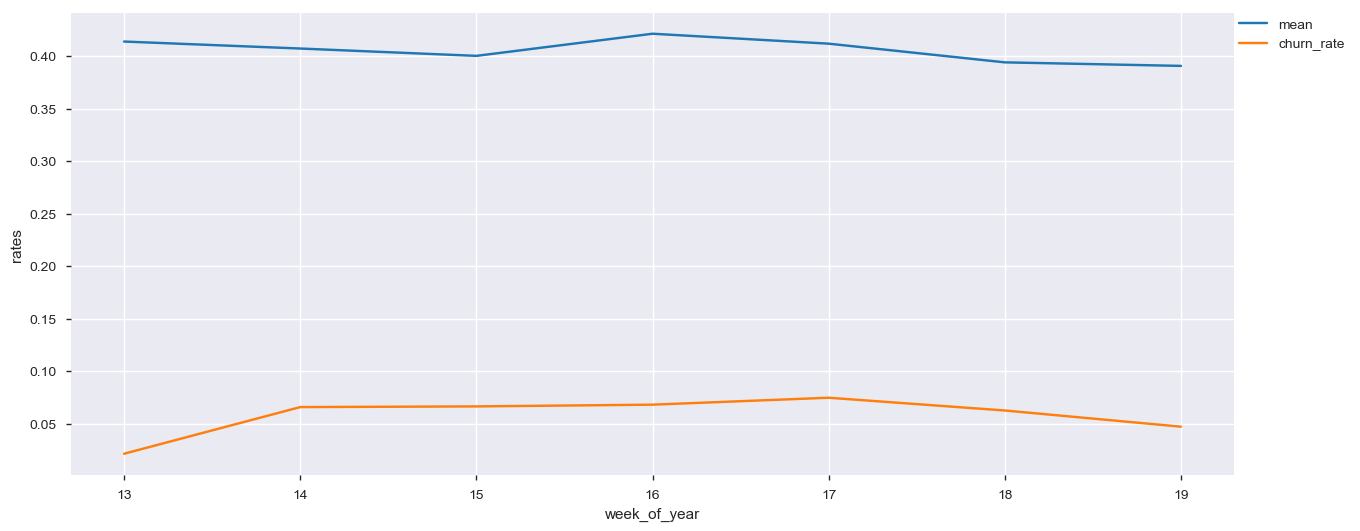

In [106]:
#это контрольная выборка
date = Xt_train[['woy','churn']]

def churn_rate(x):
    """
    Уровень оттока: количество ушедших (в период) / всего пользователей
    """
    return x.values.sum() / len(date['churn'].values)
    
def ret_rate(x):
    """
    Уровень остатка пользователей: все оставшиеся пользователи (в период) / все оставшиеся пользователи
    """
    return len(x.values == 0) / len(date[date['churn'] == 0]['churn'].values)
    
    
results = date.groupby('woy').agg([churn_rate, ret_rate, 'mean'])
results = results['churn']

plt.figure(figsize = (15, 6))
sns.lineplot(x = results.index, y = "mean", label="mean", 
             data=results).set(xlabel="week_of_year", ylabel="rates")
sns.lineplot(x = results.index, y = "churn_rate", label="churn_rate",
             data=results).set(xlabel="week_of_year", ylabel="rates")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

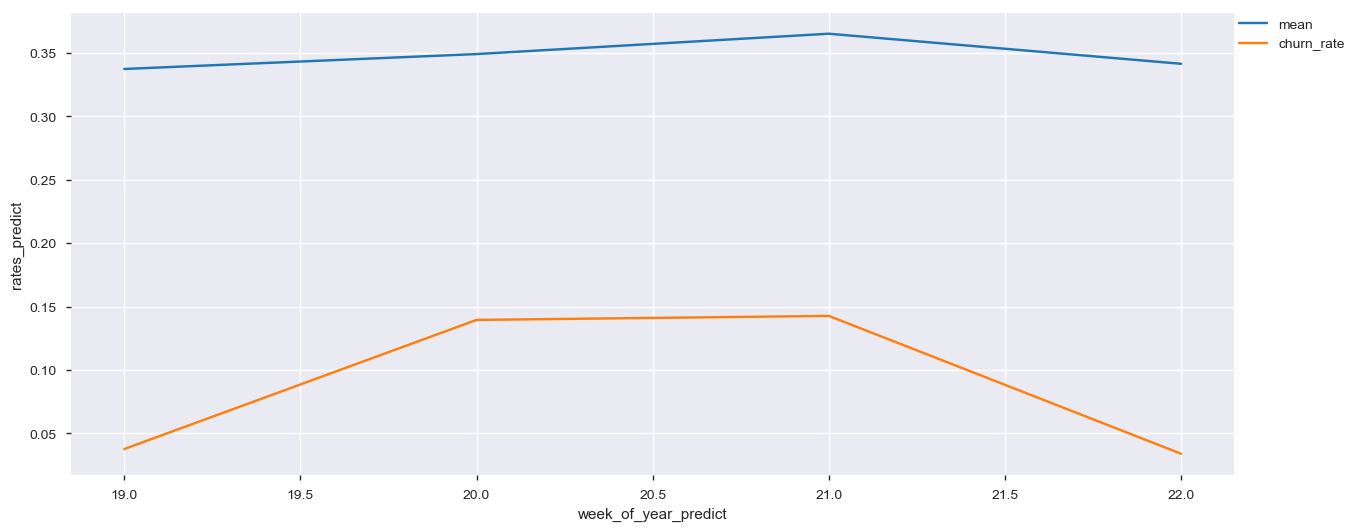

In [107]:
# Это предсказанные значения XGB
res_y = alg_xgb.predict(X_test_xgb[need_vars].values)
new_date = Xt_test[['woy']].head(res_y.__len__())
new_date['churn'] = res_y

def churn_rate_test(x):
    """
    Уровень оттока: количество ушедших (в период) / всего пользователей
    """
    return x.values.sum() / len(Xt_test['churn'].values)
    
def ret_rate_test(x):
    """
    Уровень остатка пользователей: все оставшиеся пользователи (в период) / все оставшиеся пользователи
    """
    return len(x.values == 0) / len(Xt_test[Xt_test['churn'] == 0]['churn'].values)
    
results = new_date.groupby('woy').agg([churn_rate_test, ret_rate_test, 'mean'])
results = results['churn']

plt.figure(figsize = (15, 6))
sns.lineplot(x = results.index, y = "mean", label="mean", 
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
sns.lineplot(x = results.index, y = "churn_rate_test", label="churn_rate",
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

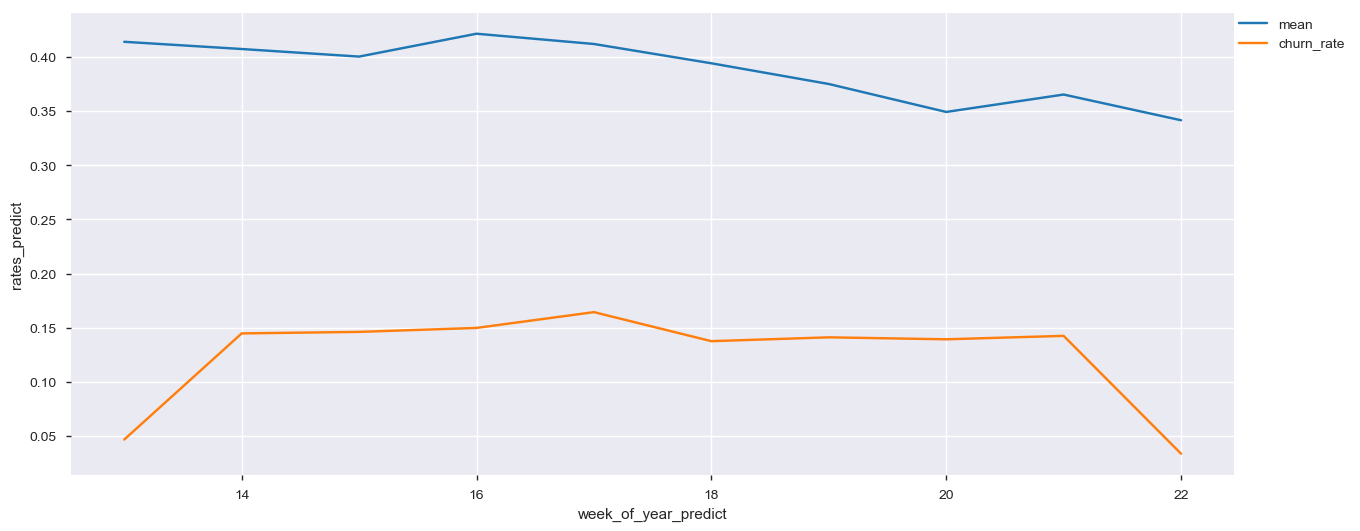

In [105]:
# Это предсказанные значения XGB с существующими
res_y = alg_xgb.predict(X_test_xgb[need_vars].values)
new_date = Xt_test[['woy']].head(res_y.__len__())
new_date['churn'] = res_y
new_date = new_date.append(pd.DataFrame(Xt_train[['woy','churn']]))


def churn_rate_test(x):
    """
    Уровень оттока: количество ушедших (в период) / всего пользователей
    """
    return x.values.sum() / len(Xt_test['churn'].values)
    
    
results = new_date.groupby('woy').agg([churn_rate_test, ret_rate_test, 'mean'])
results = results['churn']

plt.figure(figsize = (15, 6))
sns.lineplot(x = results.index, y = "mean", label="mean", 
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
sns.lineplot(x = results.index, y = "churn_rate_test", label="churn_rate",
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

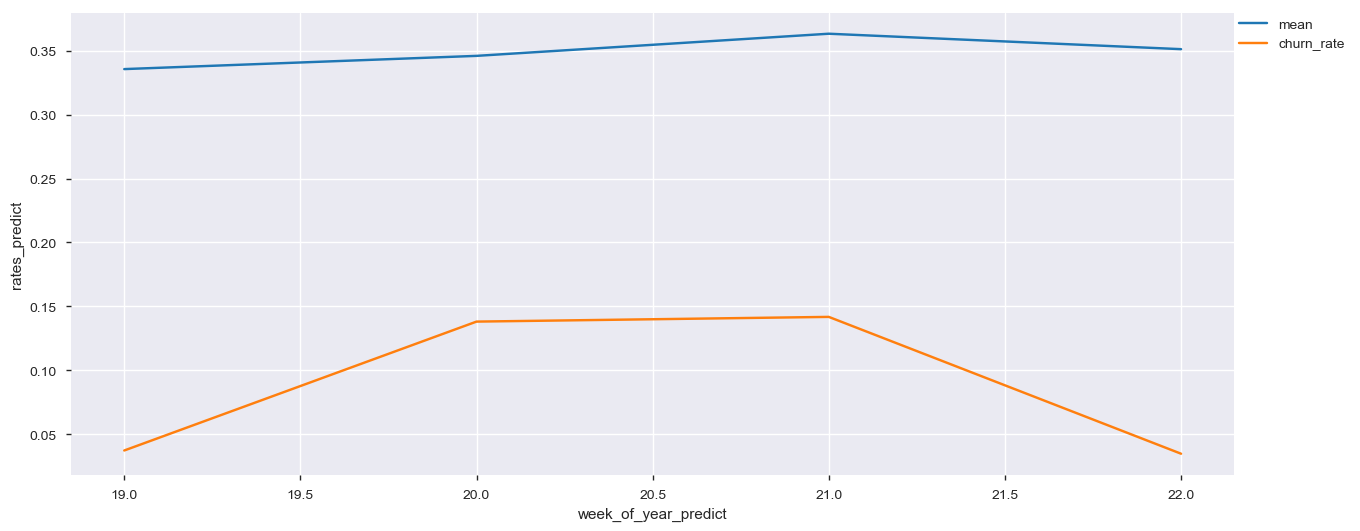

In [108]:
# Это предсказанные значения CatBoost
res_y = alg_cat.predict(X_test_cat[need_vars].values)
new_date = Xt_test[['woy']].head(res_y.__len__())
new_date['churn'] = res_y

def churn_rate_test(x):
    """
    Уровень оттока: количество ушедших (в период) / всего пользователей
    """
    return x.values.sum() / len(Xt_test['churn'].values)
    
def ret_rate_test(x):
    """
    Уровень остатка пользователей: все оставшиеся пользователи (в период) / все оставшиеся пользователи
    """
    return len(x.values == 0) / len(Xt_test[Xt_test['churn'] == 0]['churn'].values)
    
results = new_date.groupby('woy').agg([churn_rate_test, ret_rate_test, 'mean'])
results = results['churn']

plt.figure(figsize = (15, 6))
sns.lineplot(x = results.index, y = "mean", label="mean", 
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
sns.lineplot(x = results.index, y = "churn_rate_test", label="churn_rate",
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

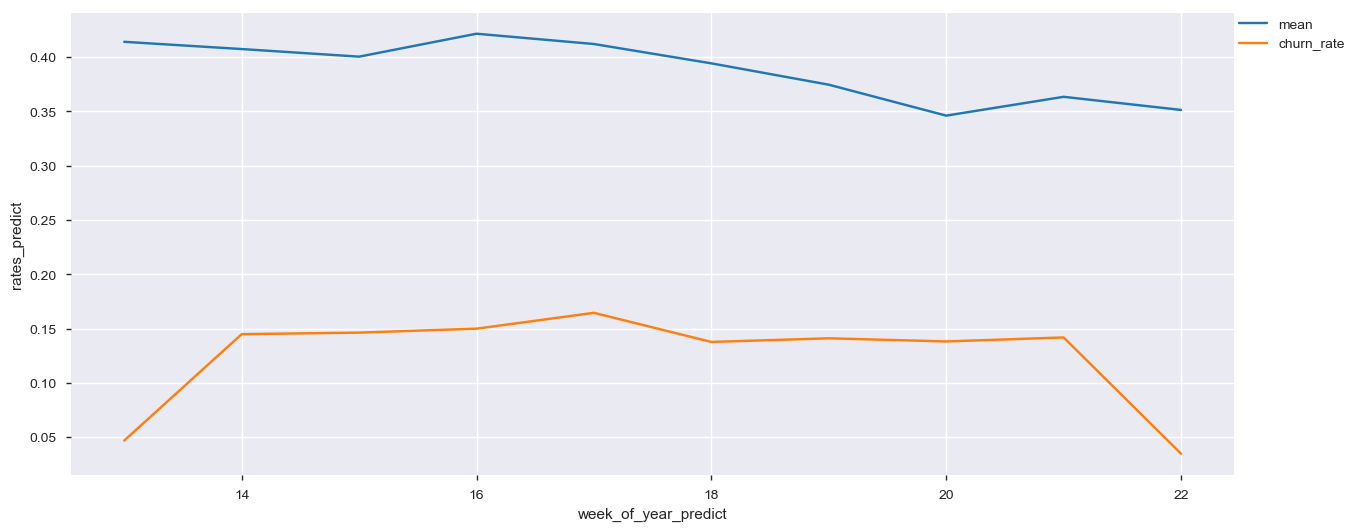

In [109]:
# Это предсказанные значения CatBoost
res_y = alg_cat.predict(X_test_cat[need_vars].values)
new_date = Xt_test[['woy']].head(res_y.__len__())
new_date['churn'] = res_y
new_date = new_date.append(pd.DataFrame(Xt_train[['woy','churn']]))

def churn_rate_test(x):
    """
    Уровень оттока: количество ушедших (в период) / всего пользователей
    """
    return x.values.sum() / len(Xt_test['churn'].values)
    
def ret_rate_test(x):
    """
    Уровень остатка пользователей: все оставшиеся пользователи (в период) / все оставшиеся пользователи
    """
    return len(x.values == 0) / len(Xt_test[Xt_test['churn'] == 0]['churn'].values)
    
results = new_date.groupby('woy').agg([churn_rate_test, ret_rate_test, 'mean'])
results = results['churn']

plt.figure(figsize = (15, 6))
sns.lineplot(x = results.index, y = "mean", label="mean", 
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
sns.lineplot(x = results.index, y = "churn_rate_test", label="churn_rate",
             data=results).set(xlabel="week_of_year_predict", ylabel="rates_predict")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)